In [1]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle
import logging
import pprint

import os # read directories etc.
from scipy.optimize import curve_fit
import pylandau

# import time
# from timeout_decorator import timeout

from LoadBatch import *
from SensorClasses import *

verbose = False


In [2]:
# logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] - \t %(message)s')

In [3]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
### I should just have many options for ranges and choose between those
large_bins = (np.arange(0, 900,1),
              np.arange(0, 900,1))

bins1 = (np.arange(450, 700, 1),
        np.arange(150, 450, 1))

bins2 = (np.arange(500, 650, 1),
              np.arange(200, 450, 1))

### Load the dictionary of sensor names and runs
# sensors_list = read_pickle("sensors_list.pickle")  ### I still need the sensor_list for now. No I don't
dict_of_runs = read_pickle("dict_of_runs.pickle")
dict_of_batches = read_pickle("dict_of_batches.pickle")

logging.info(f"dictionary of the runs: \n{dict_of_runs}")
logging.info(f"dictionary of the batches: \n{dict_of_batches}")

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

[INFO] - 	 dictionary of the runs: 
{'S1': {199: [9577, 9578, 9579, 9580, 9581], 100: [9564, 9565, 9567, 9568, 9570], 101: [9574], 201: [9587, 9588, 9590], 202: [9591, 9592, 9593, 9594], 203: [9595, 9596, 9602], 301: [9609, 9611, 9613, 9614, 9615, 9616], 401: [9620, 9621, 9622, 9624, 9625, 9627, 9628, 9629, 9630], 402: [9631, 9632, 9633, 9636, 9637, 9638, 9639], 403: [9640, 9642, 9644, 9645, 9646], 204: [9672, 9673, 9674], 406: [9677, 9678, 9679, 9680, 9694], 407: [9683, 9684, 9685, 9686, 9687, 9688, 9689, 9691, 9692, 9693], 408: [9695, 9696, 9698], 409: [9701, 9702, 9703], 410: [9704, 9705], 411: [9721, 9722, 9723, 9728, 9729, 9730, 9731, 9732, 9733], 412: [9734, 9735, 9736, 9737, 9738], 205: [9742, 9743, 9744, 9745], 206: [9746, 9747, 9748, 9750], 413: [9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9775], 414: [9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786], 501: [9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805], 502: [9807, 9817, 9818, 9819, 9820, 982

In [4]:
unique_names = []
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if (sensor.name != '') and (sensor.name not in unique_names):
                unique_names.append(sensor.name)
logging.info(f"{unique_names}")

for name in unique_names:
    for batch_object in dict_of_batches.values():
        for S in ['S1','S2']:  
                for ch, sensor in batch_object.S[S].channels.items():
                    if (sensor.name == name):
                        print(f"{sensor.name}, board: {sensor.board}\tV: {sensor.voltage}, angle: {batch_object.angle}°,", "temp: %.2f°C,"%batch_object.tempA, f"fluence: {sensor.fluence}, in batch {batch_object.batch_number}, {S}, {ch})")
    print('-'*100)

[INFO] - 	 ['MCP', 'IMEv3-W12-C2-2-2', 'IMEv3-W12-C3-1-4', 'CNM-R15973-W5-D138', 'CNM-R15973-W4-D168', 'IMEv3-W12-C3-1-5', 'USTC2.1-W17-P6-A', 'JSI-PP4-IMEv2-W7-6.5E14', 'JSI-B7-IMEv3-W16-8E14', 'JSI-B13-IMEv3-W16-2.5E15', 'JSI-B6-IMEv2-W7-1E14', 'JSI-PP1', 'CERN2-CH0-IMEv3-W12', 'CERN2-CH1-IMEv3-W12', 'CERN2-CH2-IMEv3-W12', 'JSI-B5-CNM-W3-2.5E15', 'CERN2-CH4-IMEv3-W16', 'JSI-B2-USTC-V2.1-W17-2E14']


MCP, board:  	V: 2600, angle: 0.0°, temp: -31.02°C, fluence: 0, in batch 199, S1, Ch1)
MCP, board:  	V: 2600, angle: 0.0°, temp: -31.02°C, fluence: 0, in batch 199, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.84°C, fluence: 0, in batch 100, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.84°C, fluence: 0, in batch 100, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -33.30°C, fluence: 0, in batch 101, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -33.30°C, fluence: 0, in batch 101, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -31.33°C, fluence: 0, in batch 201, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -31.33°C, fluence: 0, in batch 201, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.23°C, fluence: 0, in batch 202, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.23°C, fluence: 0, in batch 202, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.33°C, fluence: 0, in batch 203, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -

## USTC
looking specifically at one sensor

In [5]:
USTC_list = []
USTC_dict = {'room_temp':[], 'angled':[], 'normal_2500':[], 'normal_2600':[], 'normal_2800':[]}
this_sensor = 'USTC'
### maybe I can make all this weird iterations into a function
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if this_sensor in sensor.name:
                USTC_list.append((batch_object.batch_number, S, ch))
                if batch_object.tempA<0 and batch_object.S[S].channels['Ch1'].voltage==2500 and batch_object.angle==0:
                    USTC_dict['normal_2500'].append((batch_object.batch_number, S, ch))
                if batch_object.tempA<0 and batch_object.S[S].channels['Ch1'].voltage==2600 and batch_object.angle==0:
                    USTC_dict['normal_2600'].append((batch_object.batch_number, S, ch))    
#                 if batch_object.tempA<0 and batch_object.S[S].channels['Ch1'].voltage==2800 and batch_object.angle==0:
#                     USTC_dict['normal_2800'].append((batch_object.batch_number, S, ch))                 
                if batch_object.tempA>0:# and batch_object.S[S].channels['Ch1'].voltage==2500:
                    USTC_dict['room_temp'].append((batch_object.batch_number, S, ch))
                if batch_object.angle>0:
                    USTC_dict['angled'].append((batch_object.batch_number, S, ch))

### I add the zero angles with same voltages in the 'angled' 403,406,407
batches,S,chs = zip(*USTC_list)
for idx, batch in enumerate(batches):
    if batch in (403,406,407):
        USTC_dict['angled'].append((batches[idx],S[idx],chs[idx]))  

logging.info(f"{USTC_list}")

[INFO] - 	 [(301, 'S1', 'Ch2'), (301, 'S1', 'Ch3'), (401, 'S1', 'Ch2'), (401, 'S1', 'Ch3'), (402, 'S1', 'Ch2'), (402, 'S1', 'Ch3'), (403, 'S1', 'Ch2'), (403, 'S1', 'Ch3'), (406, 'S1', 'Ch2'), (406, 'S1', 'Ch3'), (407, 'S1', 'Ch2'), (407, 'S1', 'Ch3'), (408, 'S1', 'Ch2'), (408, 'S1', 'Ch3'), (409, 'S1', 'Ch2'), (409, 'S1', 'Ch3'), (410, 'S1', 'Ch2'), (410, 'S1', 'Ch3'), (411, 'S1', 'Ch2'), (411, 'S1', 'Ch3'), (412, 'S1', 'Ch2'), (412, 'S1', 'Ch3'), (413, 'S1', 'Ch2'), (413, 'S1', 'Ch3'), (414, 'S1', 'Ch2'), (414, 'S1', 'Ch3'), (1301, 'S2', 'Ch3'), (1302, 'S2', 'Ch3'), (1303, 'S2', 'Ch3'), (1304, 'S2', 'Ch3'), (1305, 'S2', 'Ch3'), (1306, 'S2', 'Ch3')]


In [6]:
USTC_dict['room_temp']
# USTC_dict['normal_2500']
# USTC_dict['normal_2600']
# USTC_dict['normal_2800']
USTC_dict['angled'] # + 403,406,407

[(411, 'S1', 'Ch2'),
 (411, 'S1', 'Ch3'),
 (412, 'S1', 'Ch2'),
 (412, 'S1', 'Ch3'),
 (413, 'S1', 'Ch2'),
 (413, 'S1', 'Ch3'),
 (414, 'S1', 'Ch2'),
 (414, 'S1', 'Ch3'),
 (403, 'S1', 'Ch2'),
 (403, 'S1', 'Ch3'),
 (406, 'S1', 'Ch2'),
 (406, 'S1', 'Ch3'),
 (407, 'S1', 'Ch2'),
 (407, 'S1', 'Ch3')]

#### Create empty dictionary to store the dataframes

In [7]:
try: dict_analysis
except NameError:
    logging.warning("Creating new empty dictionary to store analysis dataframes")
    dict_analysis = {}

[WARNING] - 	 Creating new empty dictionary to store analysis dataframes


### Create an emtpy dataframe and later add values extracted that I want
added value that it's easier to extract batch number, oscilloscope and channel without repetition

In [34]:
# key_to_study = 'room_temp'
# key_to_study = 'normal_2500'
# key_to_study = 'normal_2800'
key_to_study = 'angled'
batches_to_study = USTC_dict[key_to_study]

multi_index = pd.MultiIndex.from_tuples(batches_to_study, names=['batch', 'oscilloscope','channel'])
df_analyis = pd.DataFrame(index=multi_index)

### apparently all the runs from 412 are empty, and for some reason I have to remove the unused level
df_analyis.drop(index=412, level=0, inplace=True)
df_analyis.index = df_analyis.index.remove_unused_levels()

display(df_analyis)

Empty DataFrame
Columns: []
Index: [(411, S1, Ch2), (411, S1, Ch3), (413, S1, Ch2), (413, S1, Ch3), (414, S1, Ch2), (414, S1, Ch3), (403, S1, Ch2), (403, S1, Ch3), (406, S1, Ch2), (406, S1, Ch3), (407, S1, Ch2), (407, S1, Ch3)]

## Plots

[INFO] - 	 Loading batch 411 	 Oscilloscope S1
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 in 'time_mask()': Fit parameters [  134.15134049 -3382.87907926 21892.72223527   -23.48451683]
[INFO] - 	 in 'time_mask()': Fit parameters [  134.0499309  -3299.67722278 21529.47066419   -21.61741954]
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[IN

MCP: 2500 V, angle: 13.0° temperature:-29.169999999999998°C
Batch:411, Scope:S1, Channel:Ch2


[INFO] - 	 First charge estimate: 0.06107768416404724


Batch:411, Scope:S1, Channel:Ch3


[INFO] - 	 Loading batch 413 	 Oscilloscope S1
[INFO] - 	 in 'time_mask()': Fit parameters [23818.63187424 -5535.65711261    53.13003199   235.85979904]
[INFO] - 	 in 'time_mask()': Fit parameters [37018.89472256 -5563.07604733    44.04949696   228.35755356]
[INFO] - 	 First charge estimate: 12.371726989746094


MCP: 2800 V, angle: 6.0° temperature:-30.52°C
Batch:413, Scope:S1, Channel:Ch2


[INFO] - 	 First charge estimate: 12.765436172485352


Batch:413, Scope:S1, Channel:Ch3


[INFO] - 	 Loading batch 414 	 Oscilloscope S1
[INFO] - 	 in 'time_mask()': Fit parameters [18956.99469183 -5532.68253103    61.13936999   236.85371972]
[INFO] - 	 in 'time_mask()': Fit parameters [26704.38087003 -5560.08090078   -47.47842711   231.09955998]
[INFO] - 	 First charge estimate: 11.60107421875


MCP: 2800 V, angle: 6.0° temperature:-31.71°C
Batch:414, Scope:S1, Channel:Ch2


[INFO] - 	 First charge estimate: 11.990657806396484


Batch:414, Scope:S1, Channel:Ch3


[INFO] - 	 Loading batch 403 	 Oscilloscope S1
[INFO] - 	 in 'time_mask()': Fit parameters [11632.9353696  -5492.11534793   -73.93195992   113.44188516]
[INFO] - 	 in 'time_mask()': Fit parameters [13220.18033007 -5532.76137262   -72.38729364   110.42734536]
[INFO] - 	 First charge estimate: 10.999667167663574


MCP: 2500 V, angle: 0.0° temperature:-30.96°C
Batch:403, Scope:S1, Channel:Ch2


[INFO] - 	 First charge estimate: 11.837148666381836


Batch:403, Scope:S1, Channel:Ch3


[INFO] - 	 Loading batch 406 	 Oscilloscope S1
[INFO] - 	 in 'time_mask()': Fit parameters [13385.61836293 -5488.53803132   -75.90632301   107.33114226]
[INFO] - 	 in 'time_mask()': Fit parameters [11949.63283141 -5514.77845514   -74.47757484   110.23544613]
[INFO] - 	 First charge estimate: 10.54714584350586


MCP: 2500 V, angle: 0.0° temperature:-29.940000000000005°C
Batch:406, Scope:S1, Channel:Ch2


[INFO] - 	 First charge estimate: 10.648672103881836


Batch:406, Scope:S1, Channel:Ch3


[INFO] - 	 Loading batch 407 	 Oscilloscope S1
[INFO] - 	 in 'time_mask()': Fit parameters [27050.52585112 -5493.54423579   -74.49497375   212.3960798 ]
[INFO] - 	 in 'time_mask()': Fit parameters [24708.62644316 -5519.65094034   -72.52160745   217.85123337]
[INFO] - 	 First charge estimate: 11.33177375793457


MCP: 2500 V, angle: 0.0° temperature:-29.809999999999995°C
Batch:407, Scope:S1, Channel:Ch2


[INFO] - 	 First charge estimate: 12.294513702392578


Batch:407, Scope:S1, Channel:Ch3


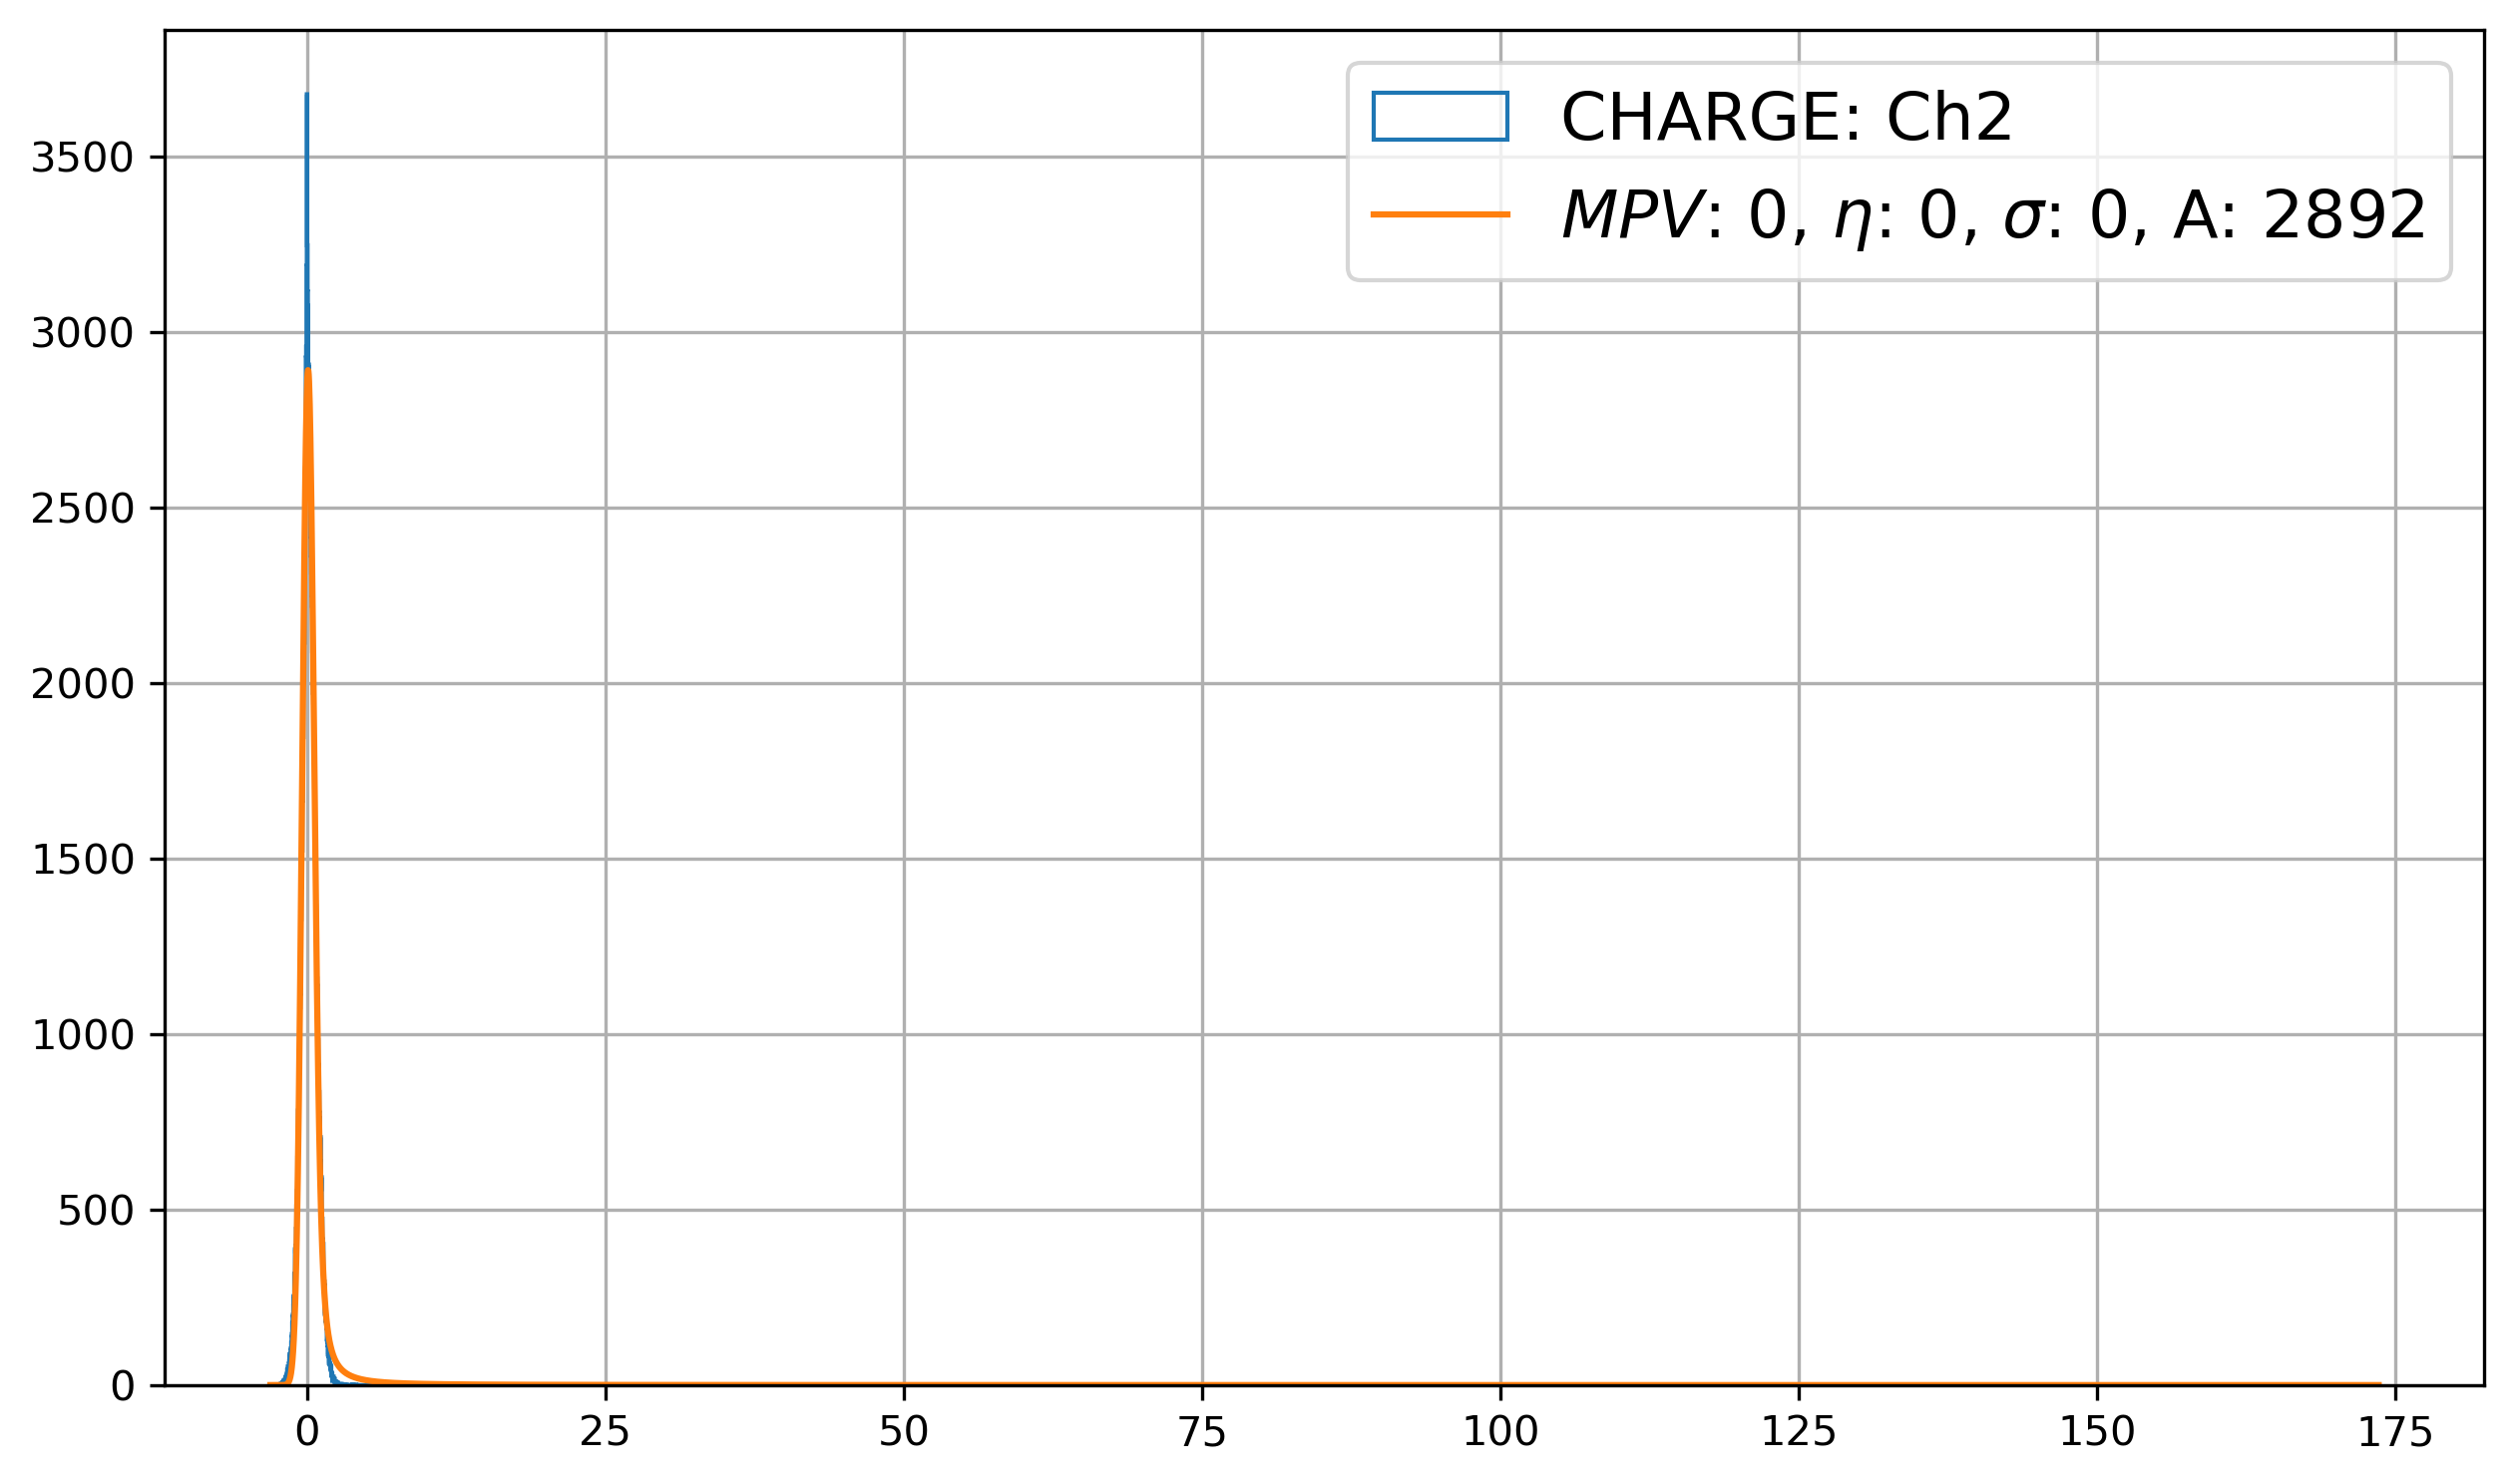

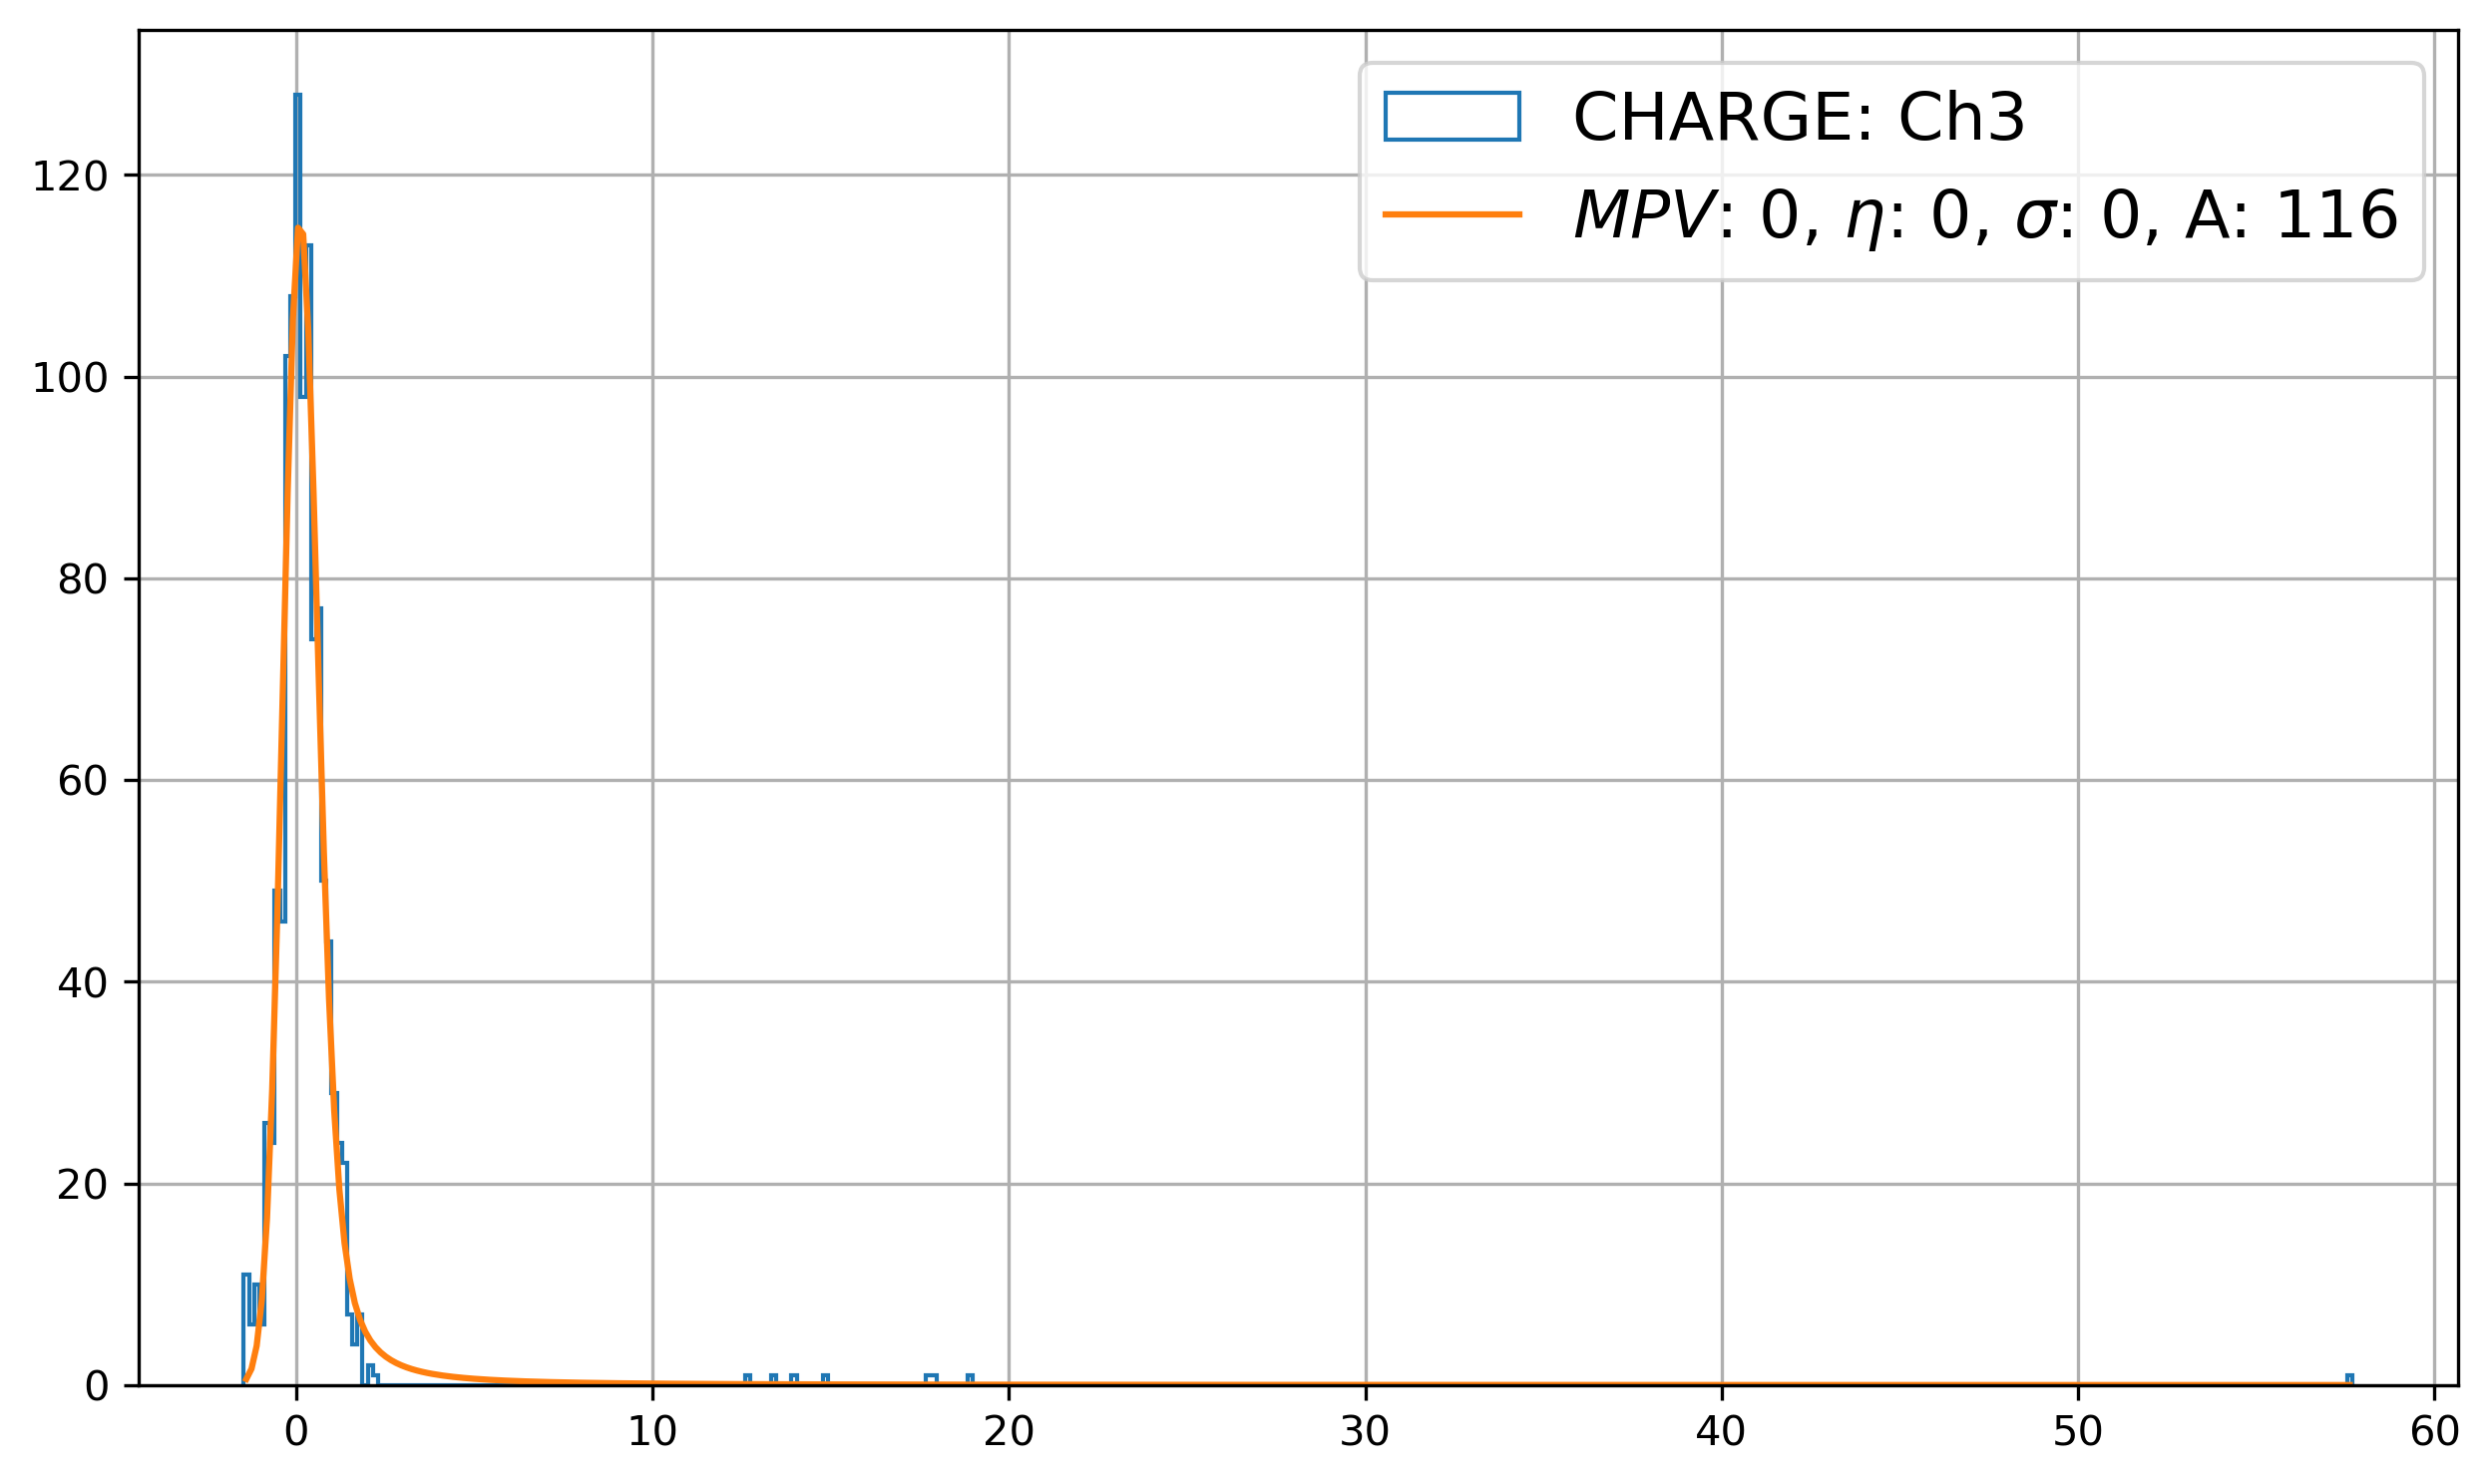

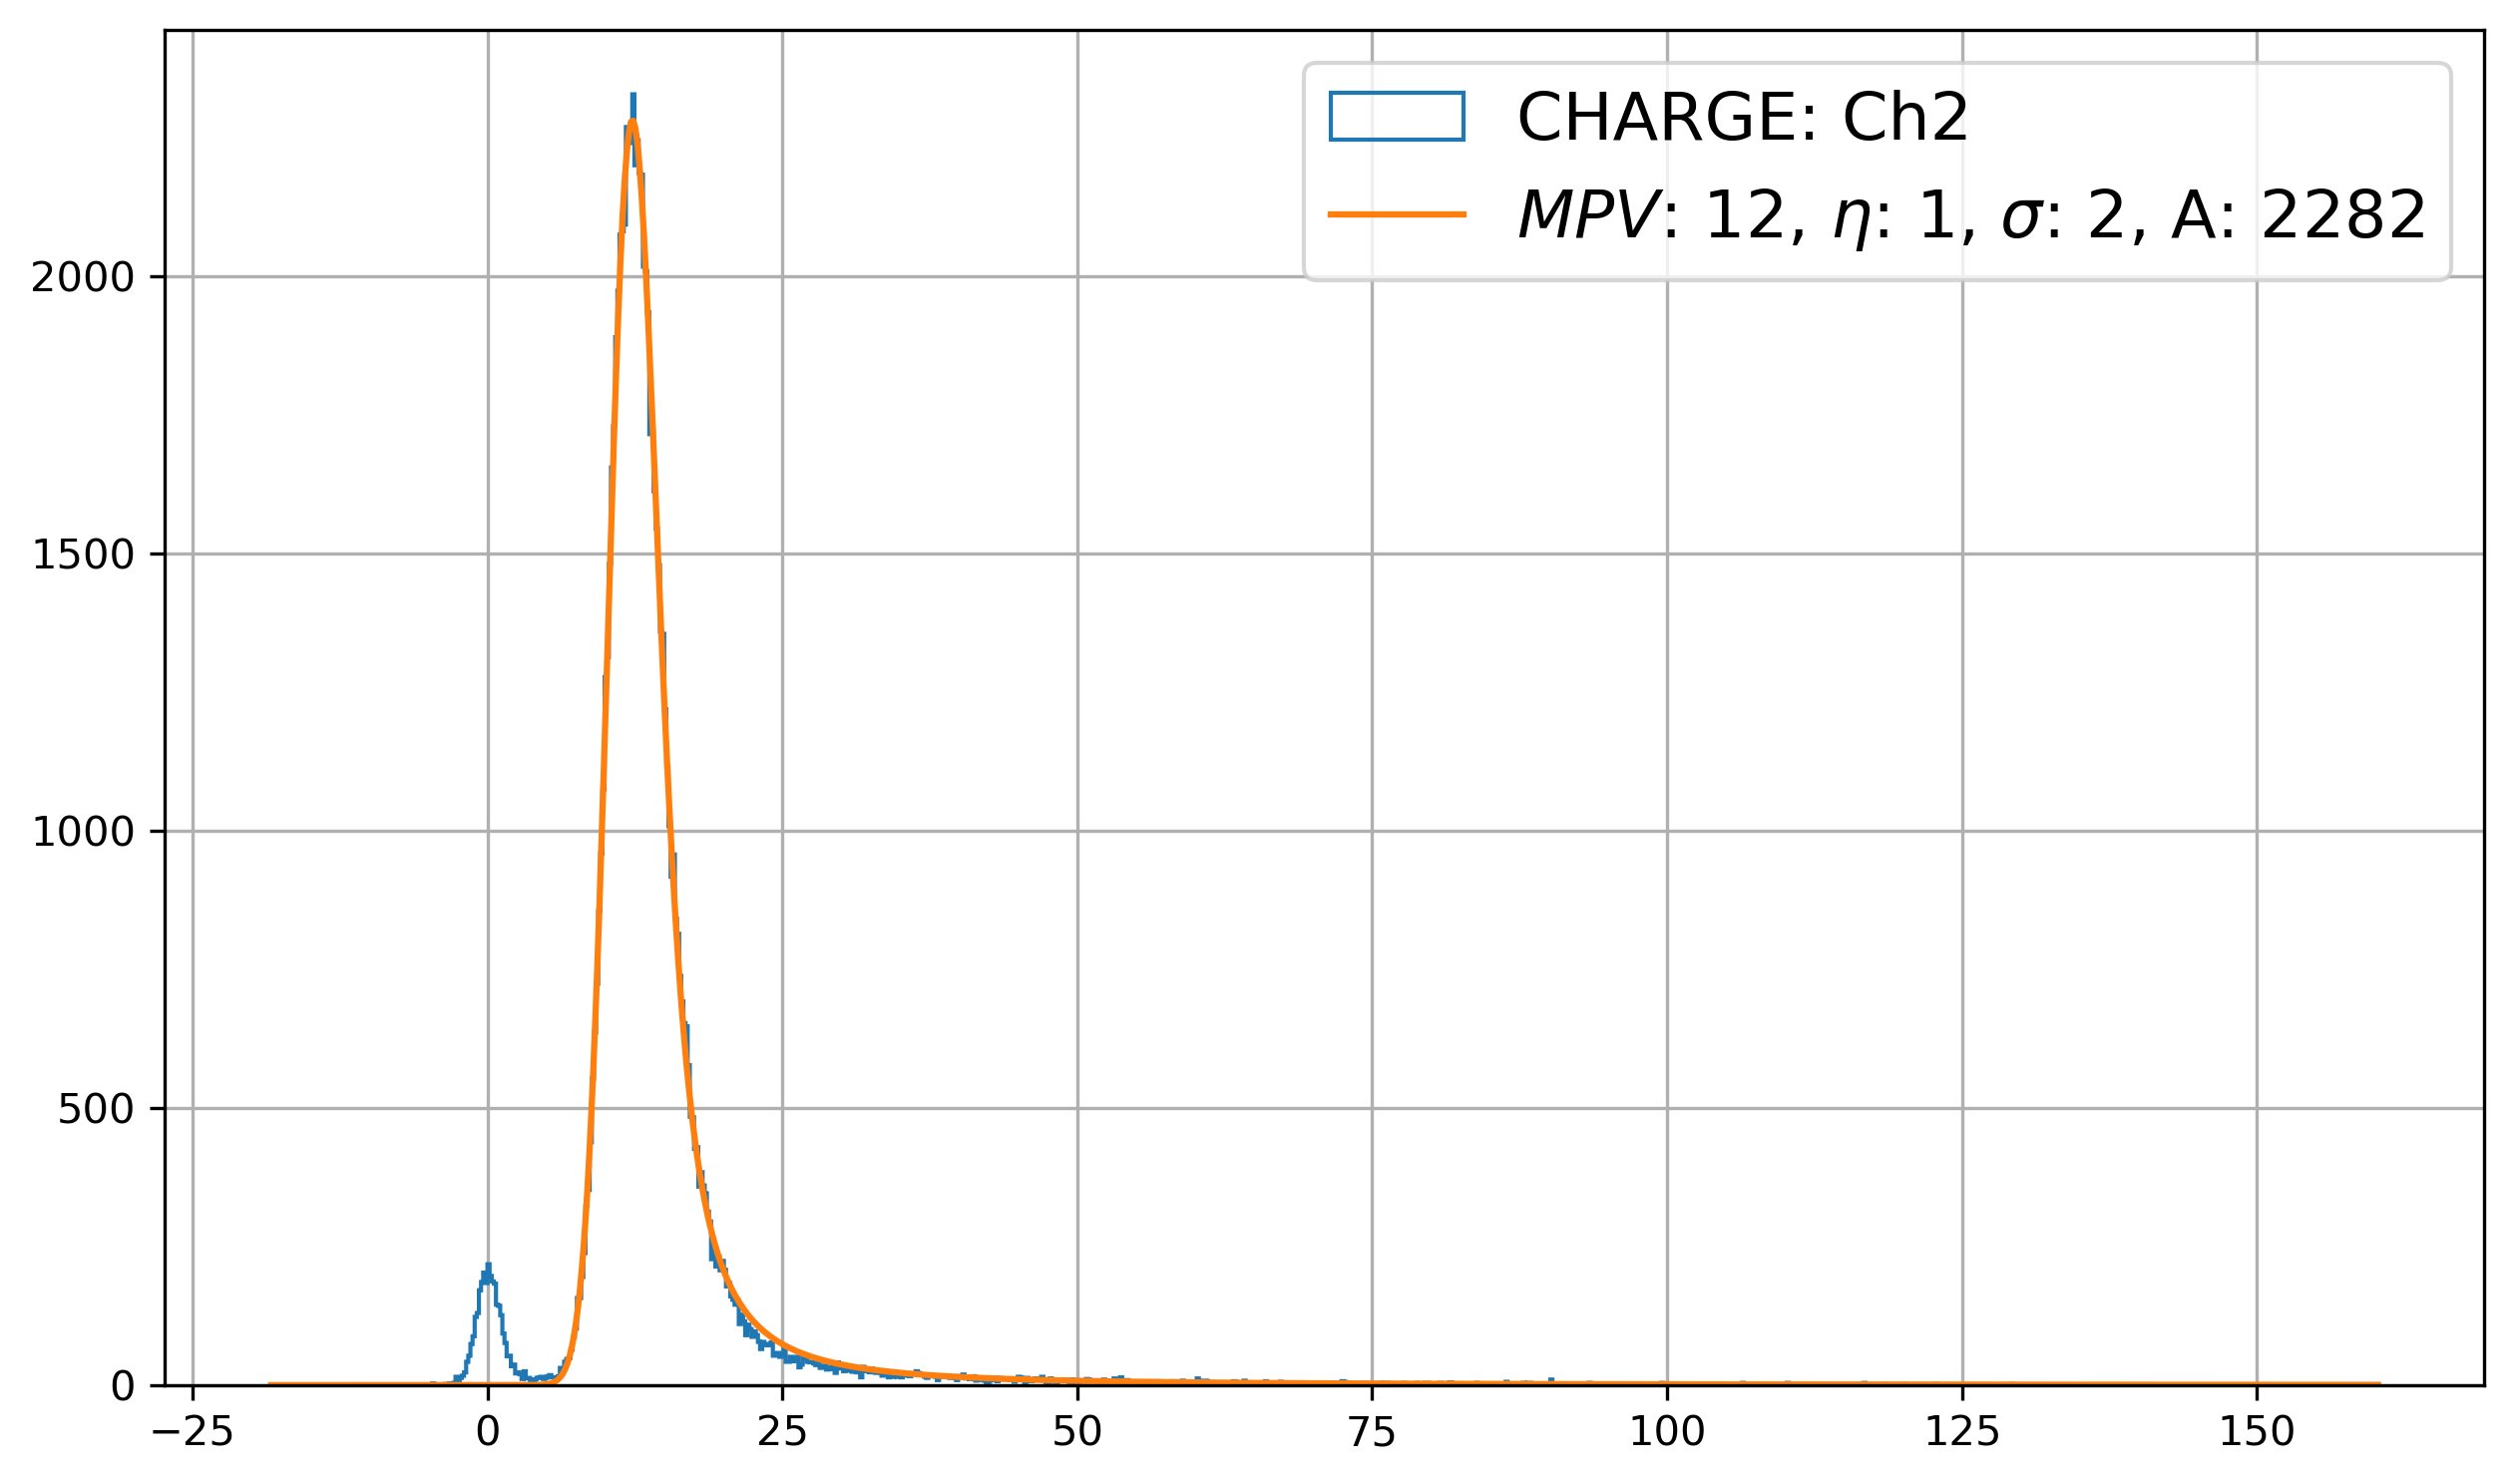

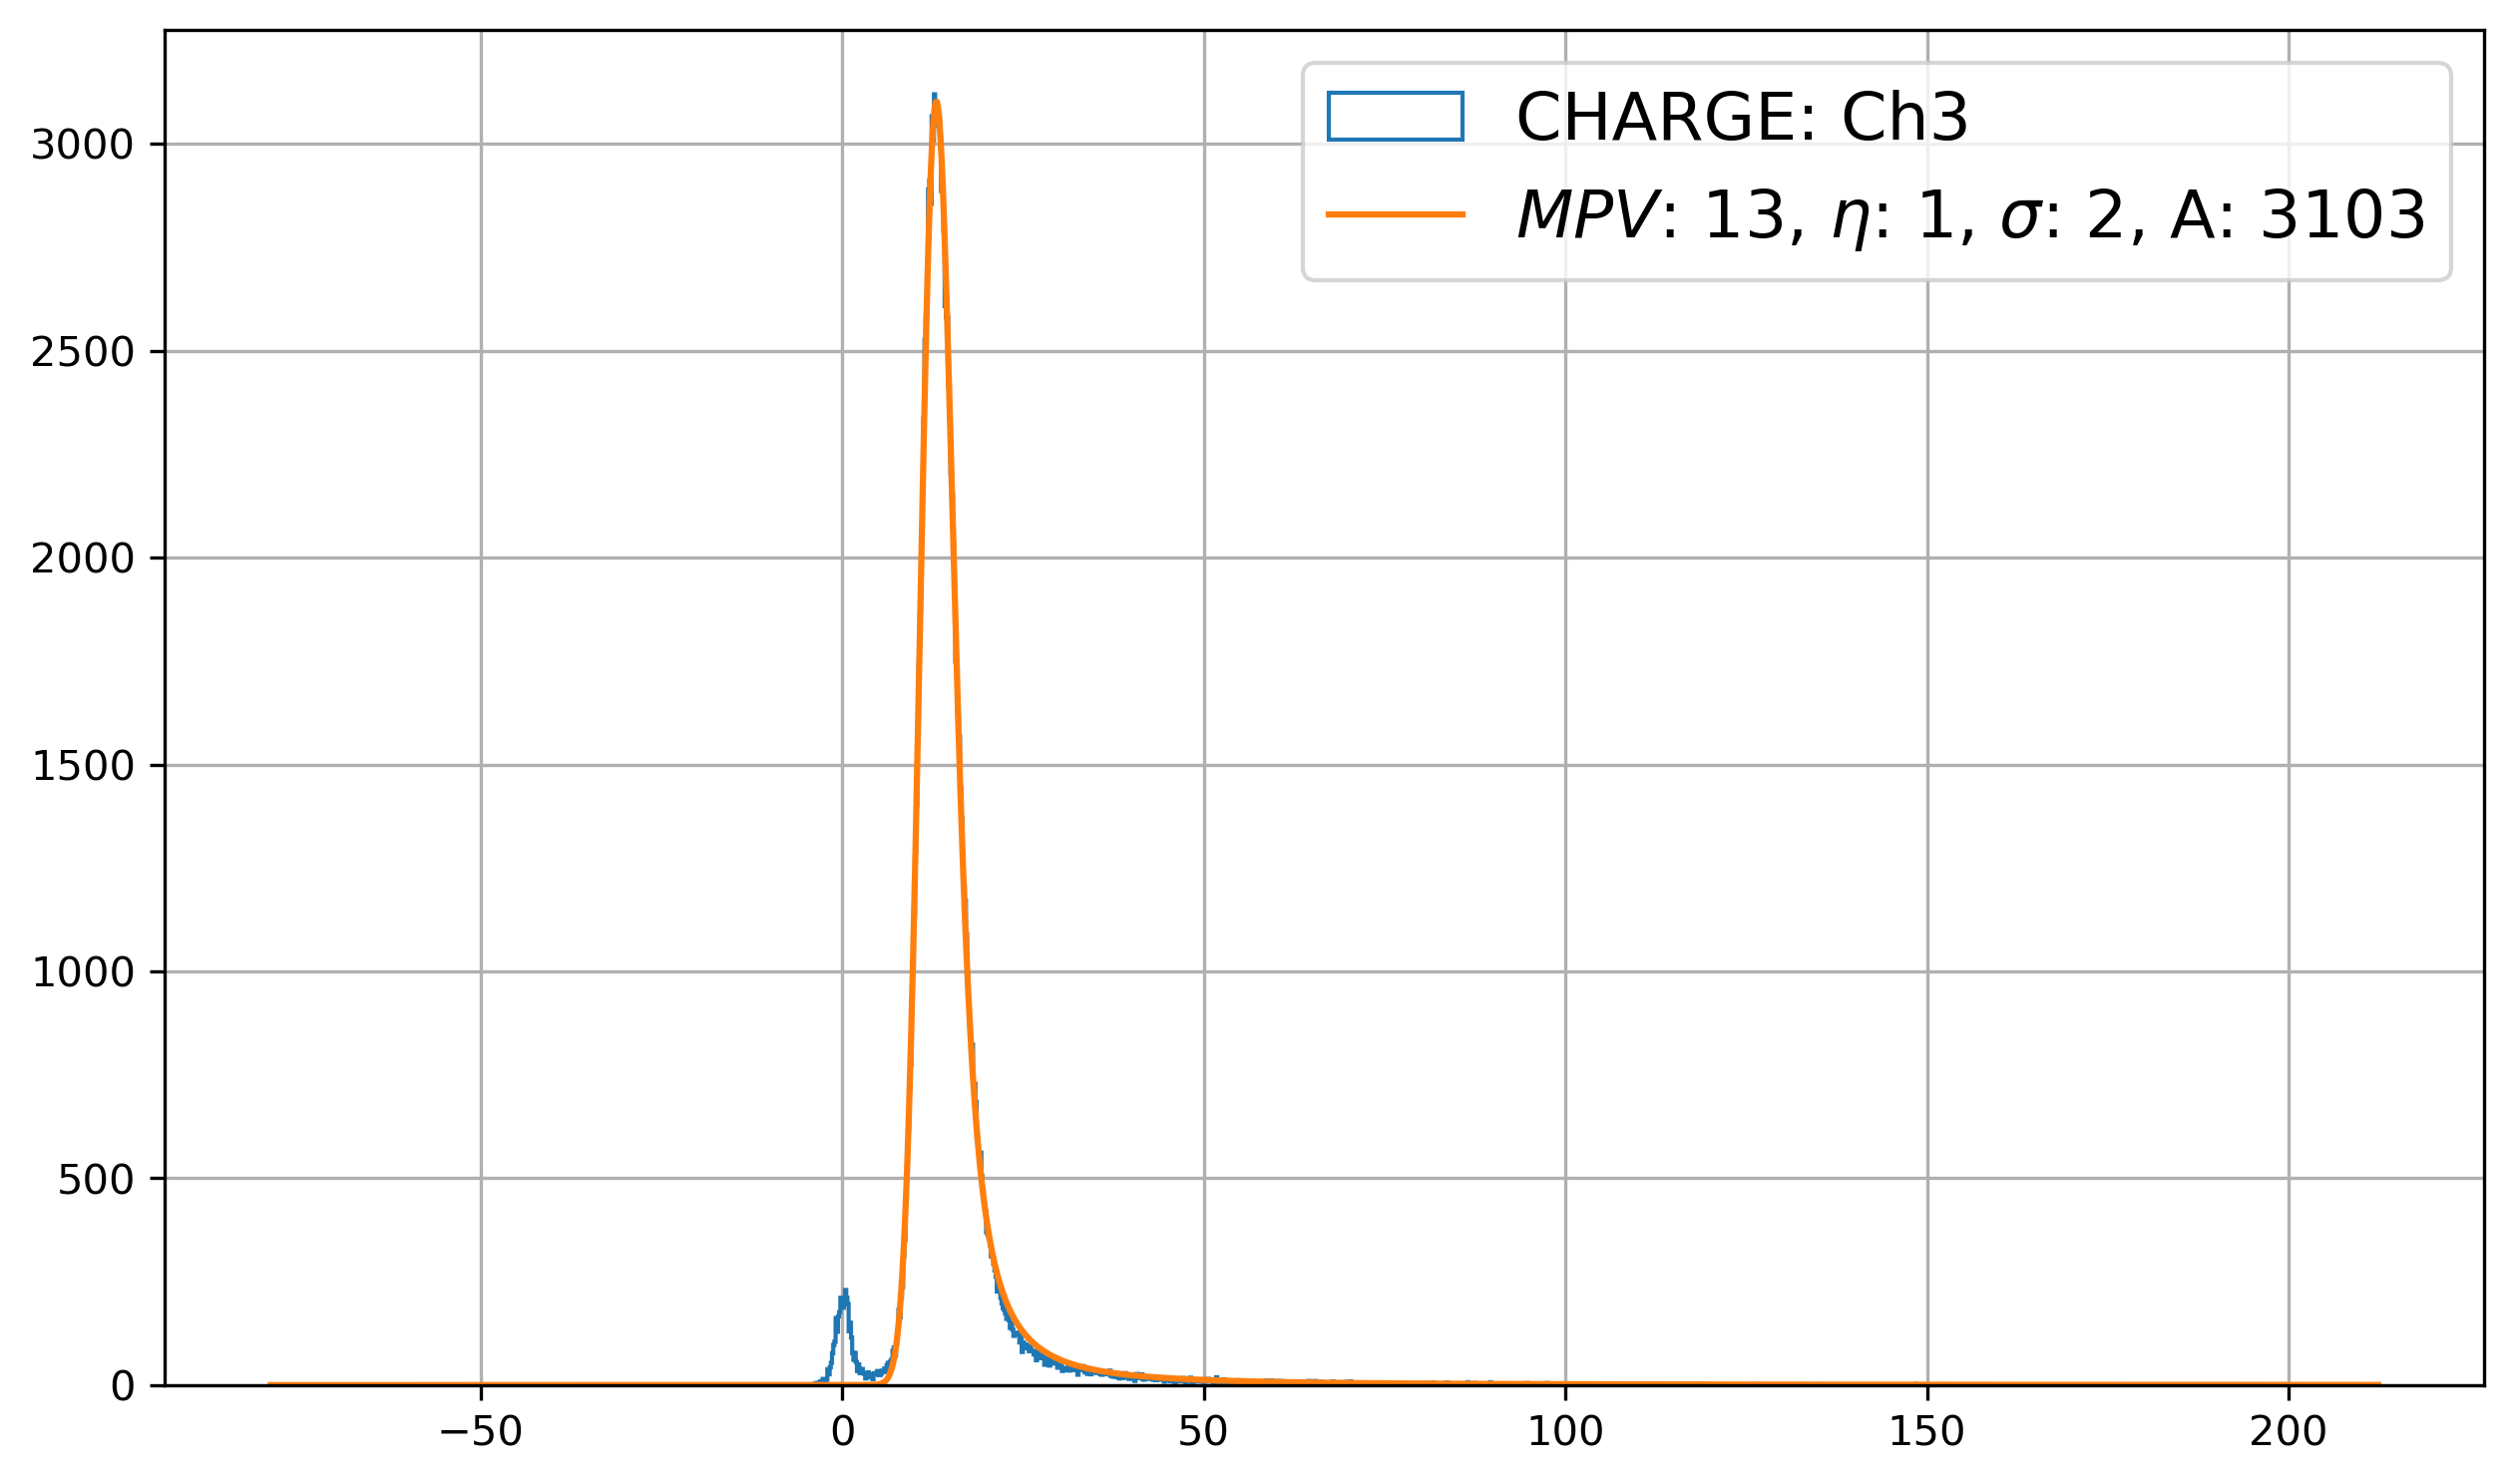

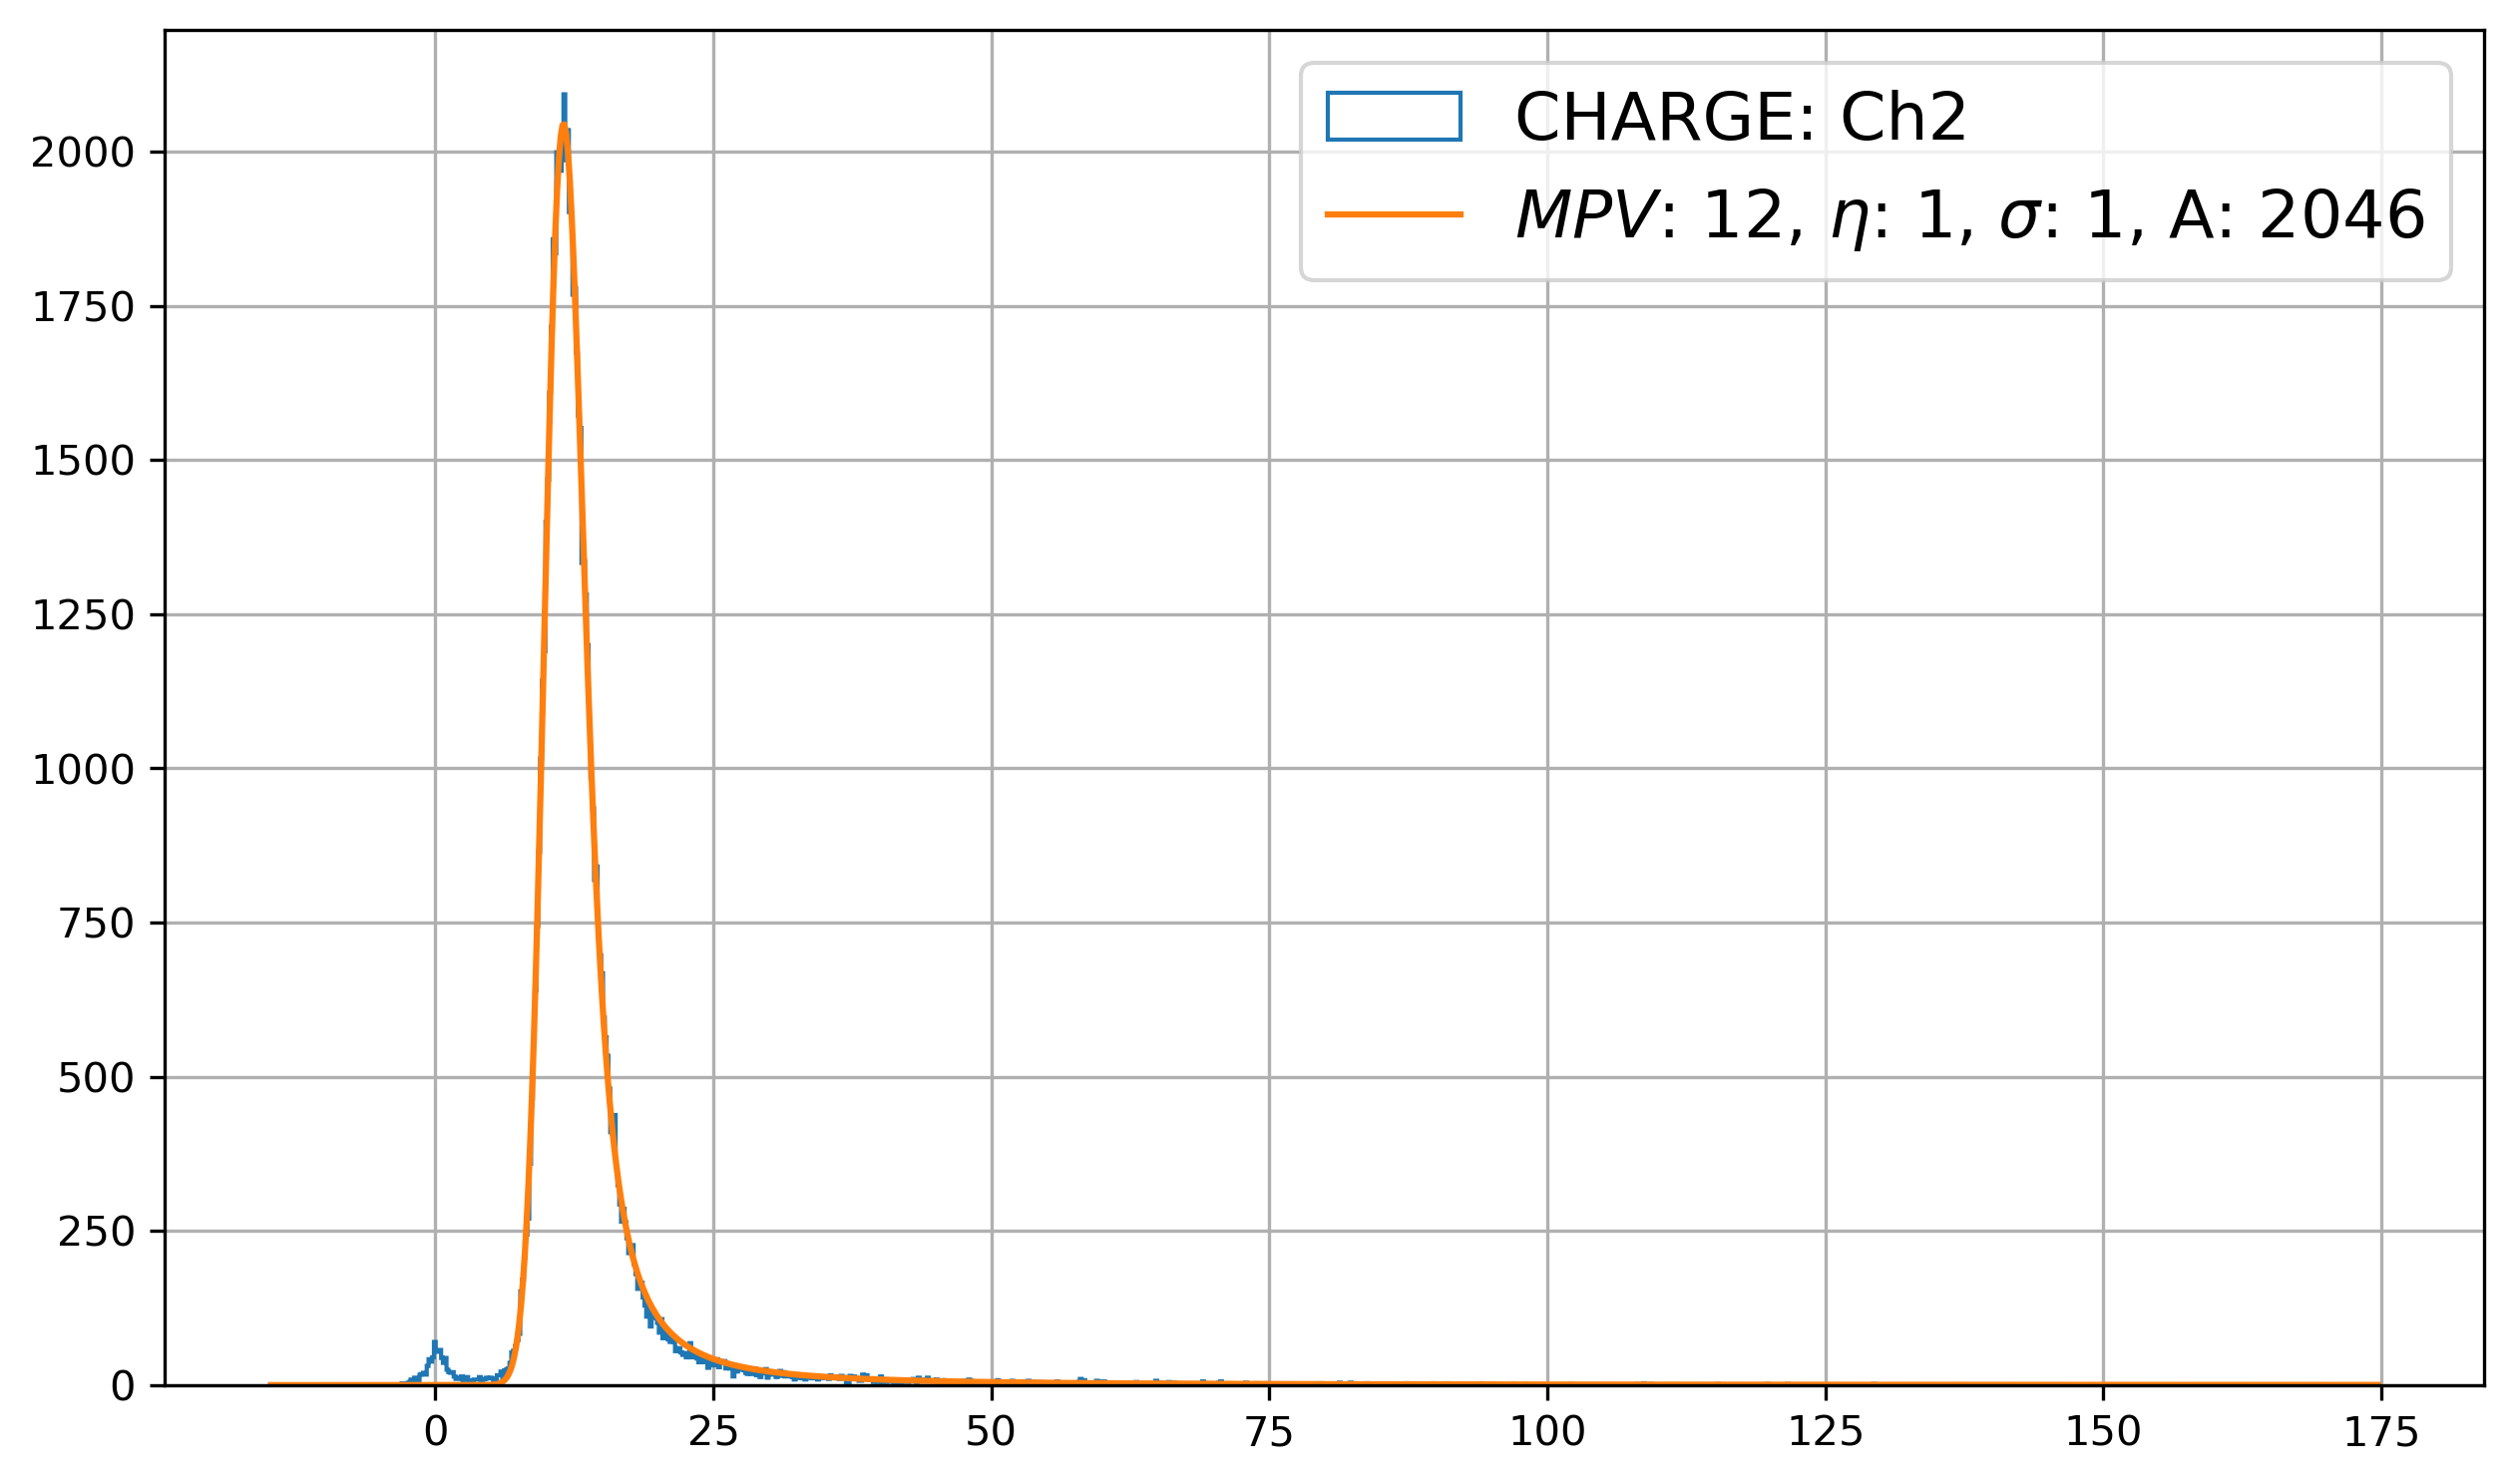

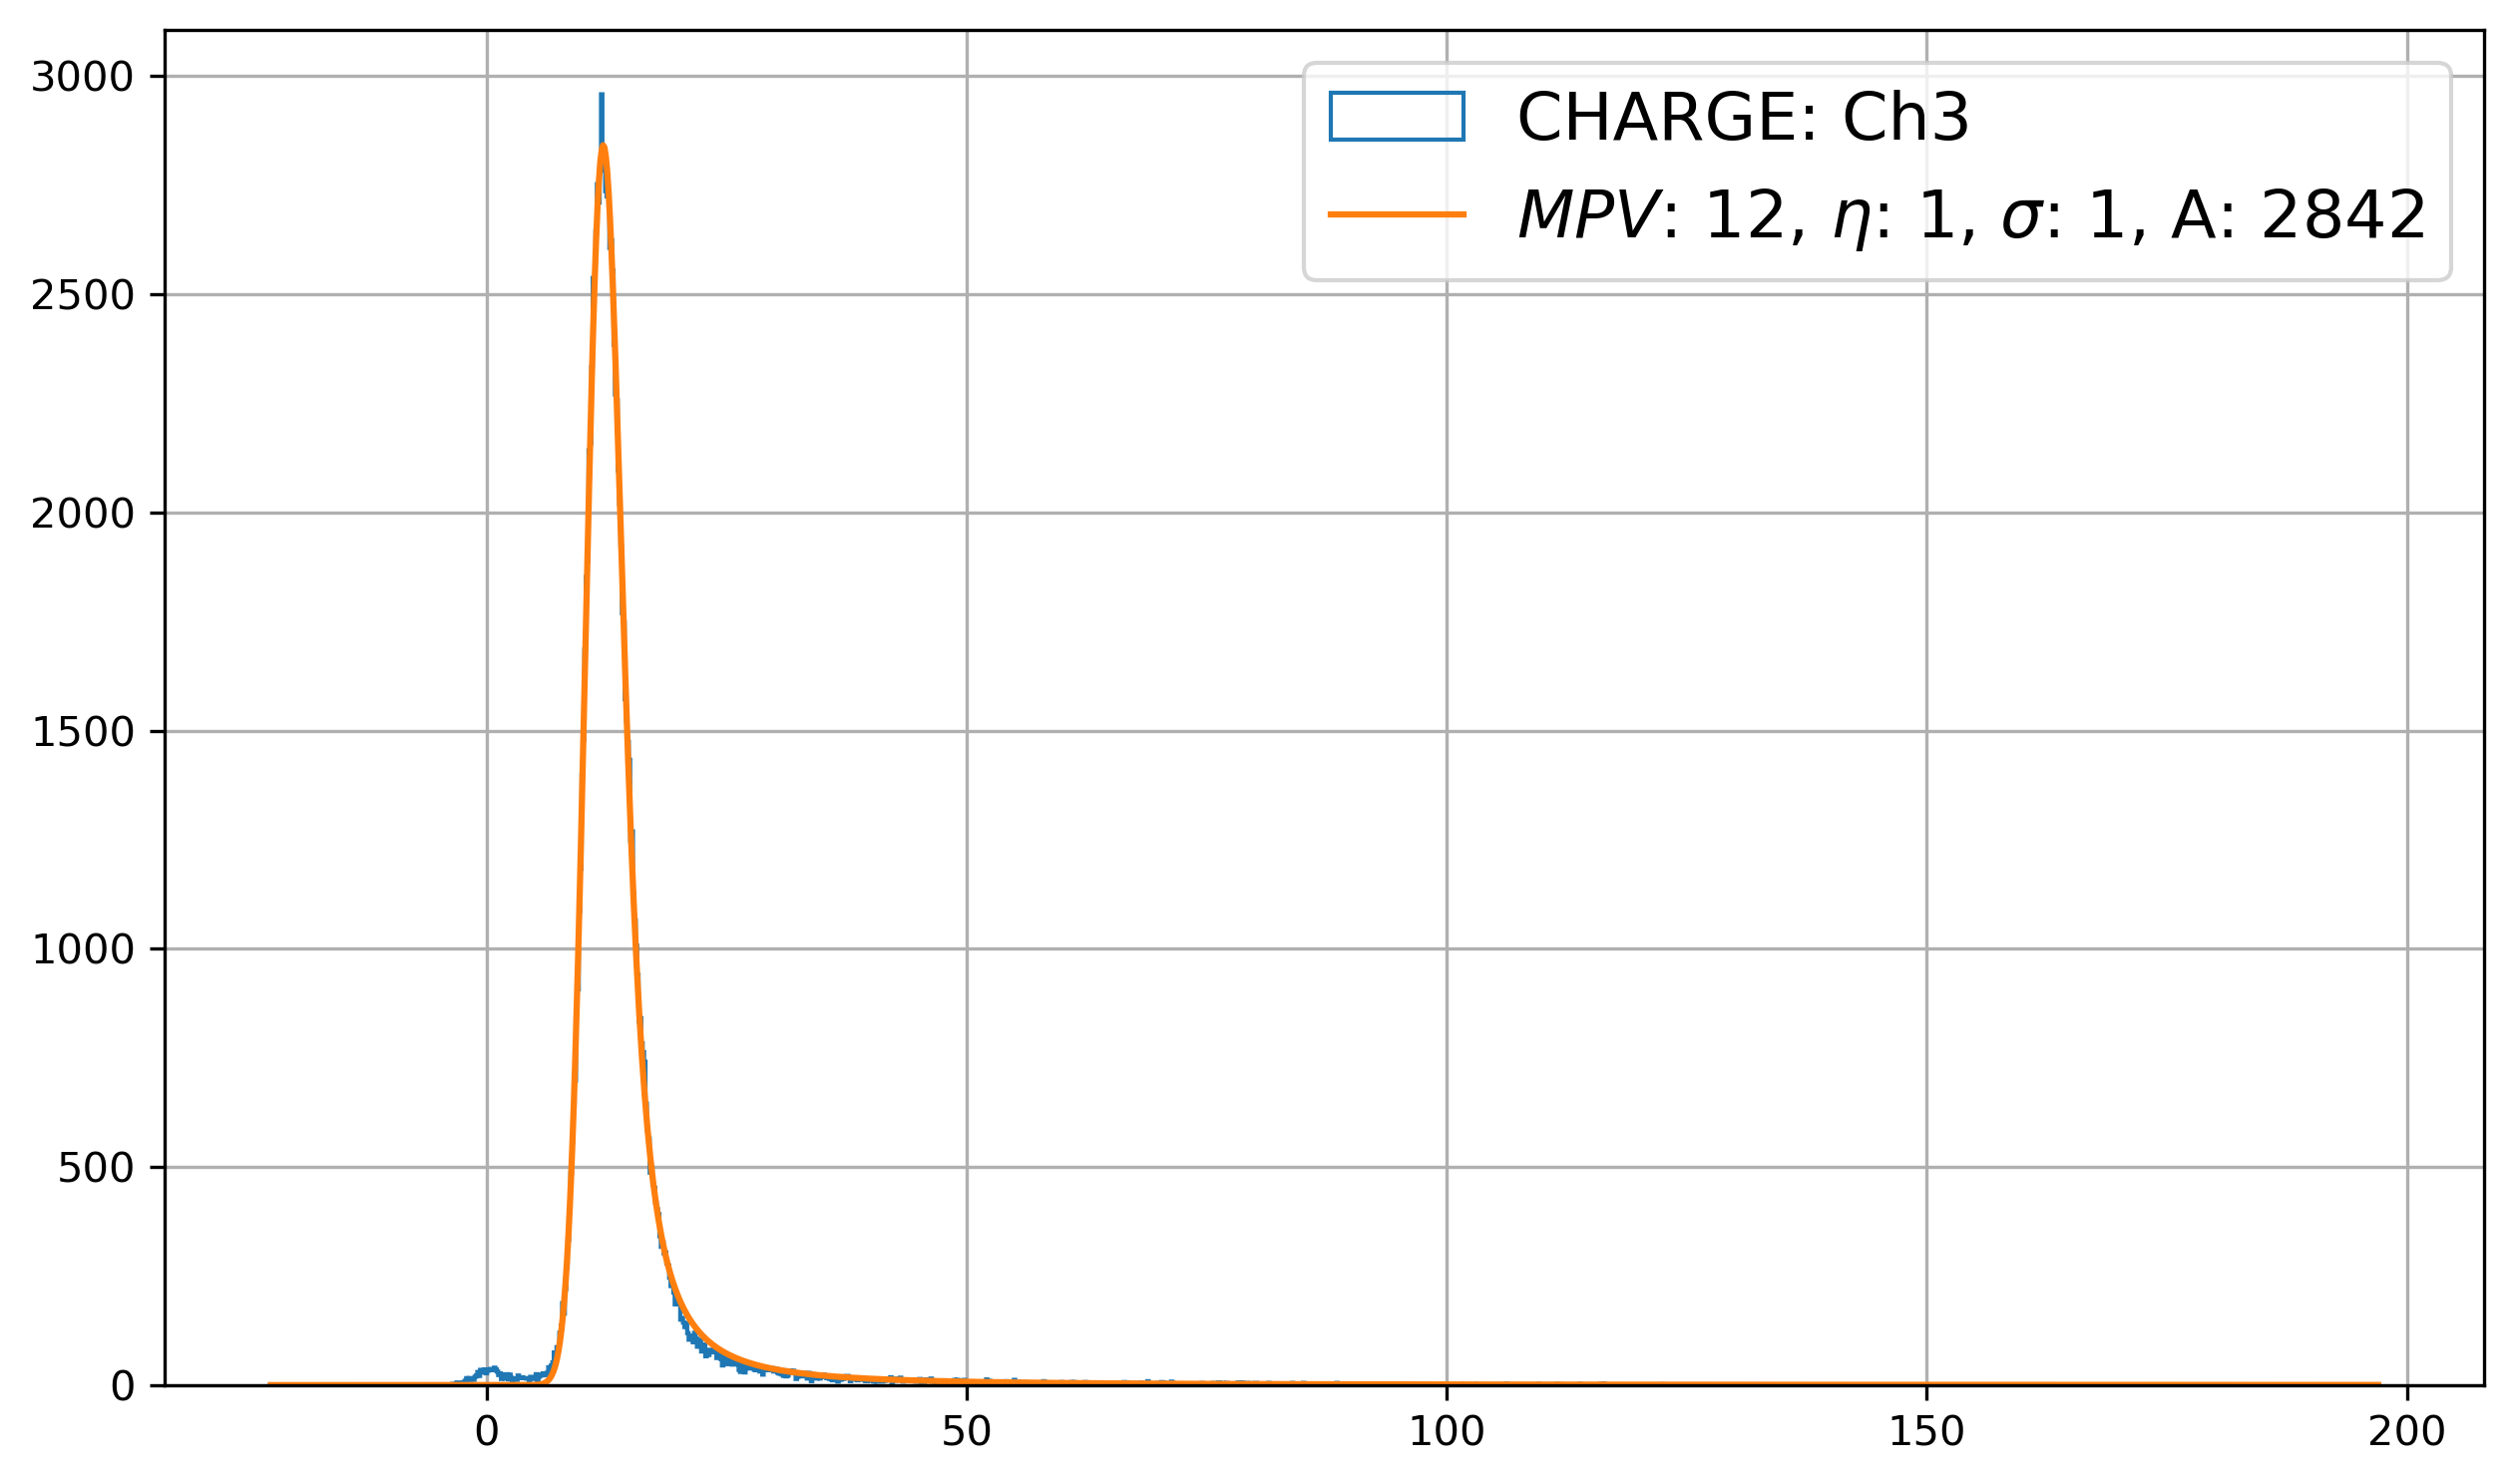

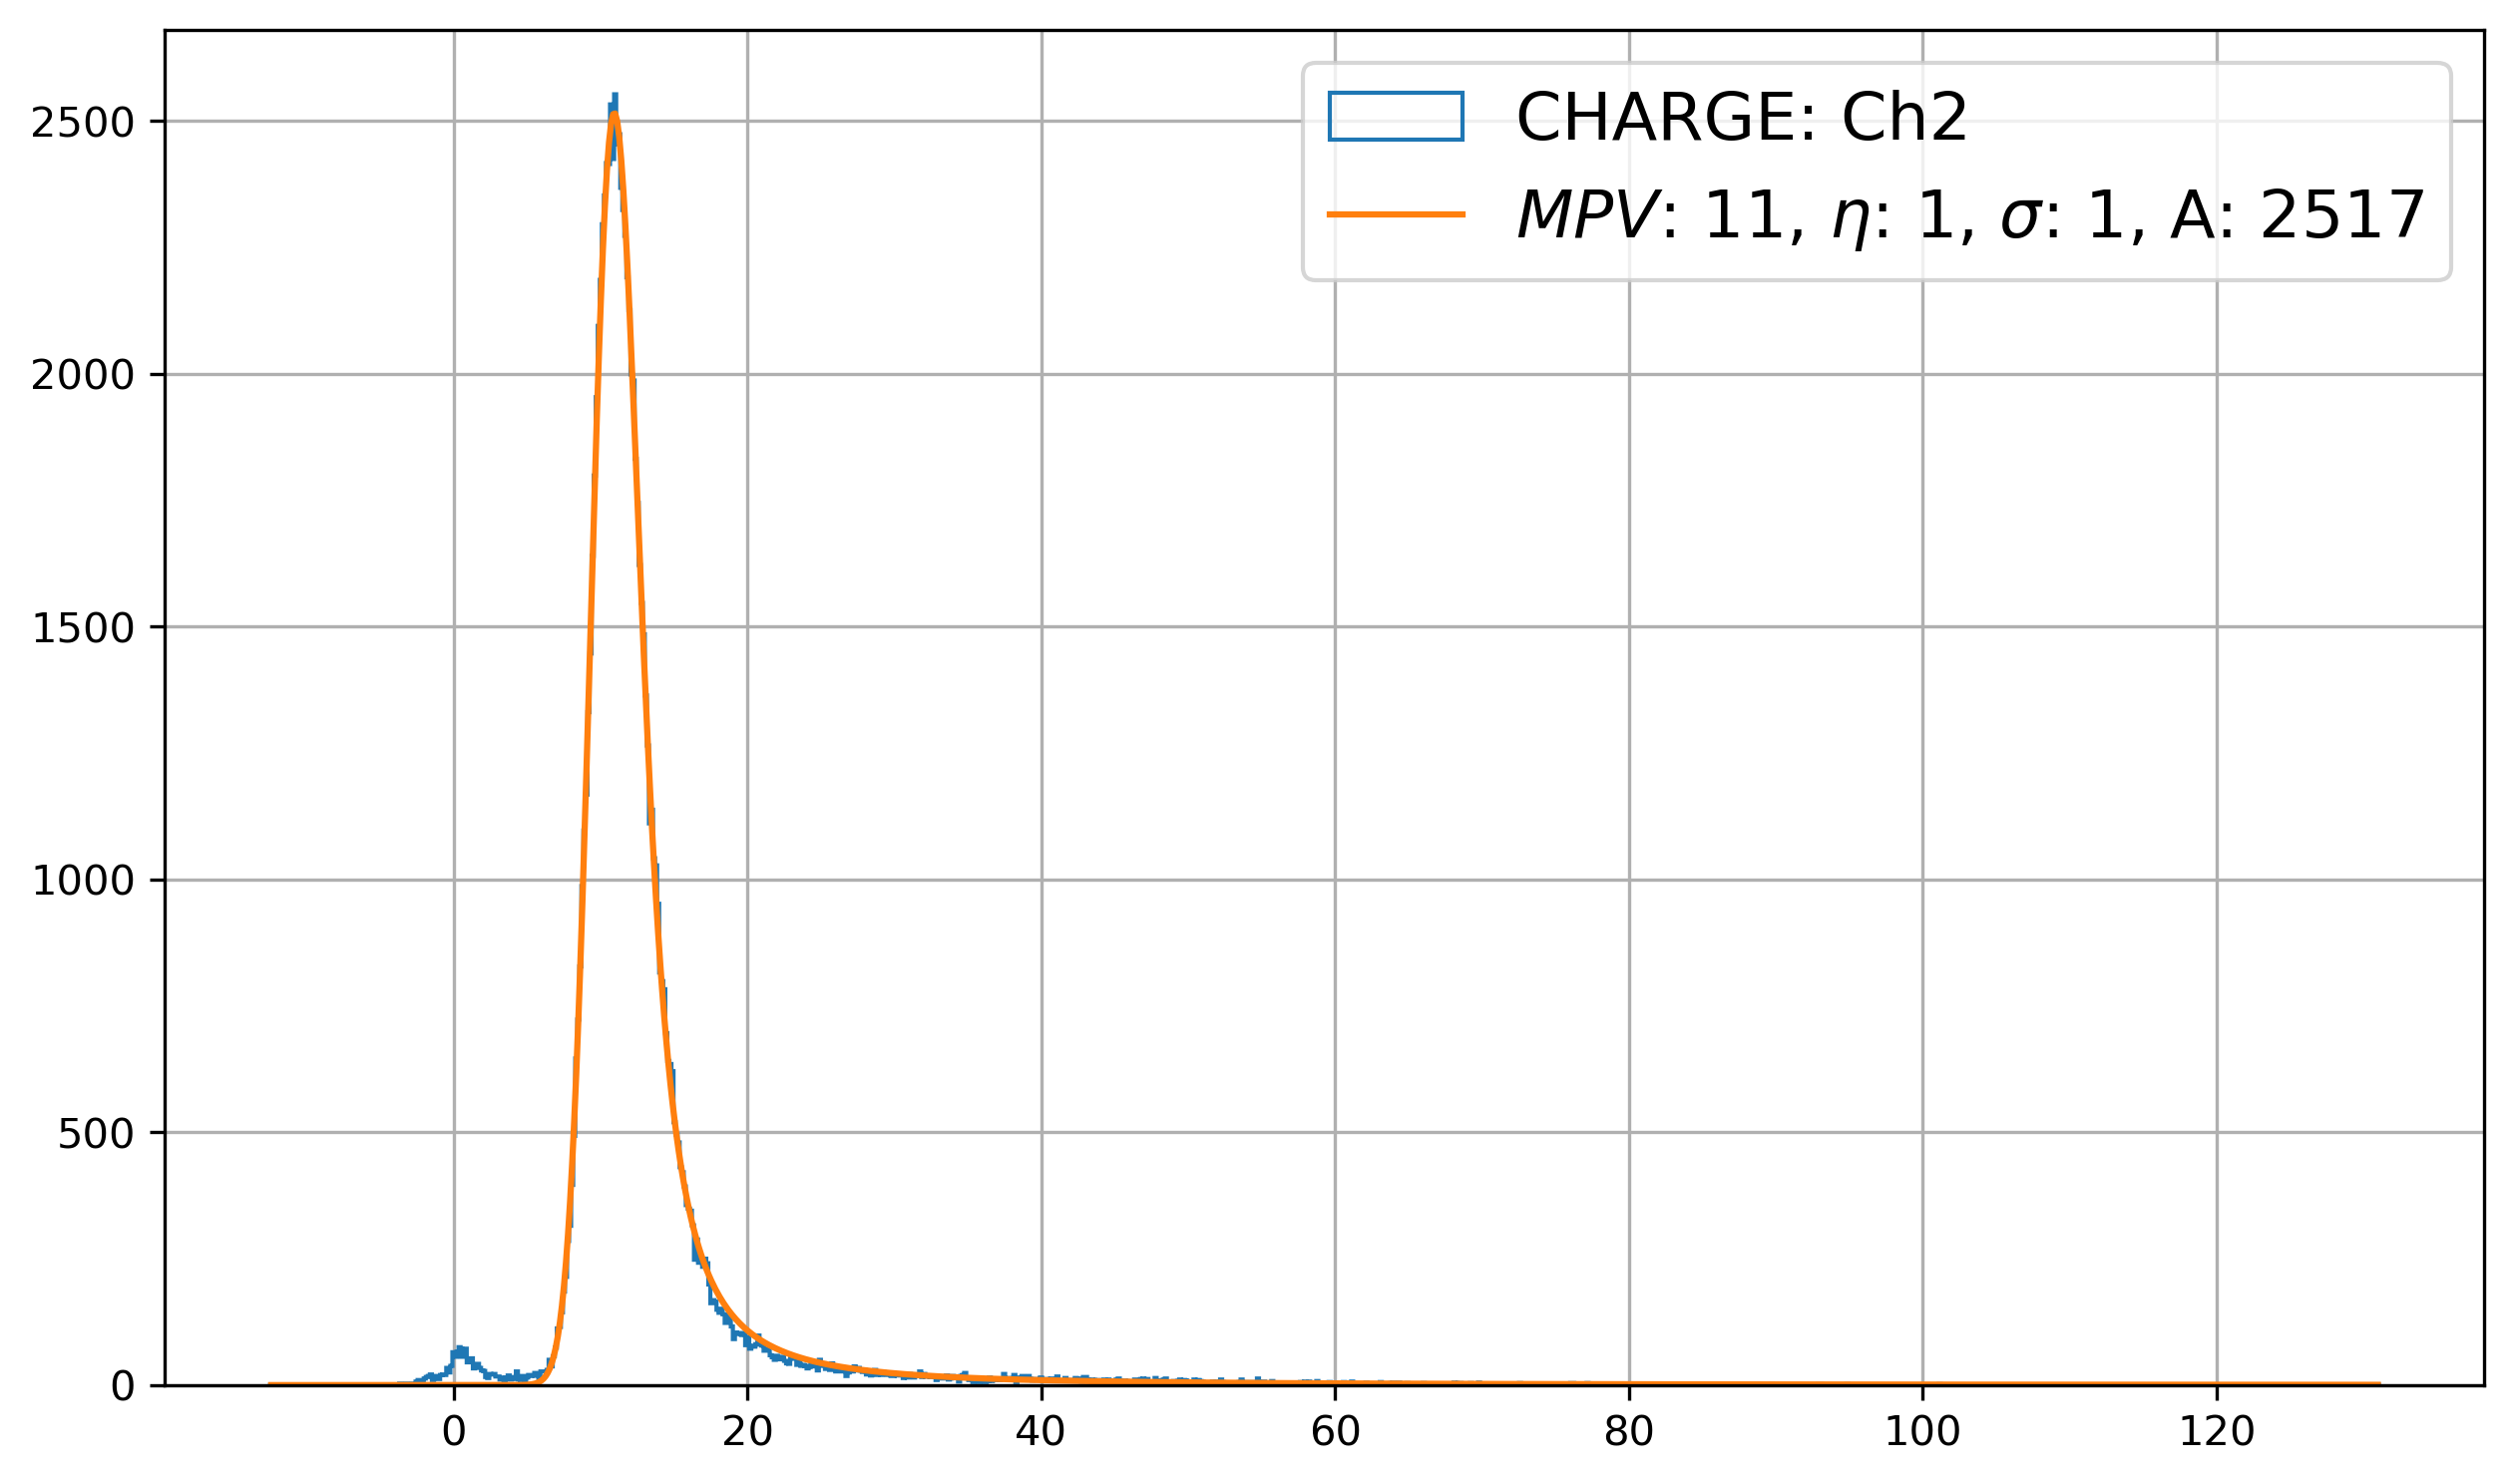

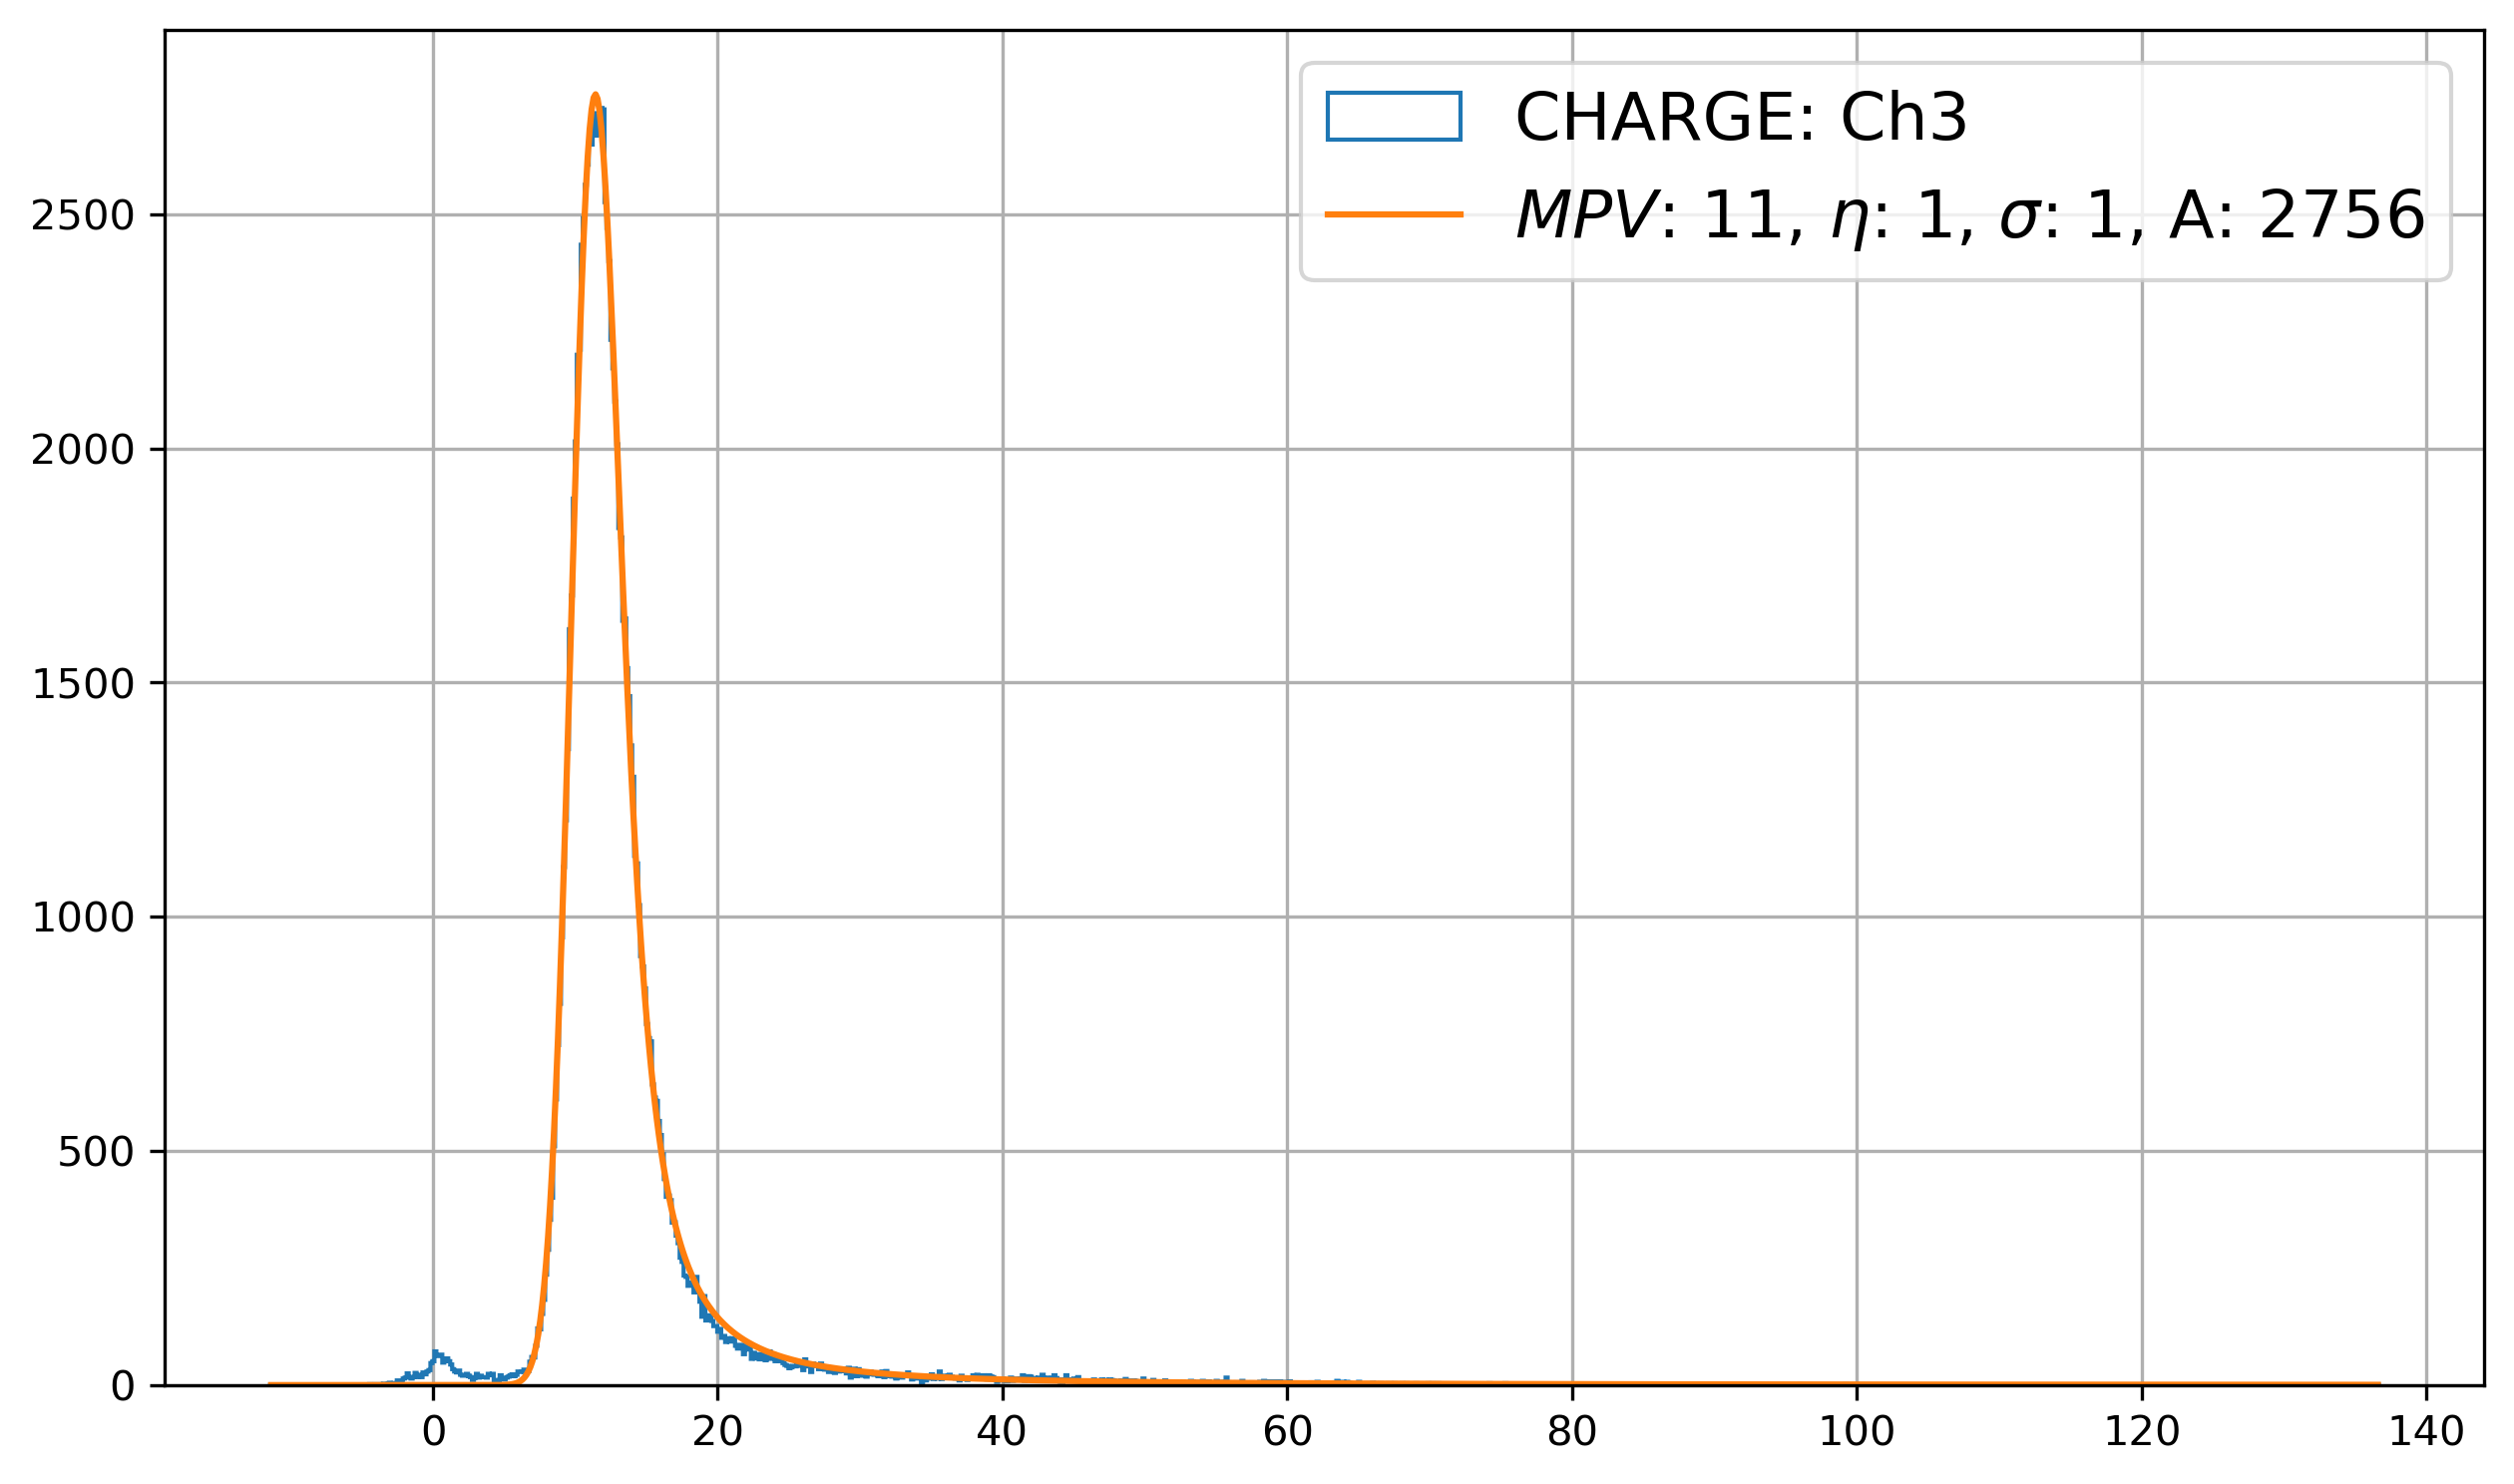

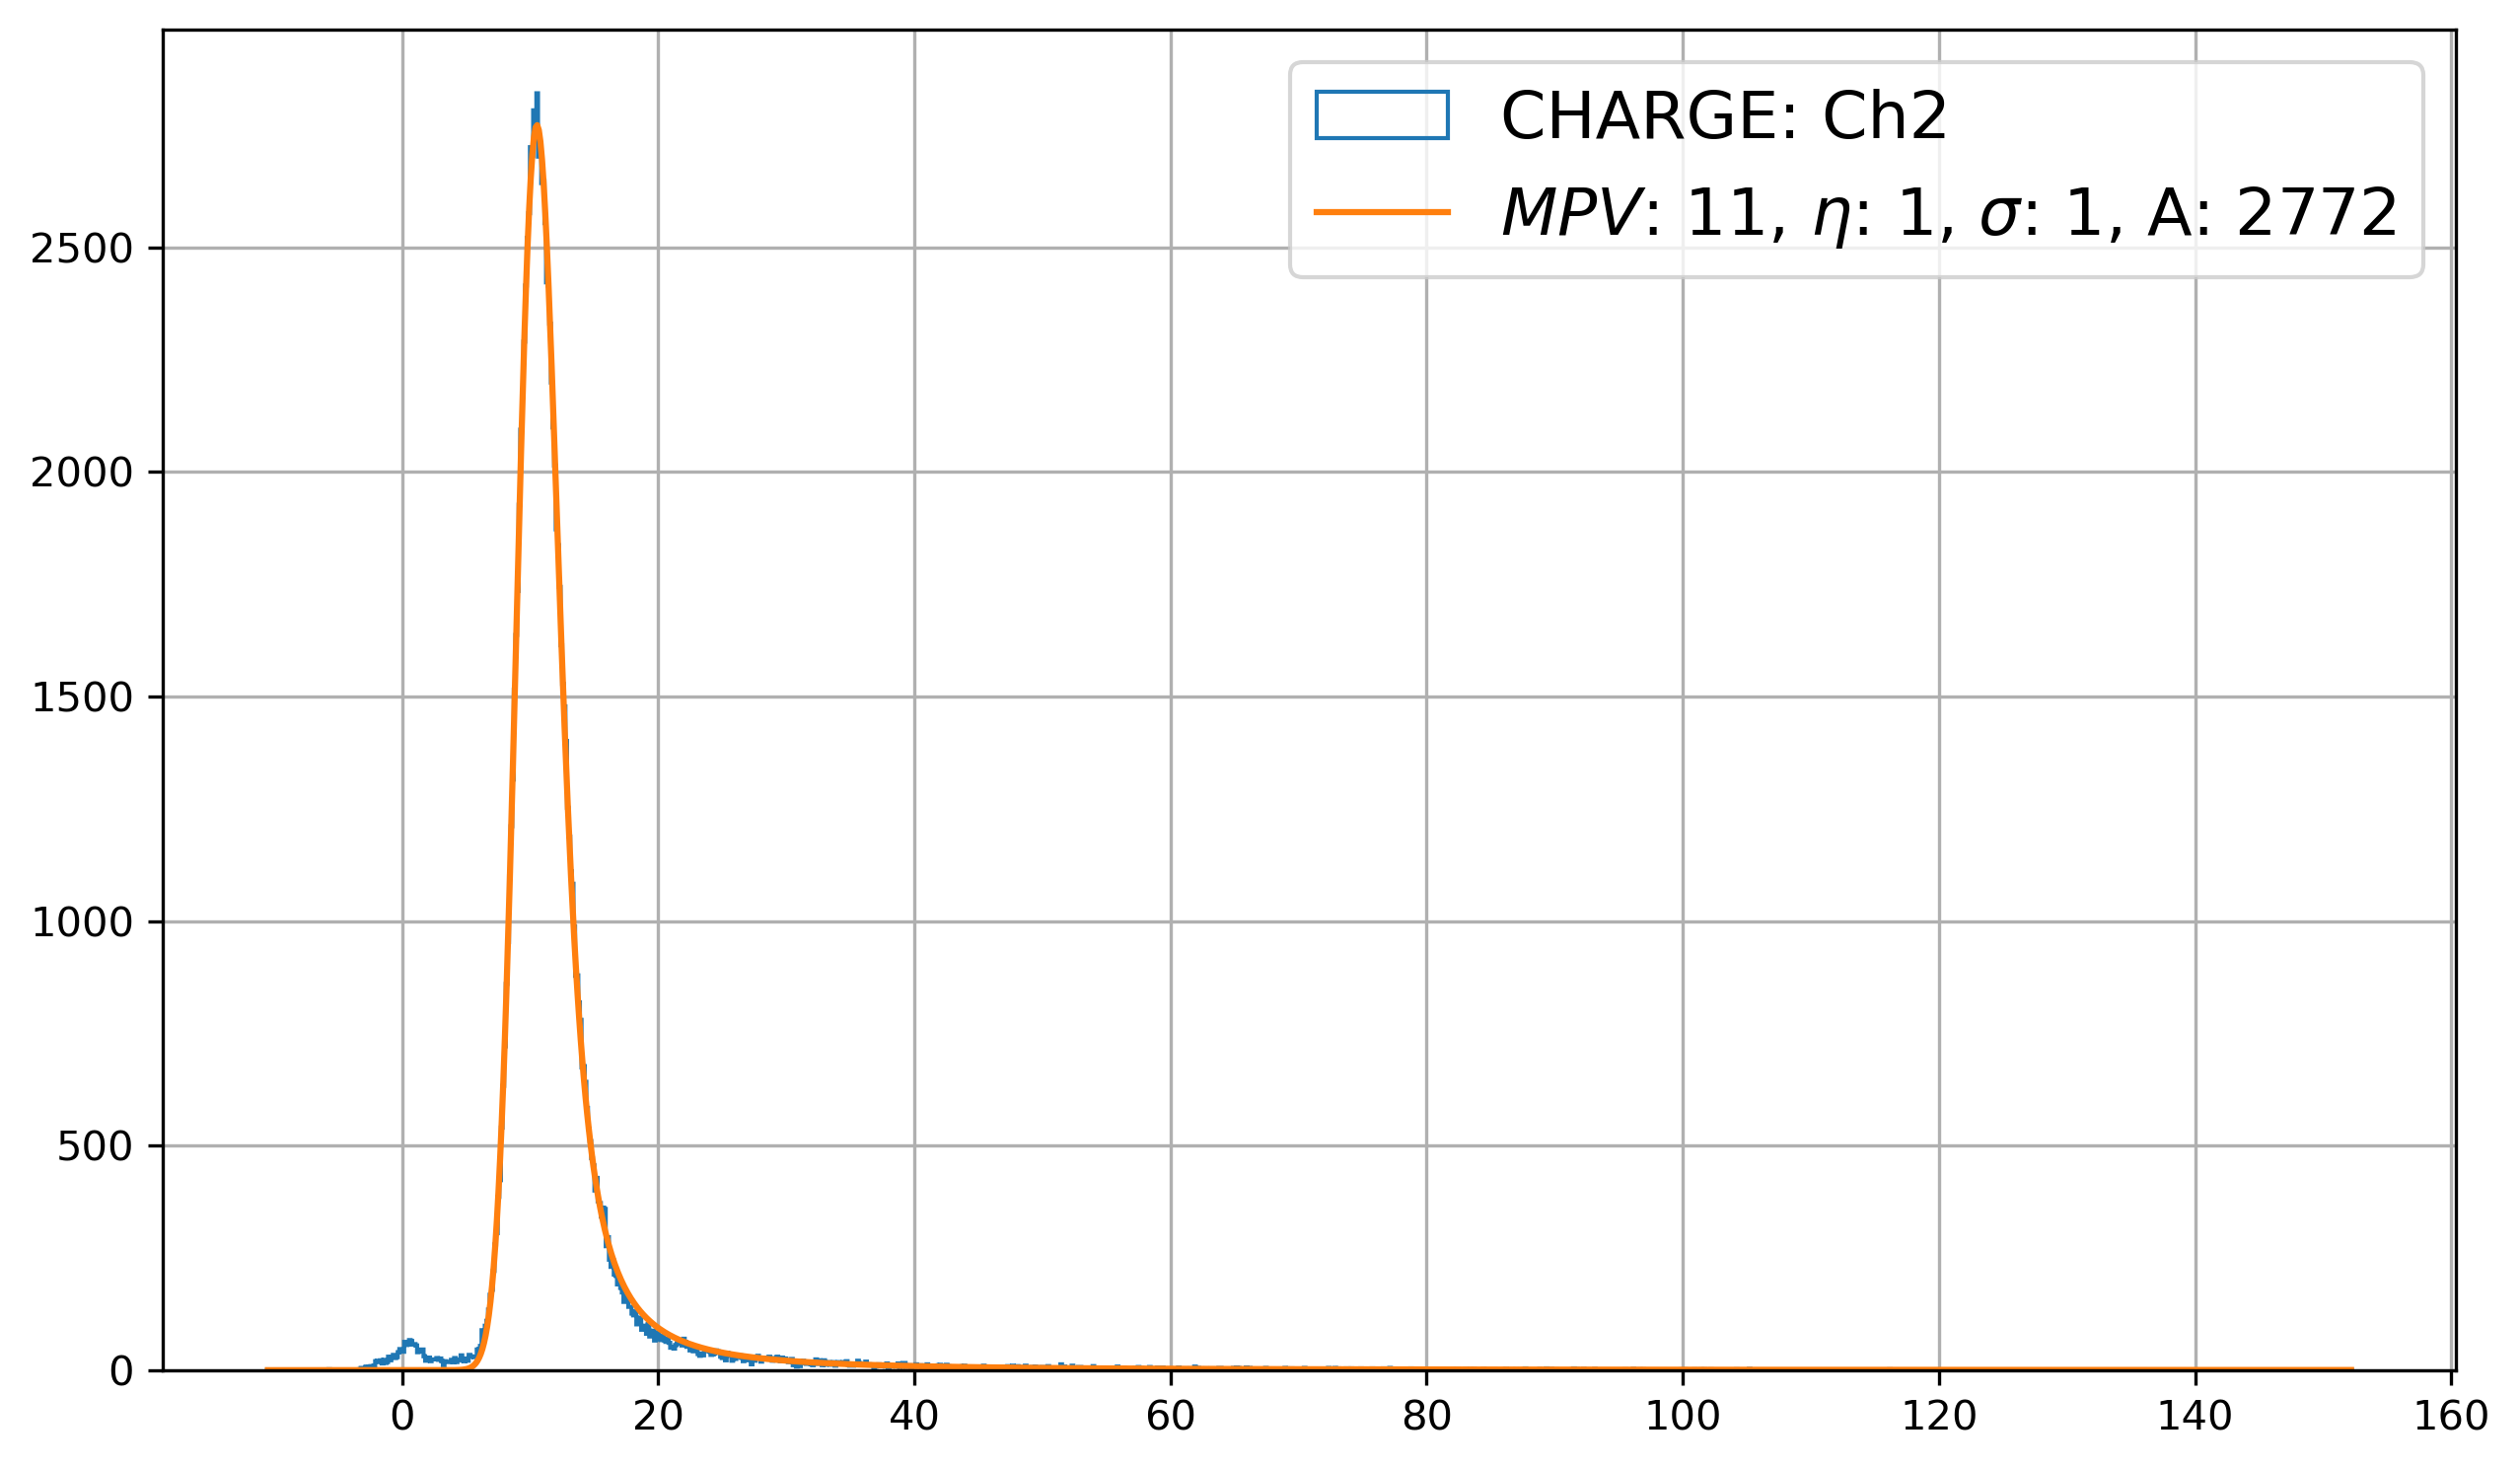

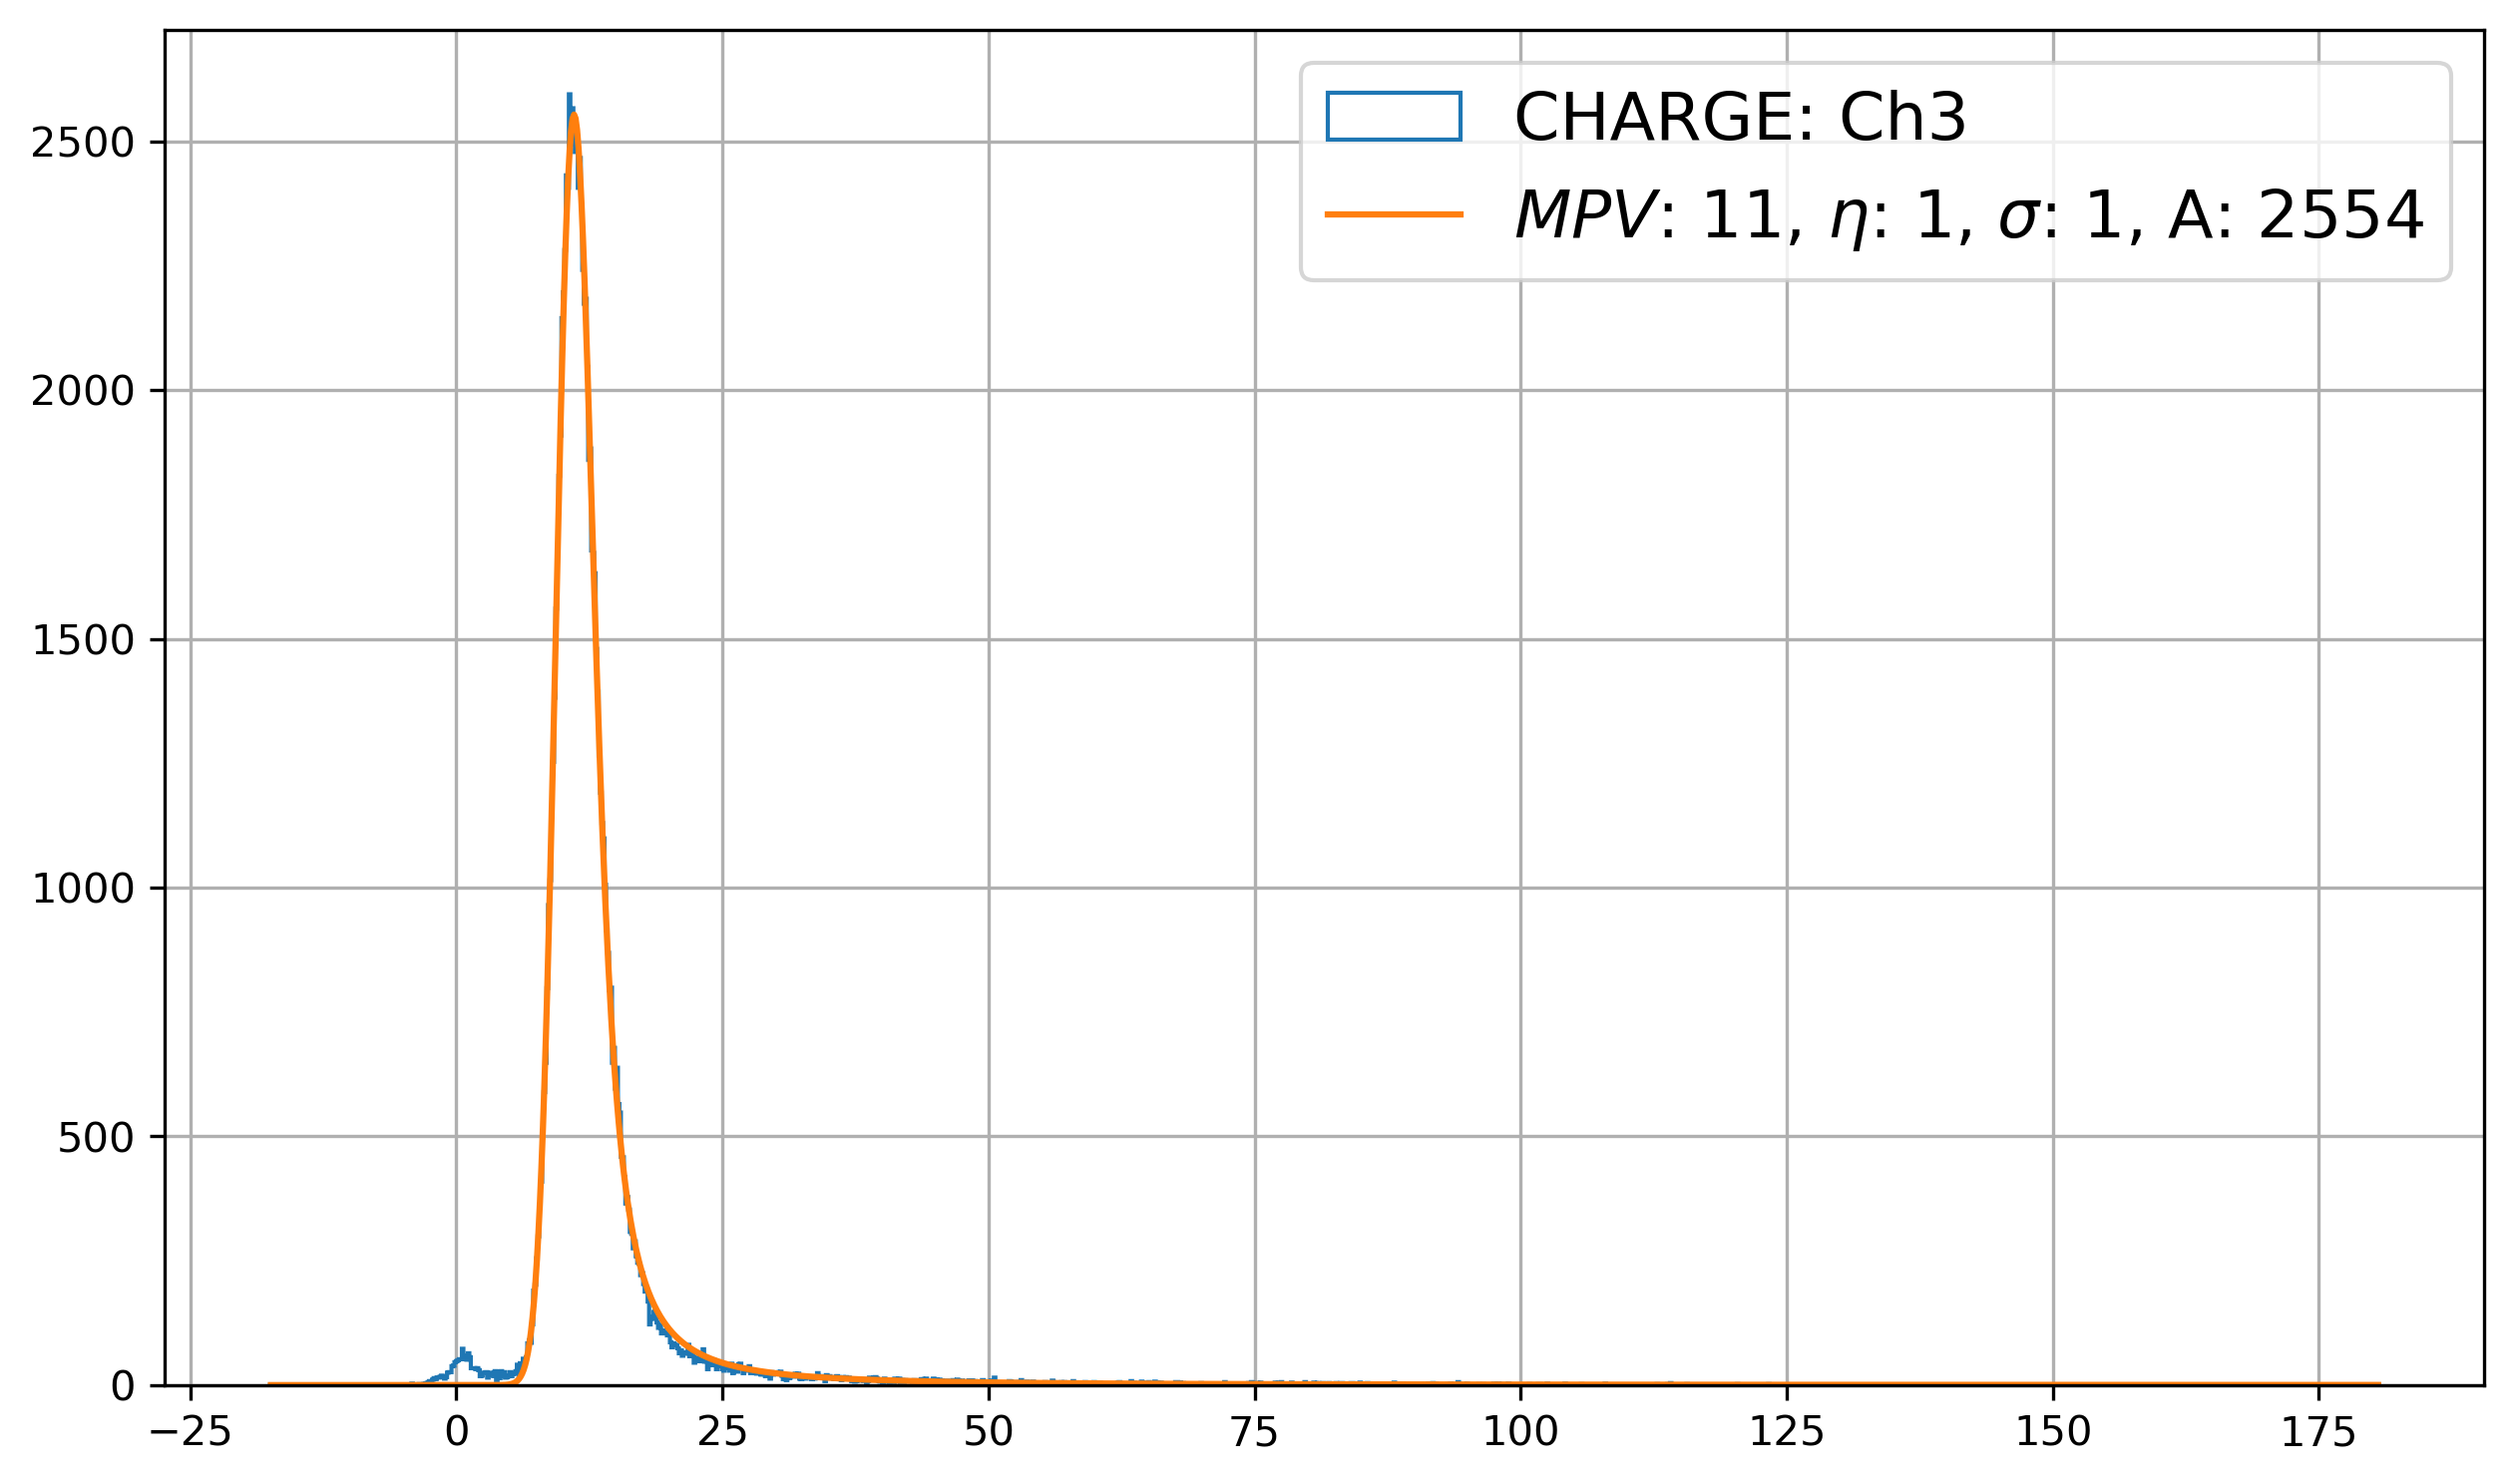

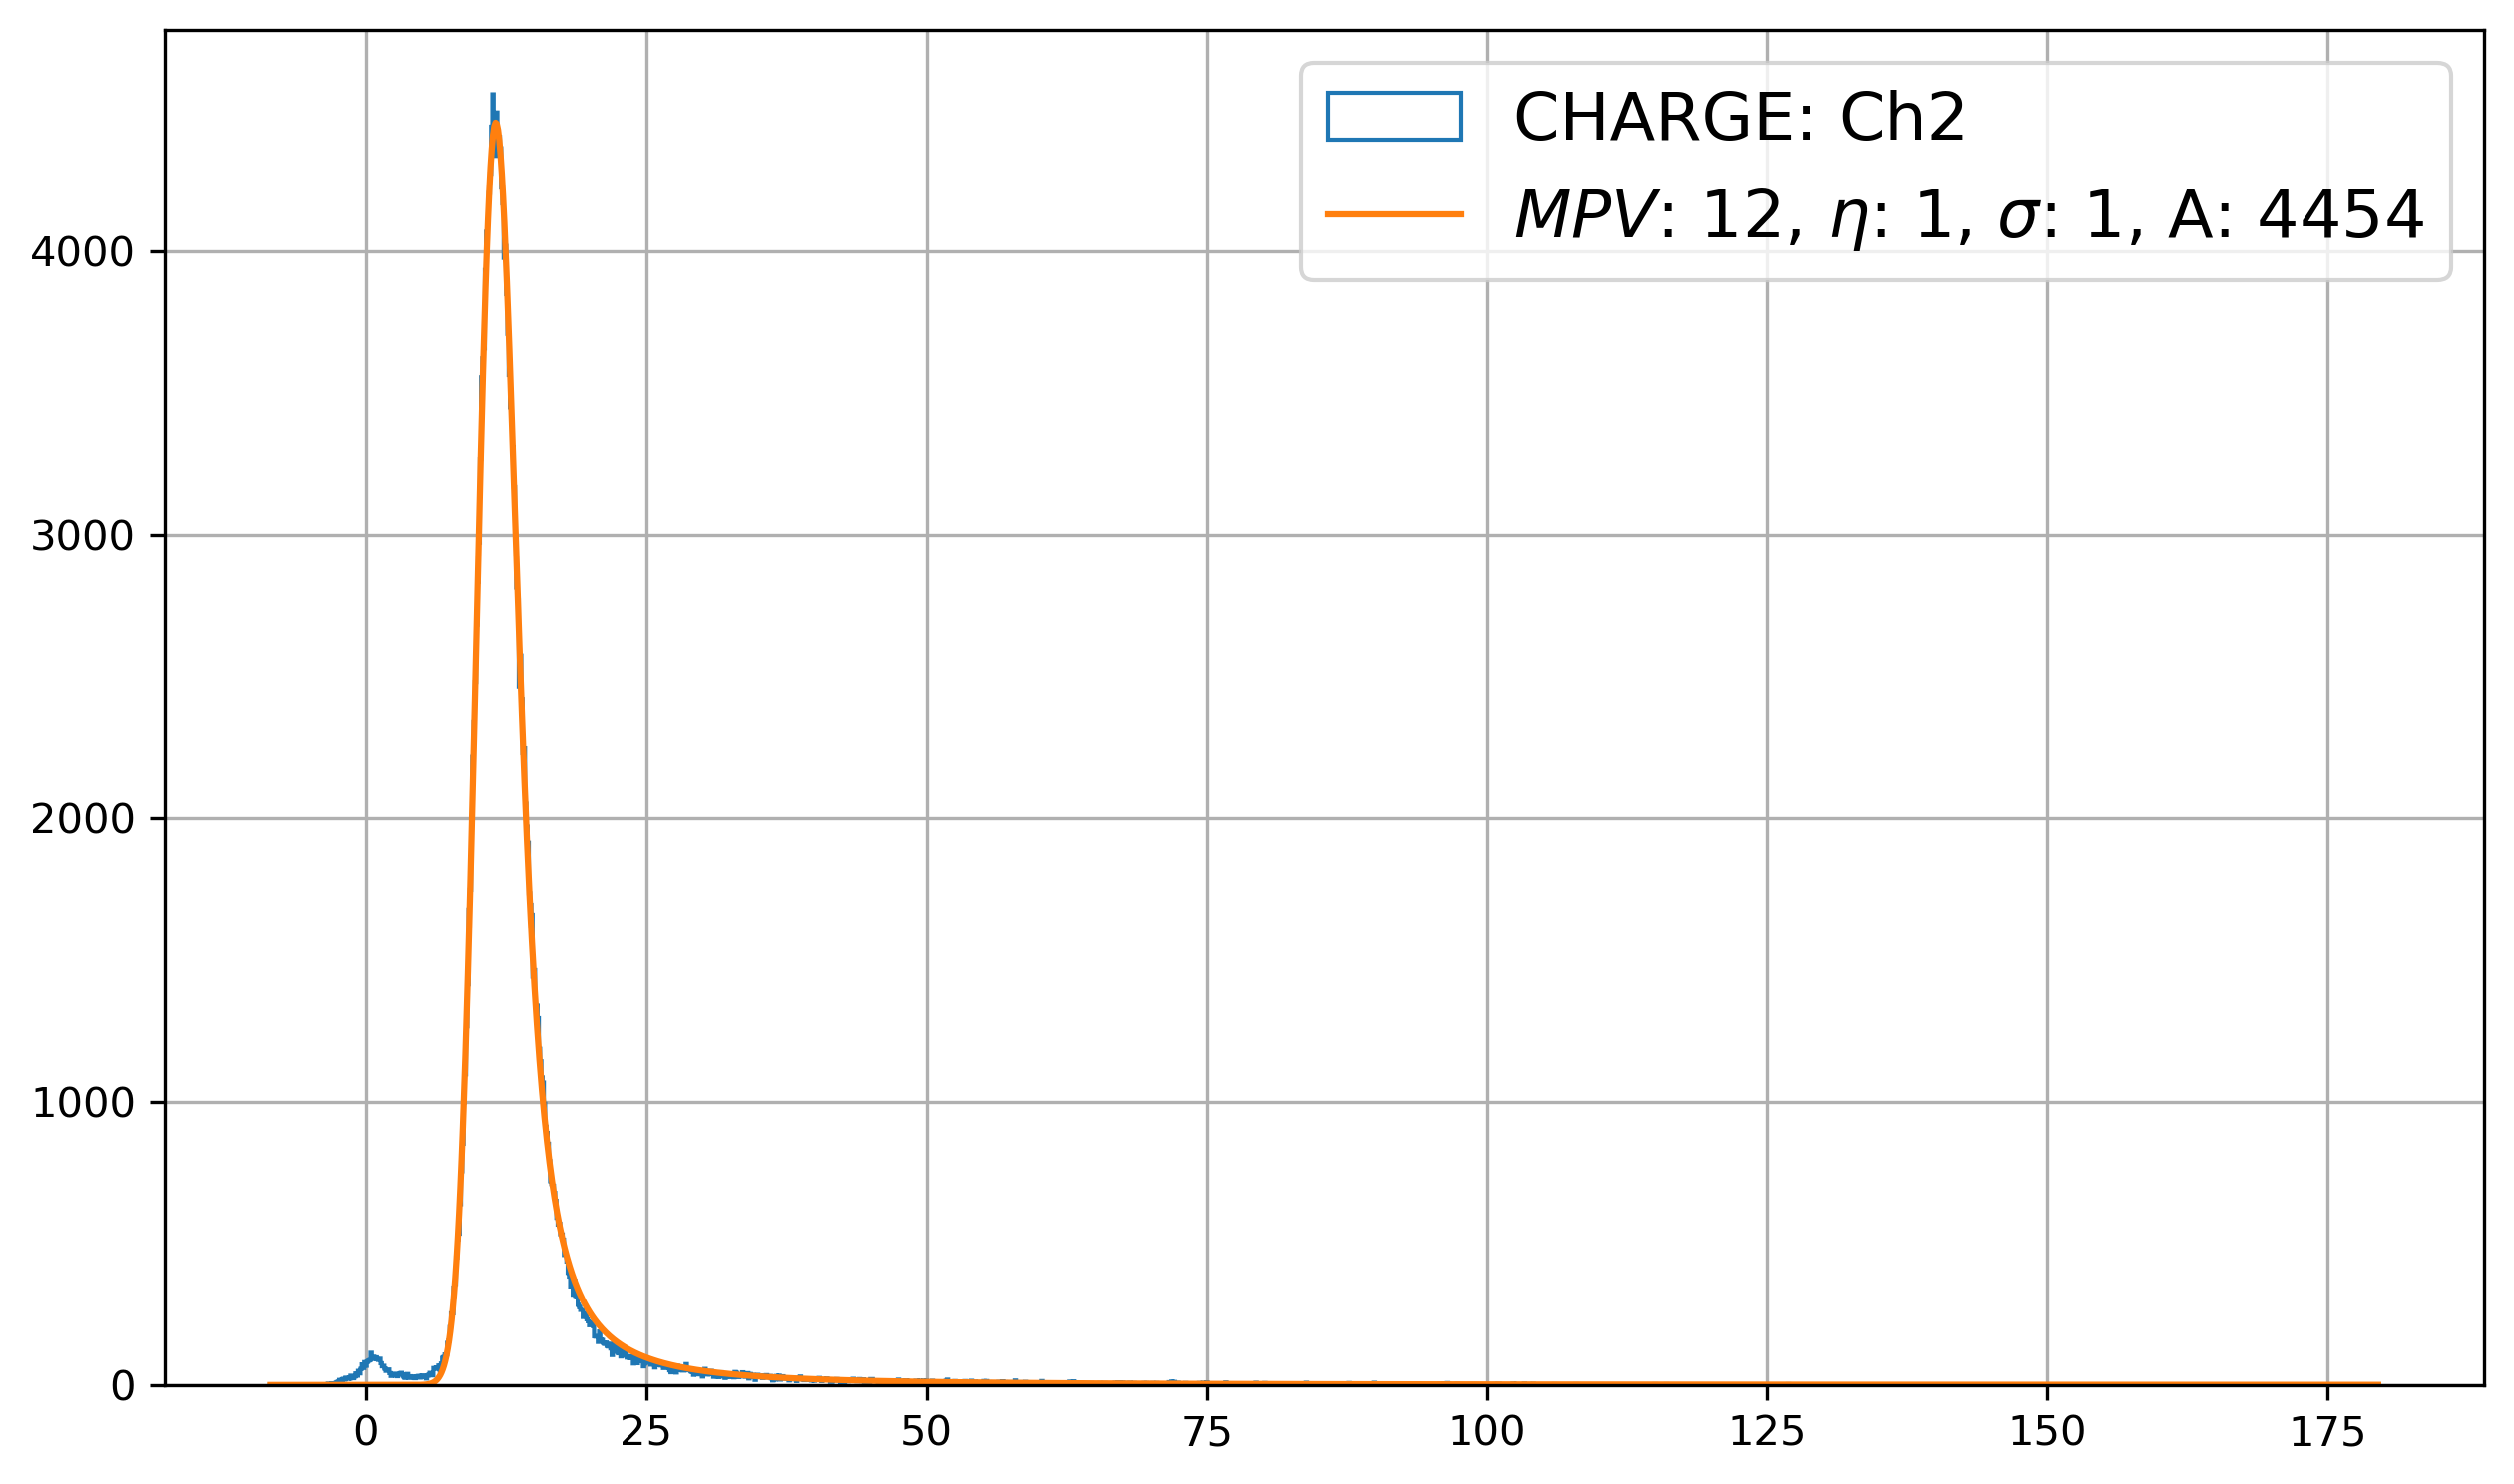

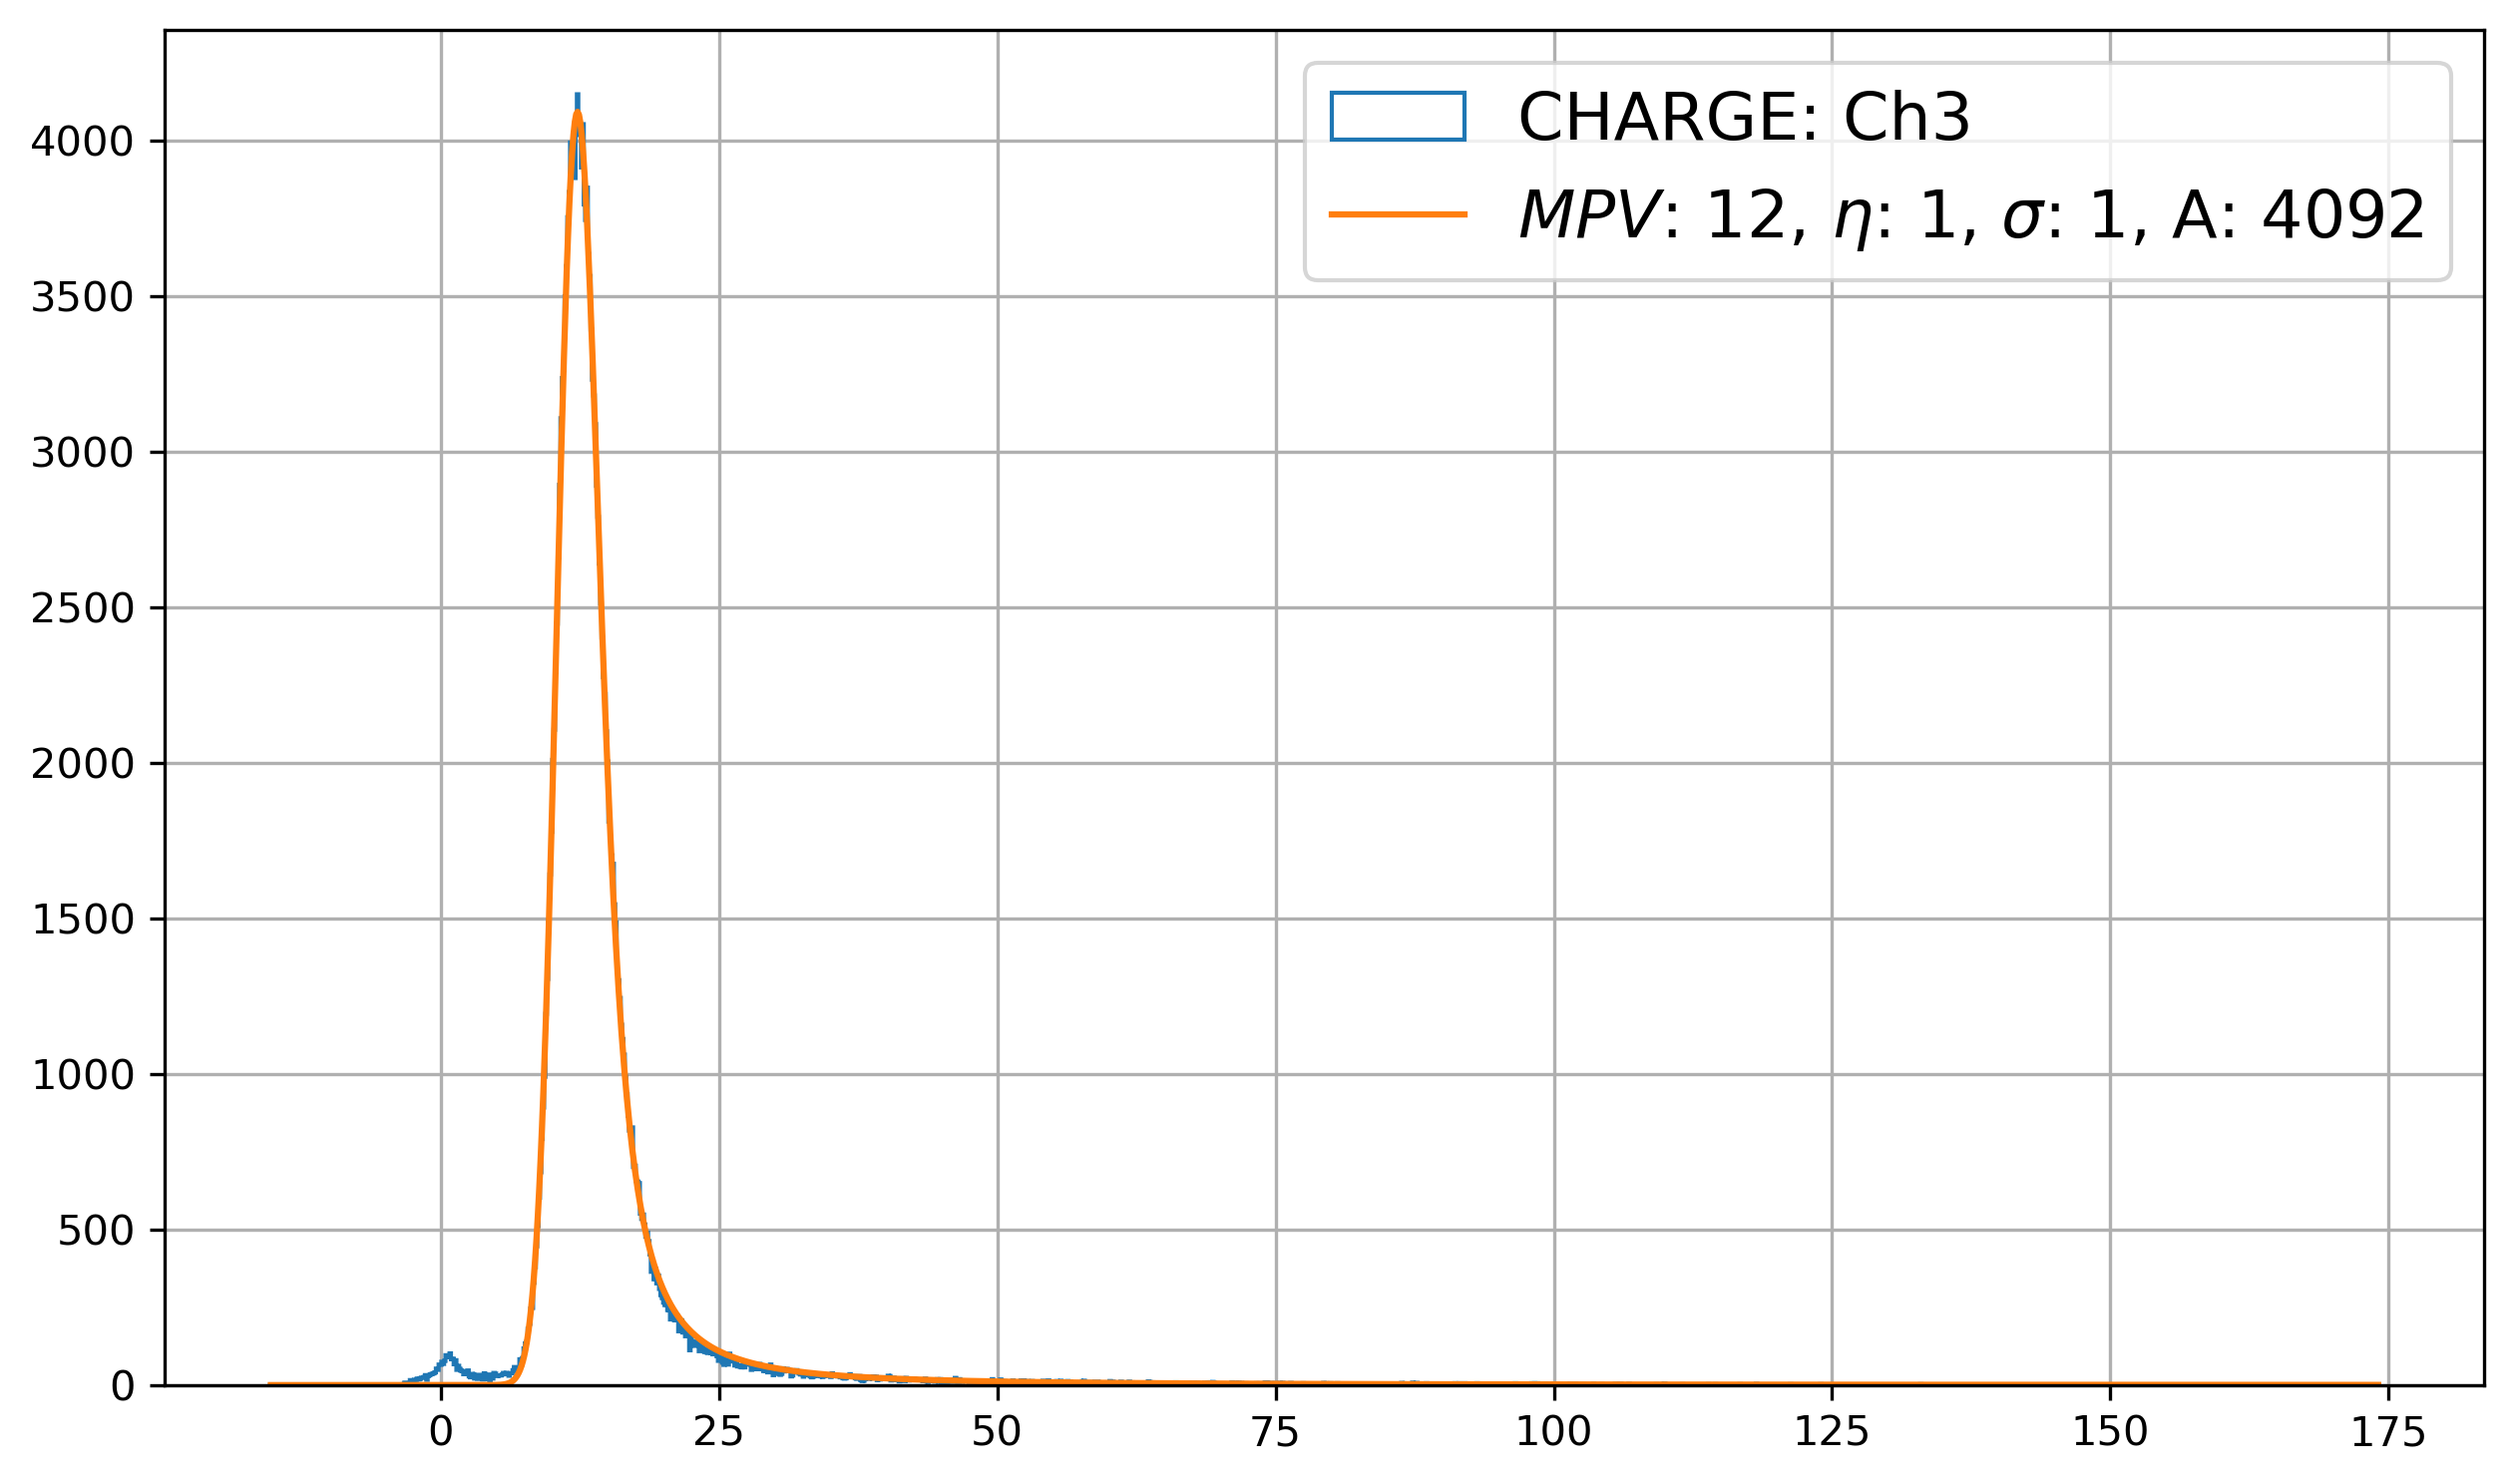

In [35]:
DUTs = (1,2)
# binning_method = 'rice'
threshold_charge = 4 #fC
charge = []
charge_error = []
voltage = []
angle = []
MCP = []

SAVE = True
save_path = f'../various plots/{this_sensor}/{key_to_study}/'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

for this_batch in df_analyis.index.levels[0]: ### batches
    for S in df_analyis.index.levels[1]:        ### scopes
        df = load_batch(this_batch,S)
        mins = [find_min_btw_peaks(df[f"pulseHeight_{i}"], bins='rice', plot=False) for i in DUTs]
        time_cut = [time_mask(df, i, bins=5000, plot=False)[0] for i in DUTs]
        geometry_cut = [geometry_mask(df, bins1, bins_find_min='rice',DUT_number=i)[0] for i in DUTs]
        pulseheight_cut = [df[f'pulseHeight_{i}']>mins[i-1] for i in DUTs]
        ### PLOTTING
        print(f"MCP: {dict_of_batches[this_batch].S[S].channels['Ch1'].voltage} V, angle: {dict_of_batches[this_batch].angle}°", f"temperature:{dict_of_batches[this_batch].tempA}°C")
#         plot(df, "2D_Sensors", dict_of_batches[this_batch], S, bins=bins1,
#              n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}', fmt='jpg')

#         plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, only_select='extended',
#                         bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC_extended')

#         plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, only_select='extended', mask=time_cut, zoom_to_sensor=True,
#                         bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC_extended_w_timecut')

#         plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=False,
#                         bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC', fmt='jpg')

#         plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, mask=time_cut, zoom_to_sensor=True,
#                         bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC_w_timecut', fmt='jpg')

        for ch in df_analyis.index.levels[2]:      ### channels
            ### EXTRACTING DATA
            match ch:
                case 'Ch1': dut=-1
                case 'Ch2': dut=1
                case 'Ch3': dut=2
                case 'Ch4': dut=3
                case other: logging.error("wrong channel name")
            print(f"Batch:{this_batch}, Scope:{S}, Channel:{ch}")
            transimpedance = dict_of_batches[this_batch].S[S].channels[ch].transimpedance
            param, covar = charge_fit(df, dut=dut, mask=np.logical_and(time_cut[dut-1],geometry_cut[dut-1]), transimpedance=transimpedance, plot=True)
            charge.append(param[0])
            charge_error.append(covar[0,0]**0.5) ### variance to error
            voltage.append(dict_of_batches[this_batch].S[S].channels[ch].voltage)
            angle.append(dict_of_batches[this_batch].angle)
            MCP.append(dict_of_batches[this_batch].S[S].channels['Ch1'].voltage)

In [36]:
df_analyis['charge'] = charge
df_analyis['voltage'] = voltage
df_analyis['charge_error'] = charge_error
df_analyis['angle'] = angle
df_analyis['MCP'] = MCP

idx=pd.IndexSlice

### select one value from the index channel
df_analyis.loc[idx[:,:,'Ch2'],['charge']] ### DATAFRAME  
df_analyis.loc[idx[:,:,'Ch2']]['charge']  ### SERIES
display(df_analyis)

dict_analysis[key_to_study] = df_analyis.copy()

charge  voltage  charge_error  angle   MCP
batch oscilloscope channel                                               
411   S1           Ch2       0.092230     -105      0.001434   13.0  2500
                   Ch3       0.123992     -105      0.009692   13.0  2500
413   S1           Ch2      12.295413     -105      0.007595    6.0  2800
                   Ch3      13.017173     -105      0.004744    6.0  2800
414   S1           Ch2      11.530470     -100      0.003041    6.0  2800
                   Ch3      12.159025     -100      0.002541    6.0  2800
403   S1           Ch2      10.941295     -100      0.002853    0.0  2500
                   Ch3      11.409726     -100      0.002981    0.0  2500
406   S1           Ch2      10.523937     -100      0.002251    0.0  2500
                   Ch3      11.068591     -100      0.002705    0.0  2500
407   S1           Ch2      11.581971     -105      0.002217    0.0  2500
                   Ch3      12.287389     -105      0.002374    0.0  2500

In [ ]:
# dict_of_batches[414].S['S1'].channels['Ch1'].voltage
# df_2500 = df_analyis.loc[df_analyis['MCP']==2500]

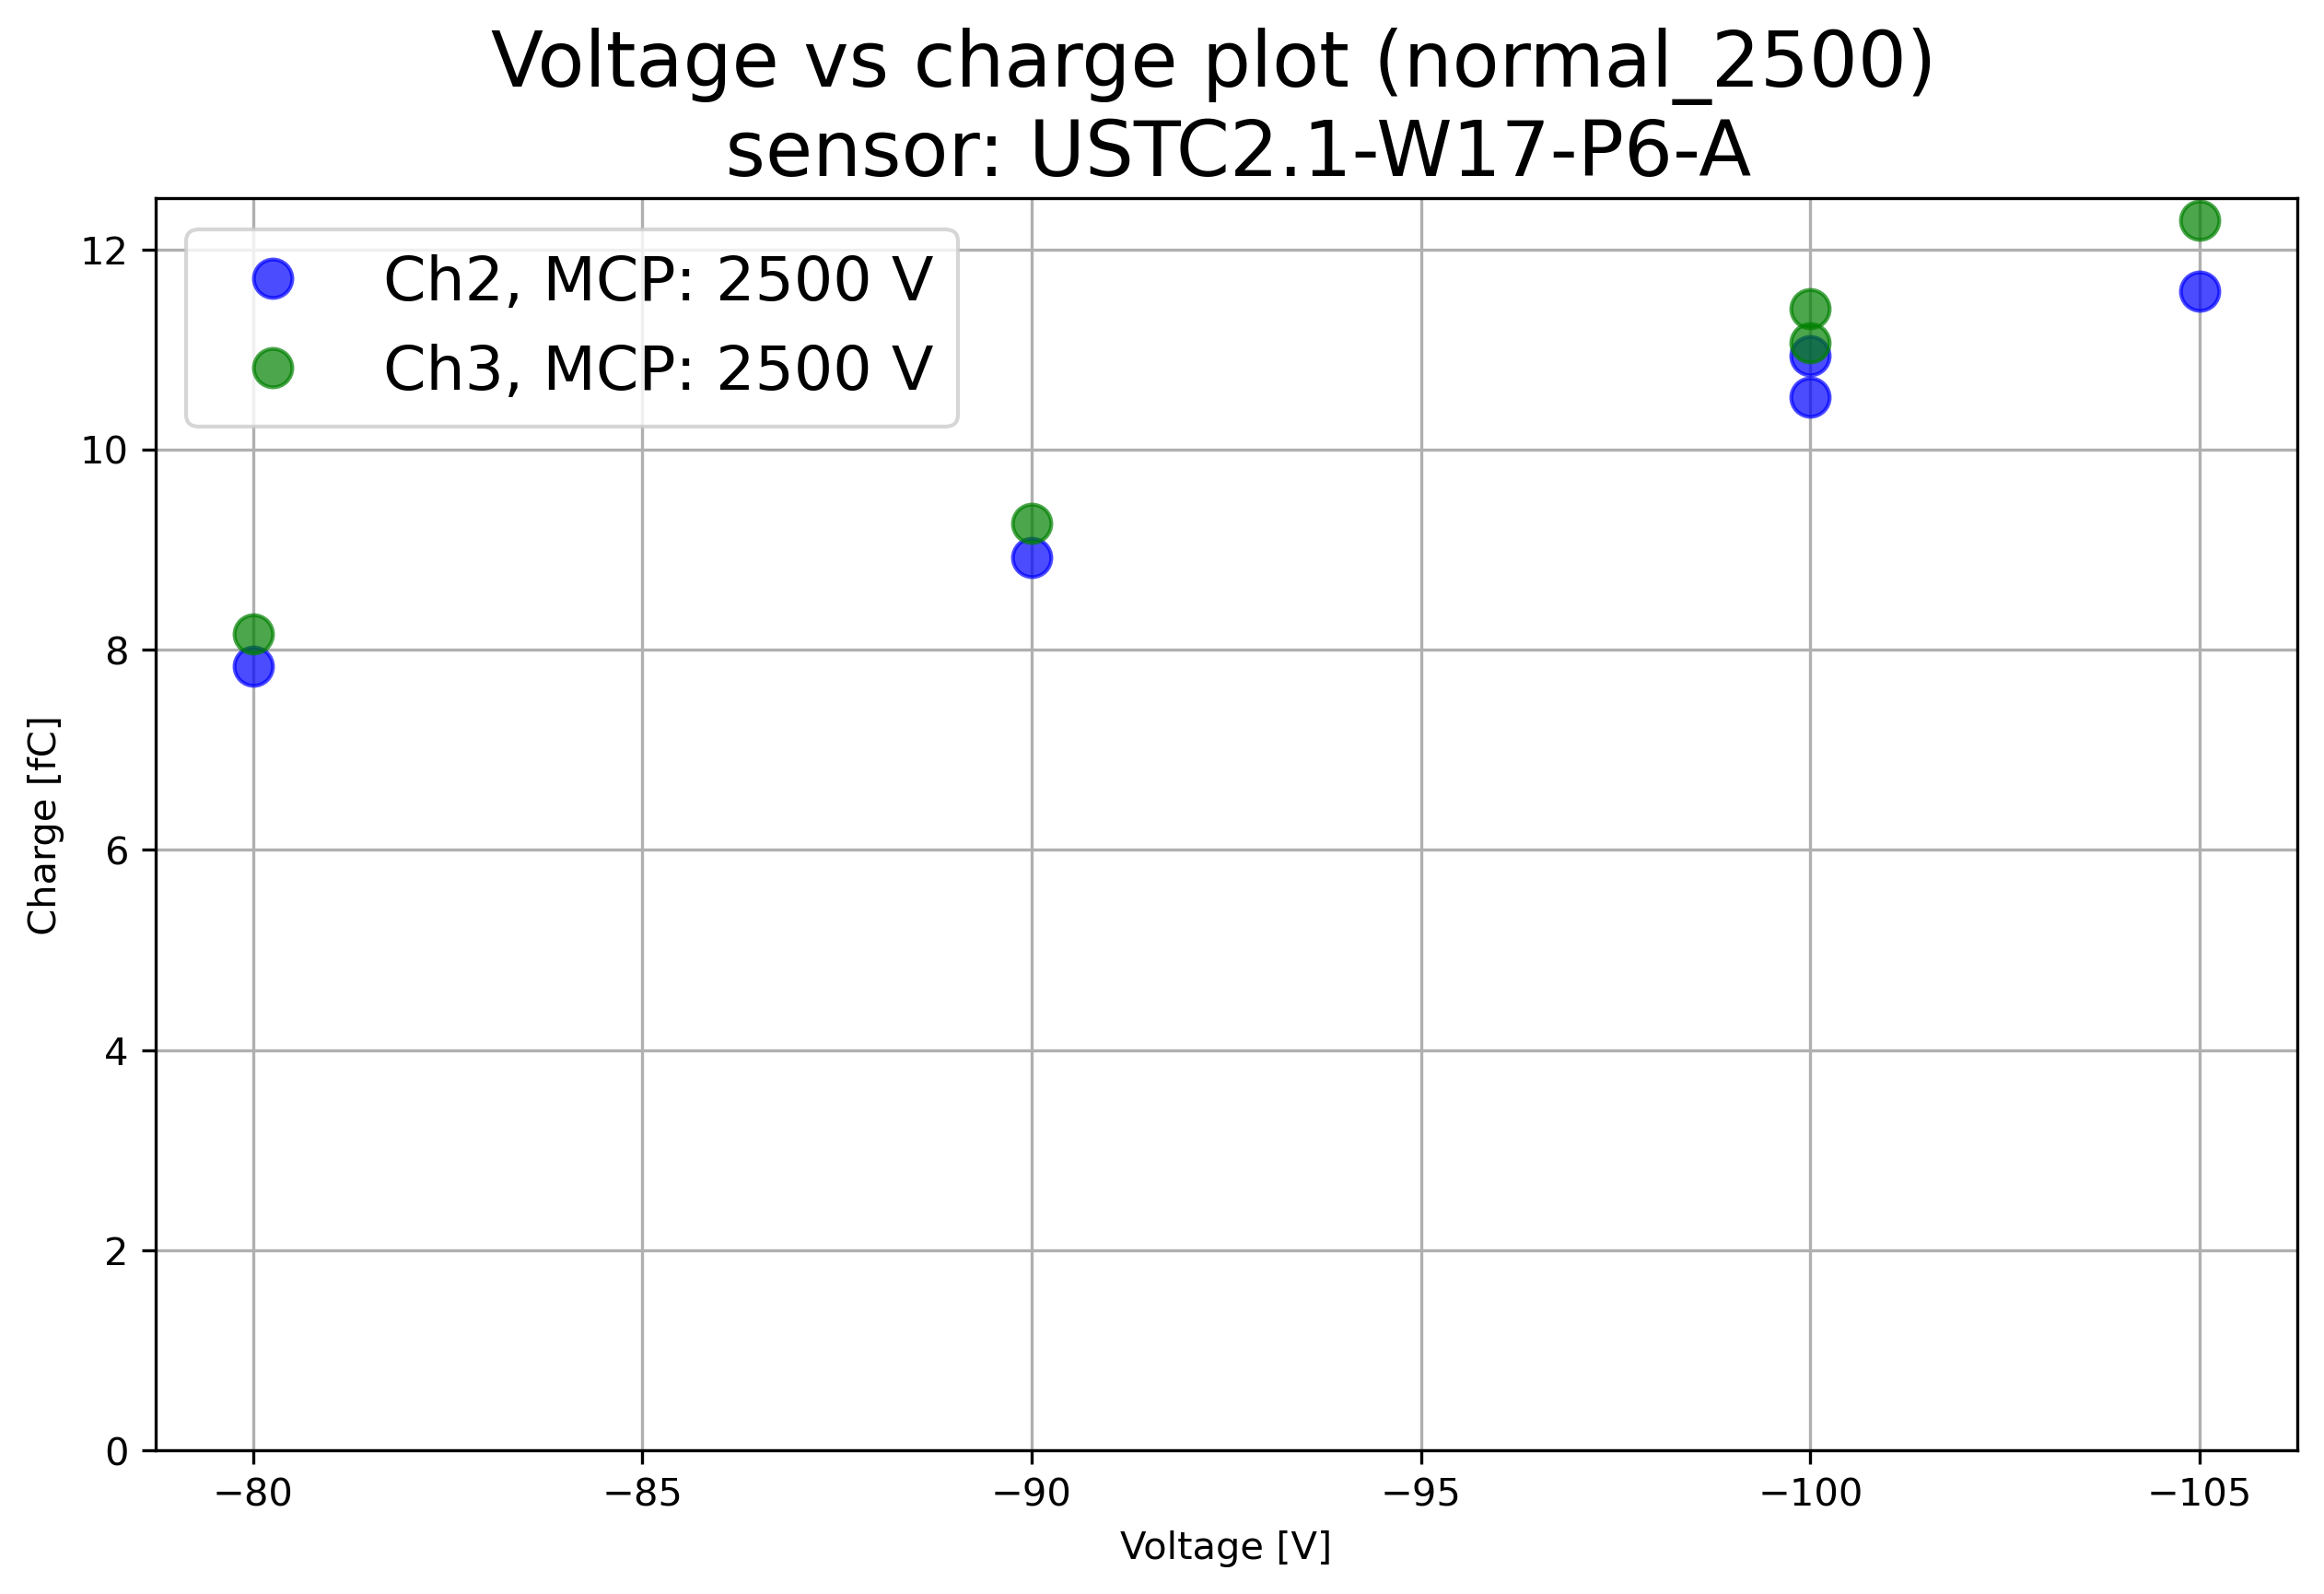

In [30]:
### no errorbar
df_2500 = df_analyis.loc[df_analyis['MCP']==2500]
# df_2600 = df_analyis.loc[df_analyis['MCP']==2600]
# df_2800 = df_analyis.loc[df_analyis['MCP']==2800]

markers = ('o','v','^','<','>','P','D','X')
colormap = ['k','b','g','r','orange']

fig, ax = plt.subplots(figsize=(10,6), dpi=300)
for i, ch in enumerate(['Ch2','Ch3']):
    ax.plot(np.array(df_2500.loc[idx[:,:,ch]]['voltage']),np.array(df_2500.loc[idx[:,:,ch]]['charge']),
            marker='o', markersize=10, linewidth=0, alpha=0.7, color=colormap[i+1],
            label=f"{ch}, MCP: 2500 V")
#     ax.plot(np.array(df_2800.loc[idx[:,:,ch]]['voltage']),np.array(df_2800.loc[idx[:,:,ch]]['charge']),
#             marker='D', markersize=10, linewidth=0, alpha=0.7, color=colormap[i+1],
#             label=f"{ch}, MCP: 2800 V")

ax.set_title(f"Voltage vs charge plot ({key_to_study}) \n \
sensor: {dict_of_batches[this_batch].S[S].channels[ch].name}", fontsize=20)
ax.set_xlabel("Voltage [V]")
ax.set_ylabel("Charge [fC]")
ax.set_ylim(0,None)
ax.invert_xaxis()

ax.grid('--')
ax.legend(fontsize=16)

fig.savefig(f"../various plots/{this_sensor}/{key_to_study}/voltage_vs_charge_{key_to_study}.svg")


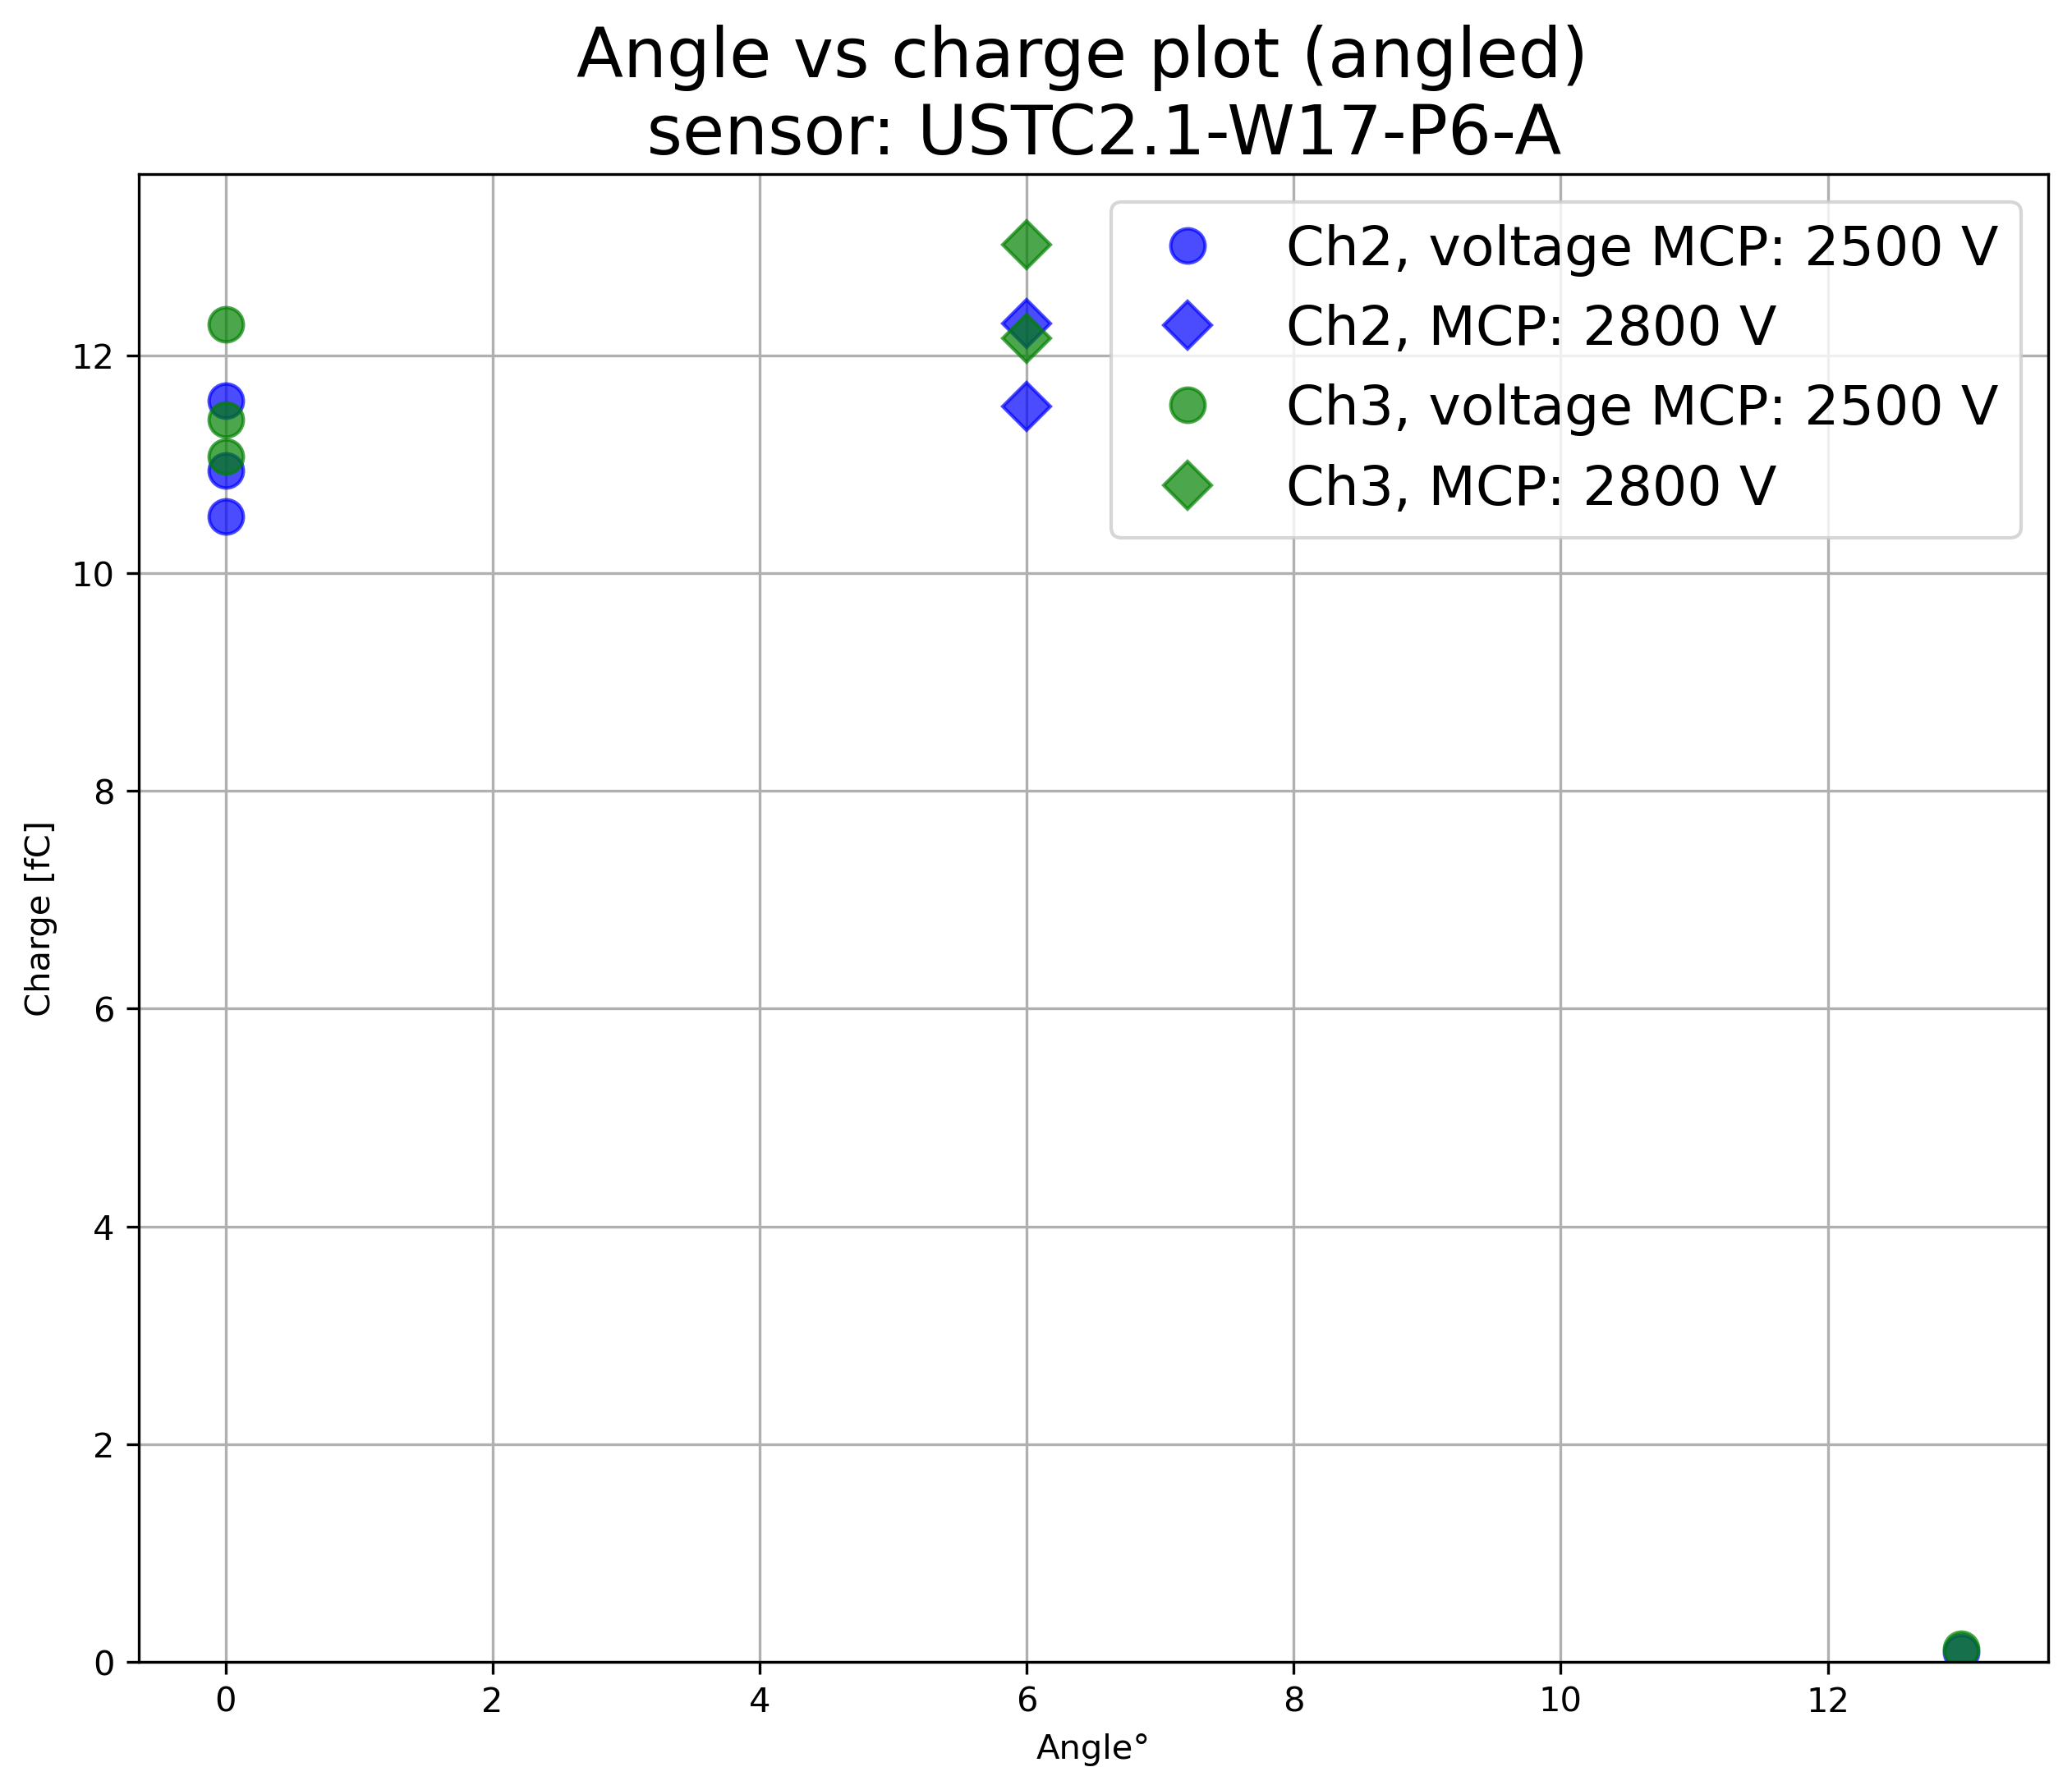

In [22]:
fig, ax = plt.subplots(figsize=(10,6), dpi=300)


for i, ch in enumerate(['Ch2','Ch3']):
    ax.plot(np.array(df_2500.loc[idx[:,:,ch]]['angle']),np.array(df_2500.loc[idx[:,:,ch]]['charge']),
            marker='o', markersize=10, linewidth=0, alpha=0.7, color=colormap[i+1],
            label=f"{ch}, voltage MCP: 2500 V")
    ax.plot(np.array(df_2800.loc[idx[:,:,ch]]['angle']),np.array(df_2800.loc[idx[:,:,ch]]['charge']),
            marker='D', markersize=10, linewidth=0, alpha=0.7, color=colormap[i+1],
            label=f"{ch}, MCP: 2800 V")
    
ax.set_title(f"Angle vs charge plot ({key_to_study}) \n \
sensor: {dict_of_batches[this_batch].S[S].channels[ch].name}", fontsize=20)
ax.set_xlabel("Angle°")
ax.set_ylabel("Charge [fC]")
ax.set_ylim(0,None)

ax.grid('--')
ax.legend(fontsize=16)

fig.savefig(f"../various plots/{this_sensor}/{key_to_study}/angle_vs_charge_{key_to_study}.svg")


### now adding voltage

In [14]:
df_analyis.loc[df_analyis['voltage']==-105].loc[idx[:,:,ch]]['angle']

batch  oscilloscope
411    S1              13.0
413    S1               6.0
407    S1               0.0
Name: angle, dtype: float64

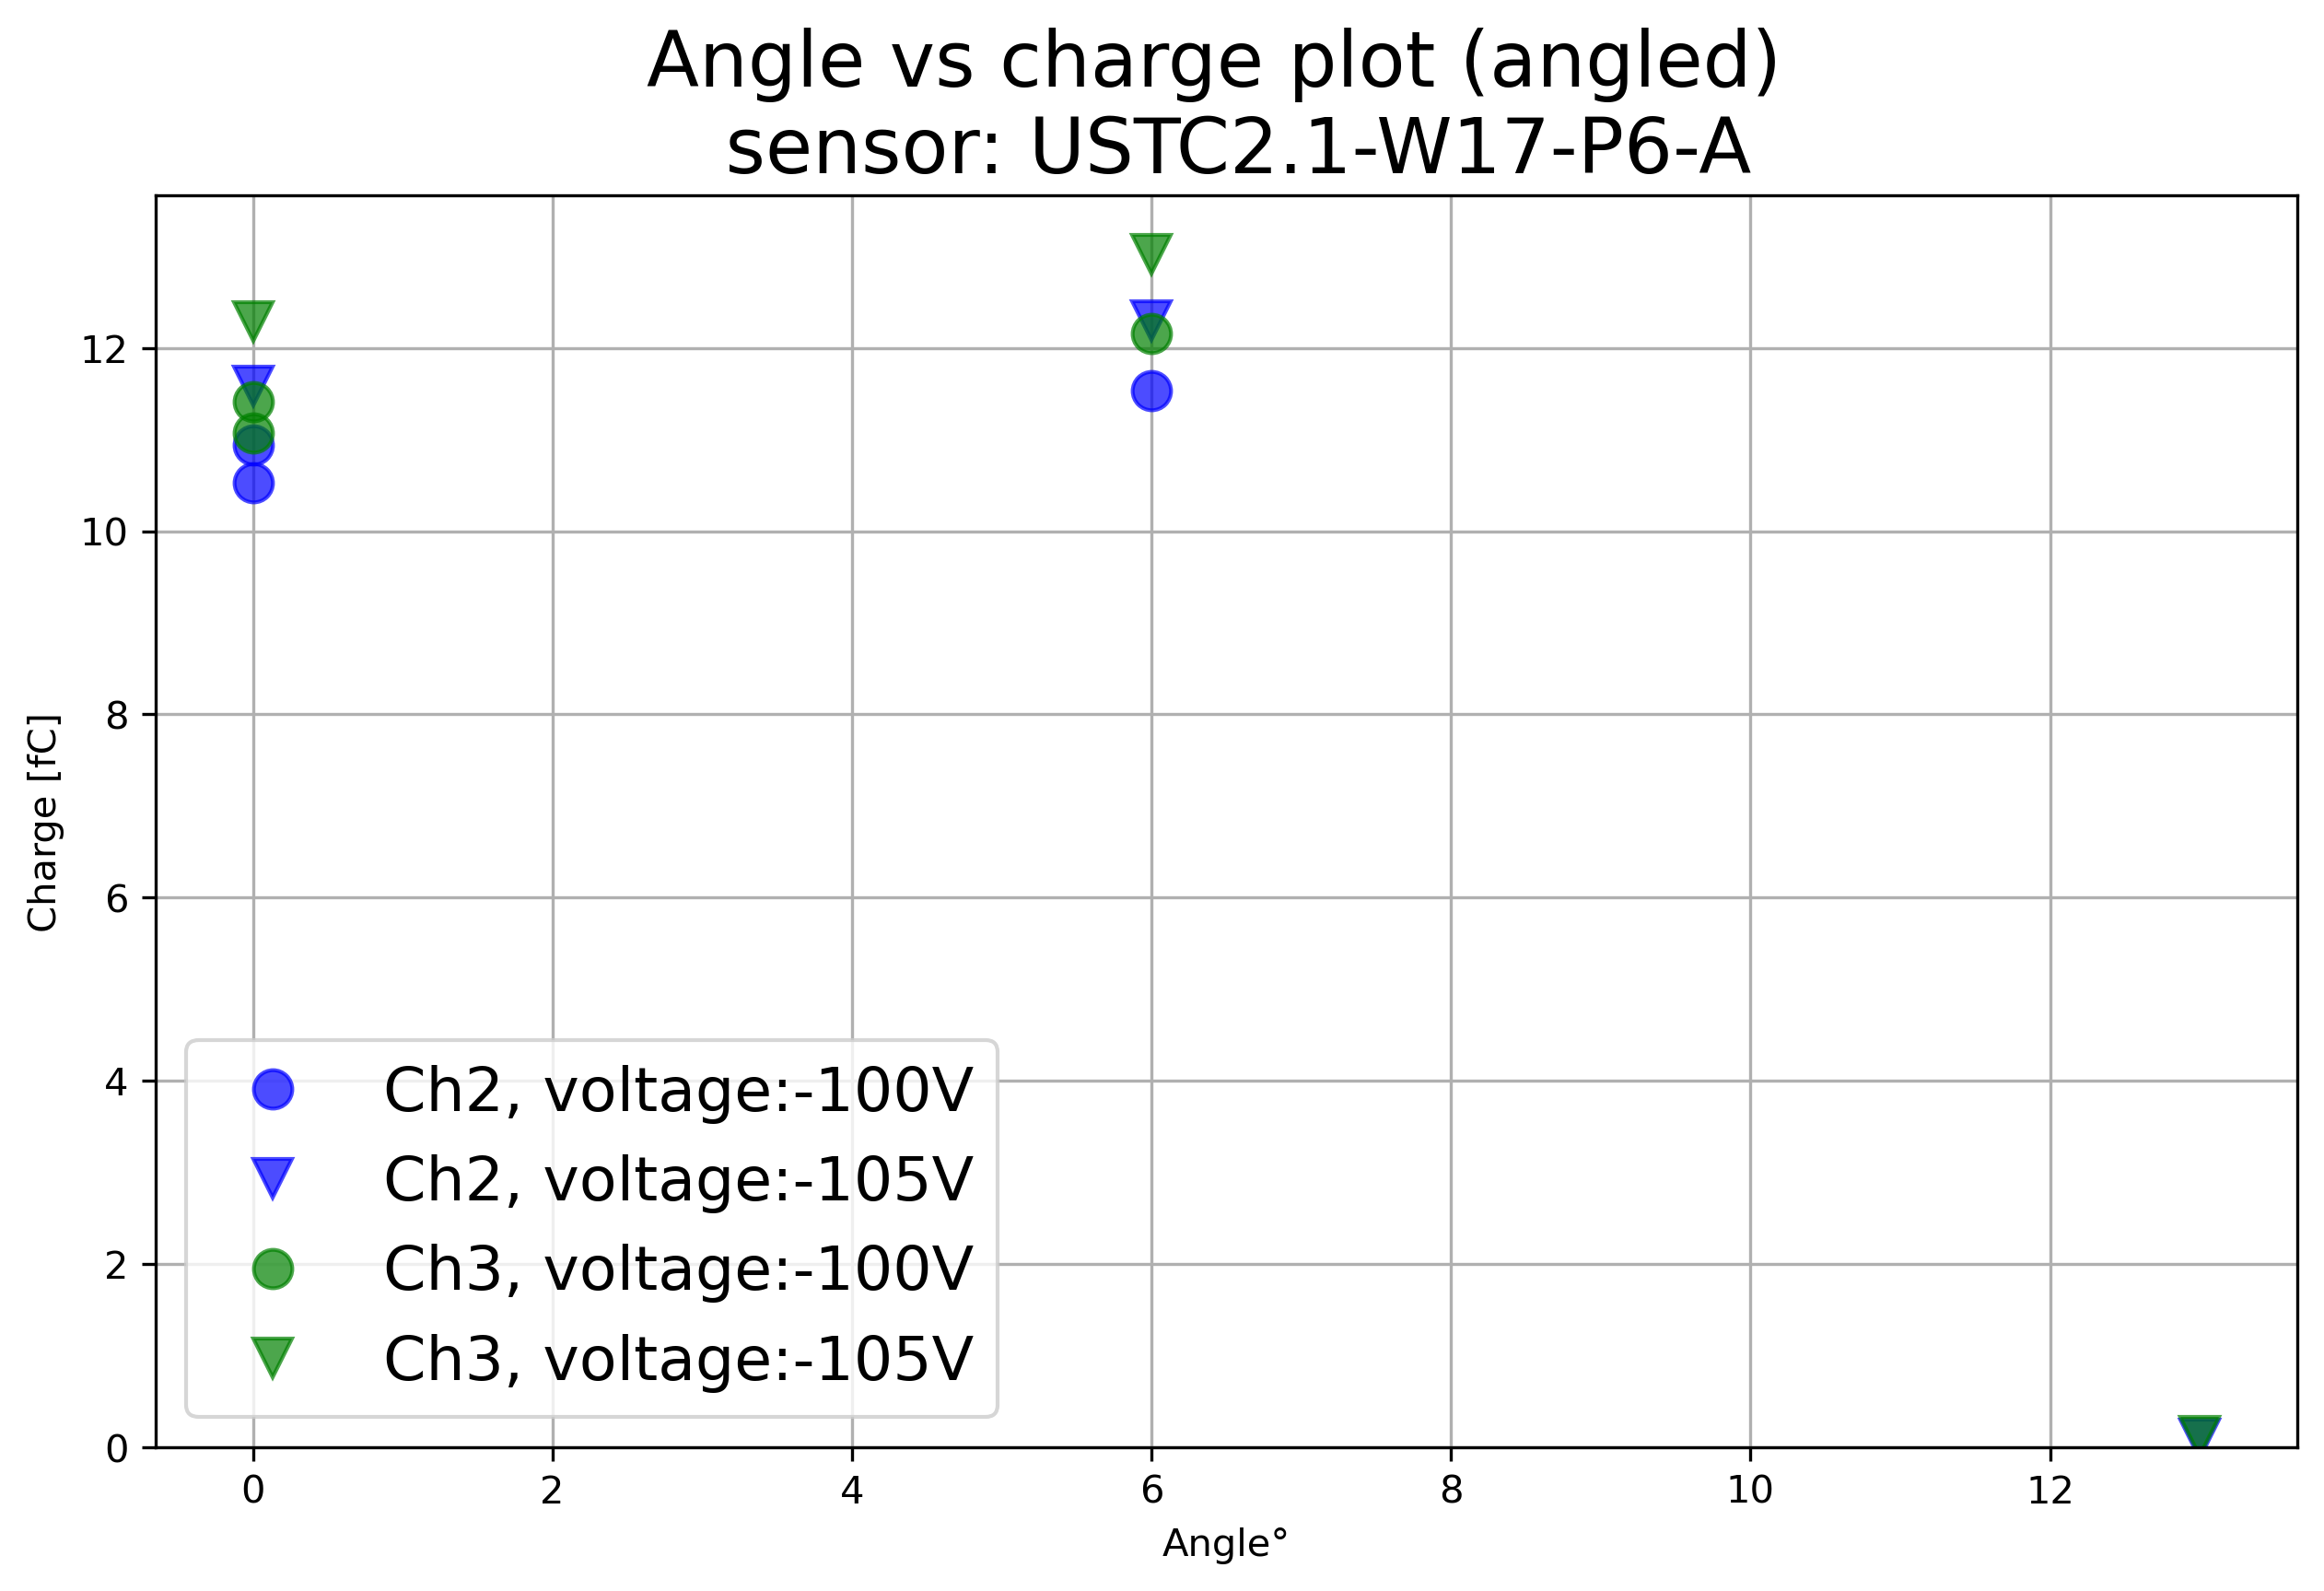

In [23]:
fig, ax = plt.subplots(figsize=(10,6), dpi=300)

for i, ch in enumerate(['Ch2','Ch3']):
    for j, volt in enumerate([-100,-105]):
        ax.plot(np.array(df_analyis.loc[df_analyis['voltage']==volt].loc[idx[:,:,ch]]['angle']),
                np.array(df_analyis.loc[df_analyis['voltage']==volt].loc[idx[:,:,ch]]['charge']),
                marker=markers[j], markersize=10, linewidth=0, alpha=0.7, color=colormap[i+1],
                label=f"{ch}, voltage:{volt}V")
#         ax.plot(np.array(df_2800.loc[idx[:,:,ch]]['angle']),np.array(df_2800.loc[idx[:,:,ch]]['charge']),
#                 marker='D', markersize=10, linewidth=0, alpha=0.7, color=colormap[i+1],
#                 label=f"{ch},")
    
ax.set_title(f"Angle vs charge plot ({key_to_study}) \n \
sensor: {dict_of_batches[this_batch].S[S].channels[ch].name}", fontsize=20)
ax.set_xlabel("Angle°")
ax.set_ylabel("Charge [fC]")
ax.set_ylim(0,None)

ax.grid('--')
ax.legend(fontsize=16)

# fig.savefig(f"../various plots/{this_sensor}/{key_to_study}/angle_vs_charge_w_voltage{key_to_study}.svg")


In [16]:
# _,my_bins,_,fig,ax = plot_histogram(df['pulseHeight_1'],bins='rice')
# plot_histogram(df['pulseHeight_1'].loc[df['charge_1']>4], bins=my_bins, fig_ax=(fig,ax))
# plot_histogram(df['pulseHeight_1'].loc[time_cuts[0]], bins=my_bins, fig_ax=(fig,ax))
# ax.semilogy()

[INFO] - 	 in 'time_mask()': Fit parameters [27050.52585112 -5493.54423579   -74.49497375   212.3960798 ]
[INFO] - 	 in 'time_mask()': Fit parameters [24708.62644316 -5519.65094034   -72.52160745   217.85123337]
[INFO] - 	 in 'time_mask()': Fit parameters [27050.52585112 -5493.54423579   -74.49497375   212.3960798 ]
[INFO] - 	 in 'time_mask()': Fit parameters [24708.62644316 -5519.65094034   -72.52160745   217.85123337]


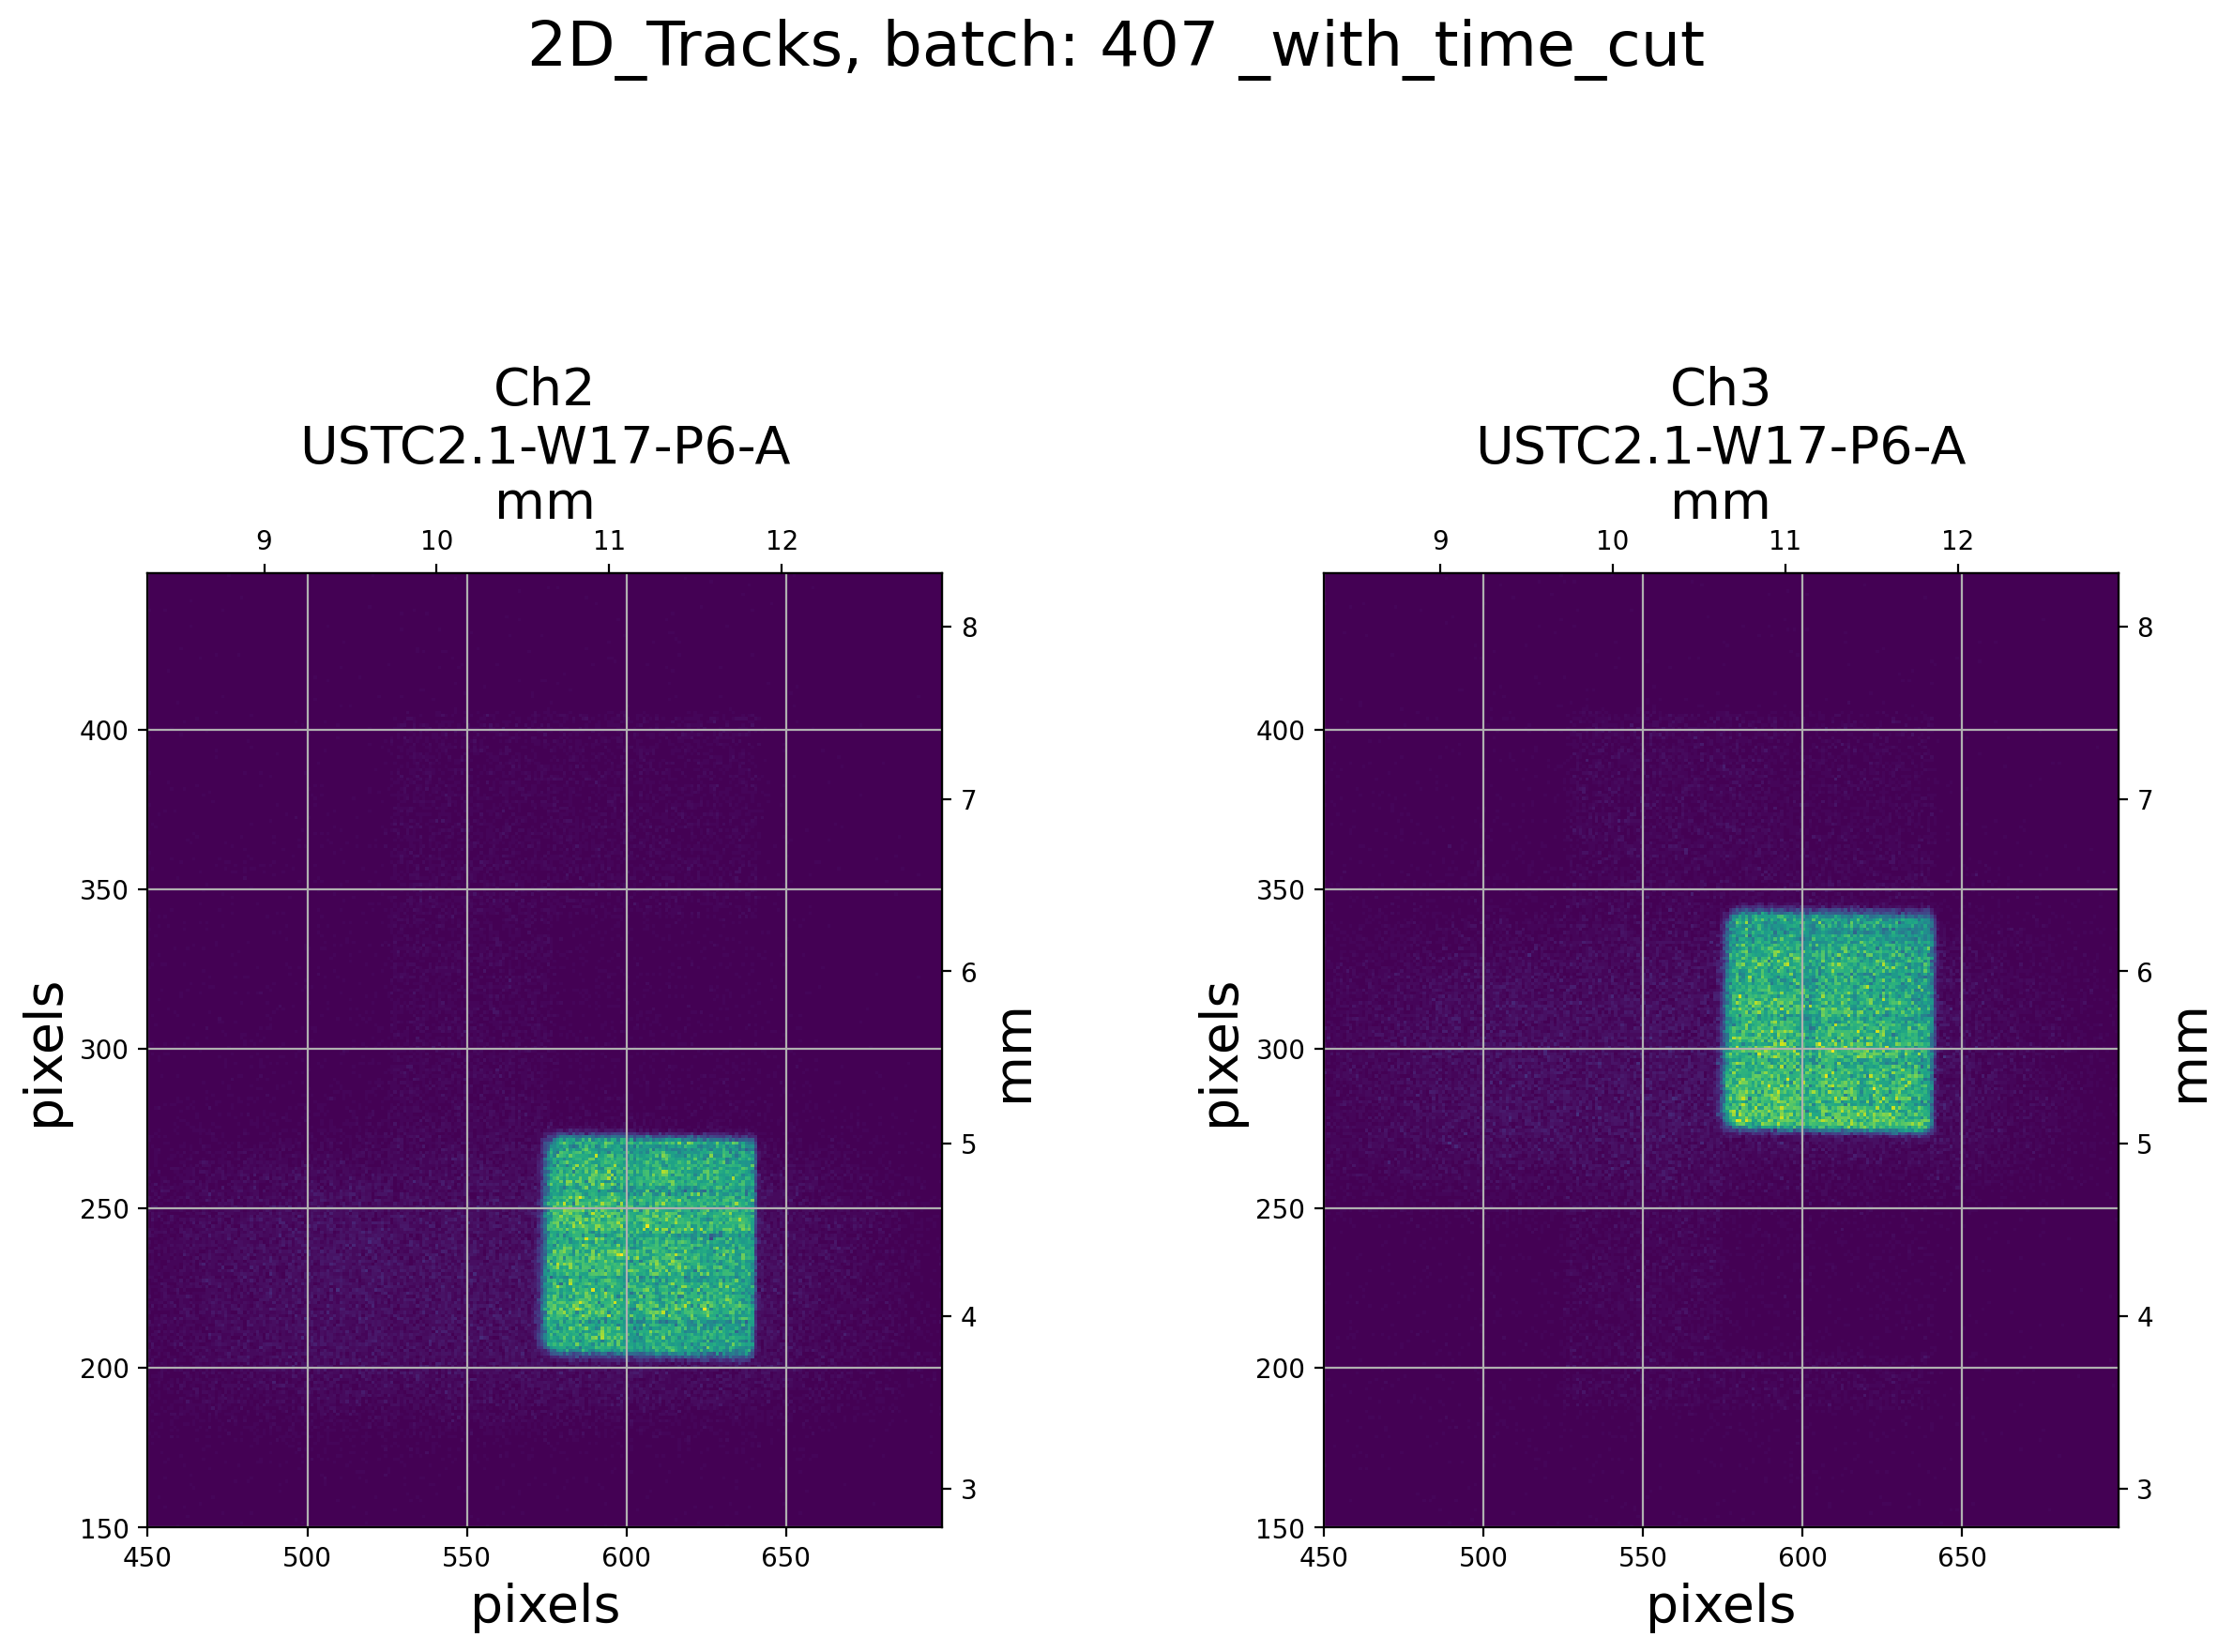

(<Figure size 2400x2000 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Ch2\nUSTC2.1-W17-P6-A'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch3\nUSTC2.1-W17-P6-A'}, xlabel='pixels', ylabel='pixels'>],
       dtype=object))

In [17]:
S = 'S1'
time_cuts = [time_mask(df, dut, bins=5000, plot=False)[0] for dut in (1,2)]
other_info = [time_mask(df, dut, bins=5000, plot=False)[1] for dut in (1,2)]
# time_cuts.insert(0,None)
plot(df, "2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2], mask=time_cuts,
    savefig=True, savefig_details='_with_time_cut',fmt='jpg')

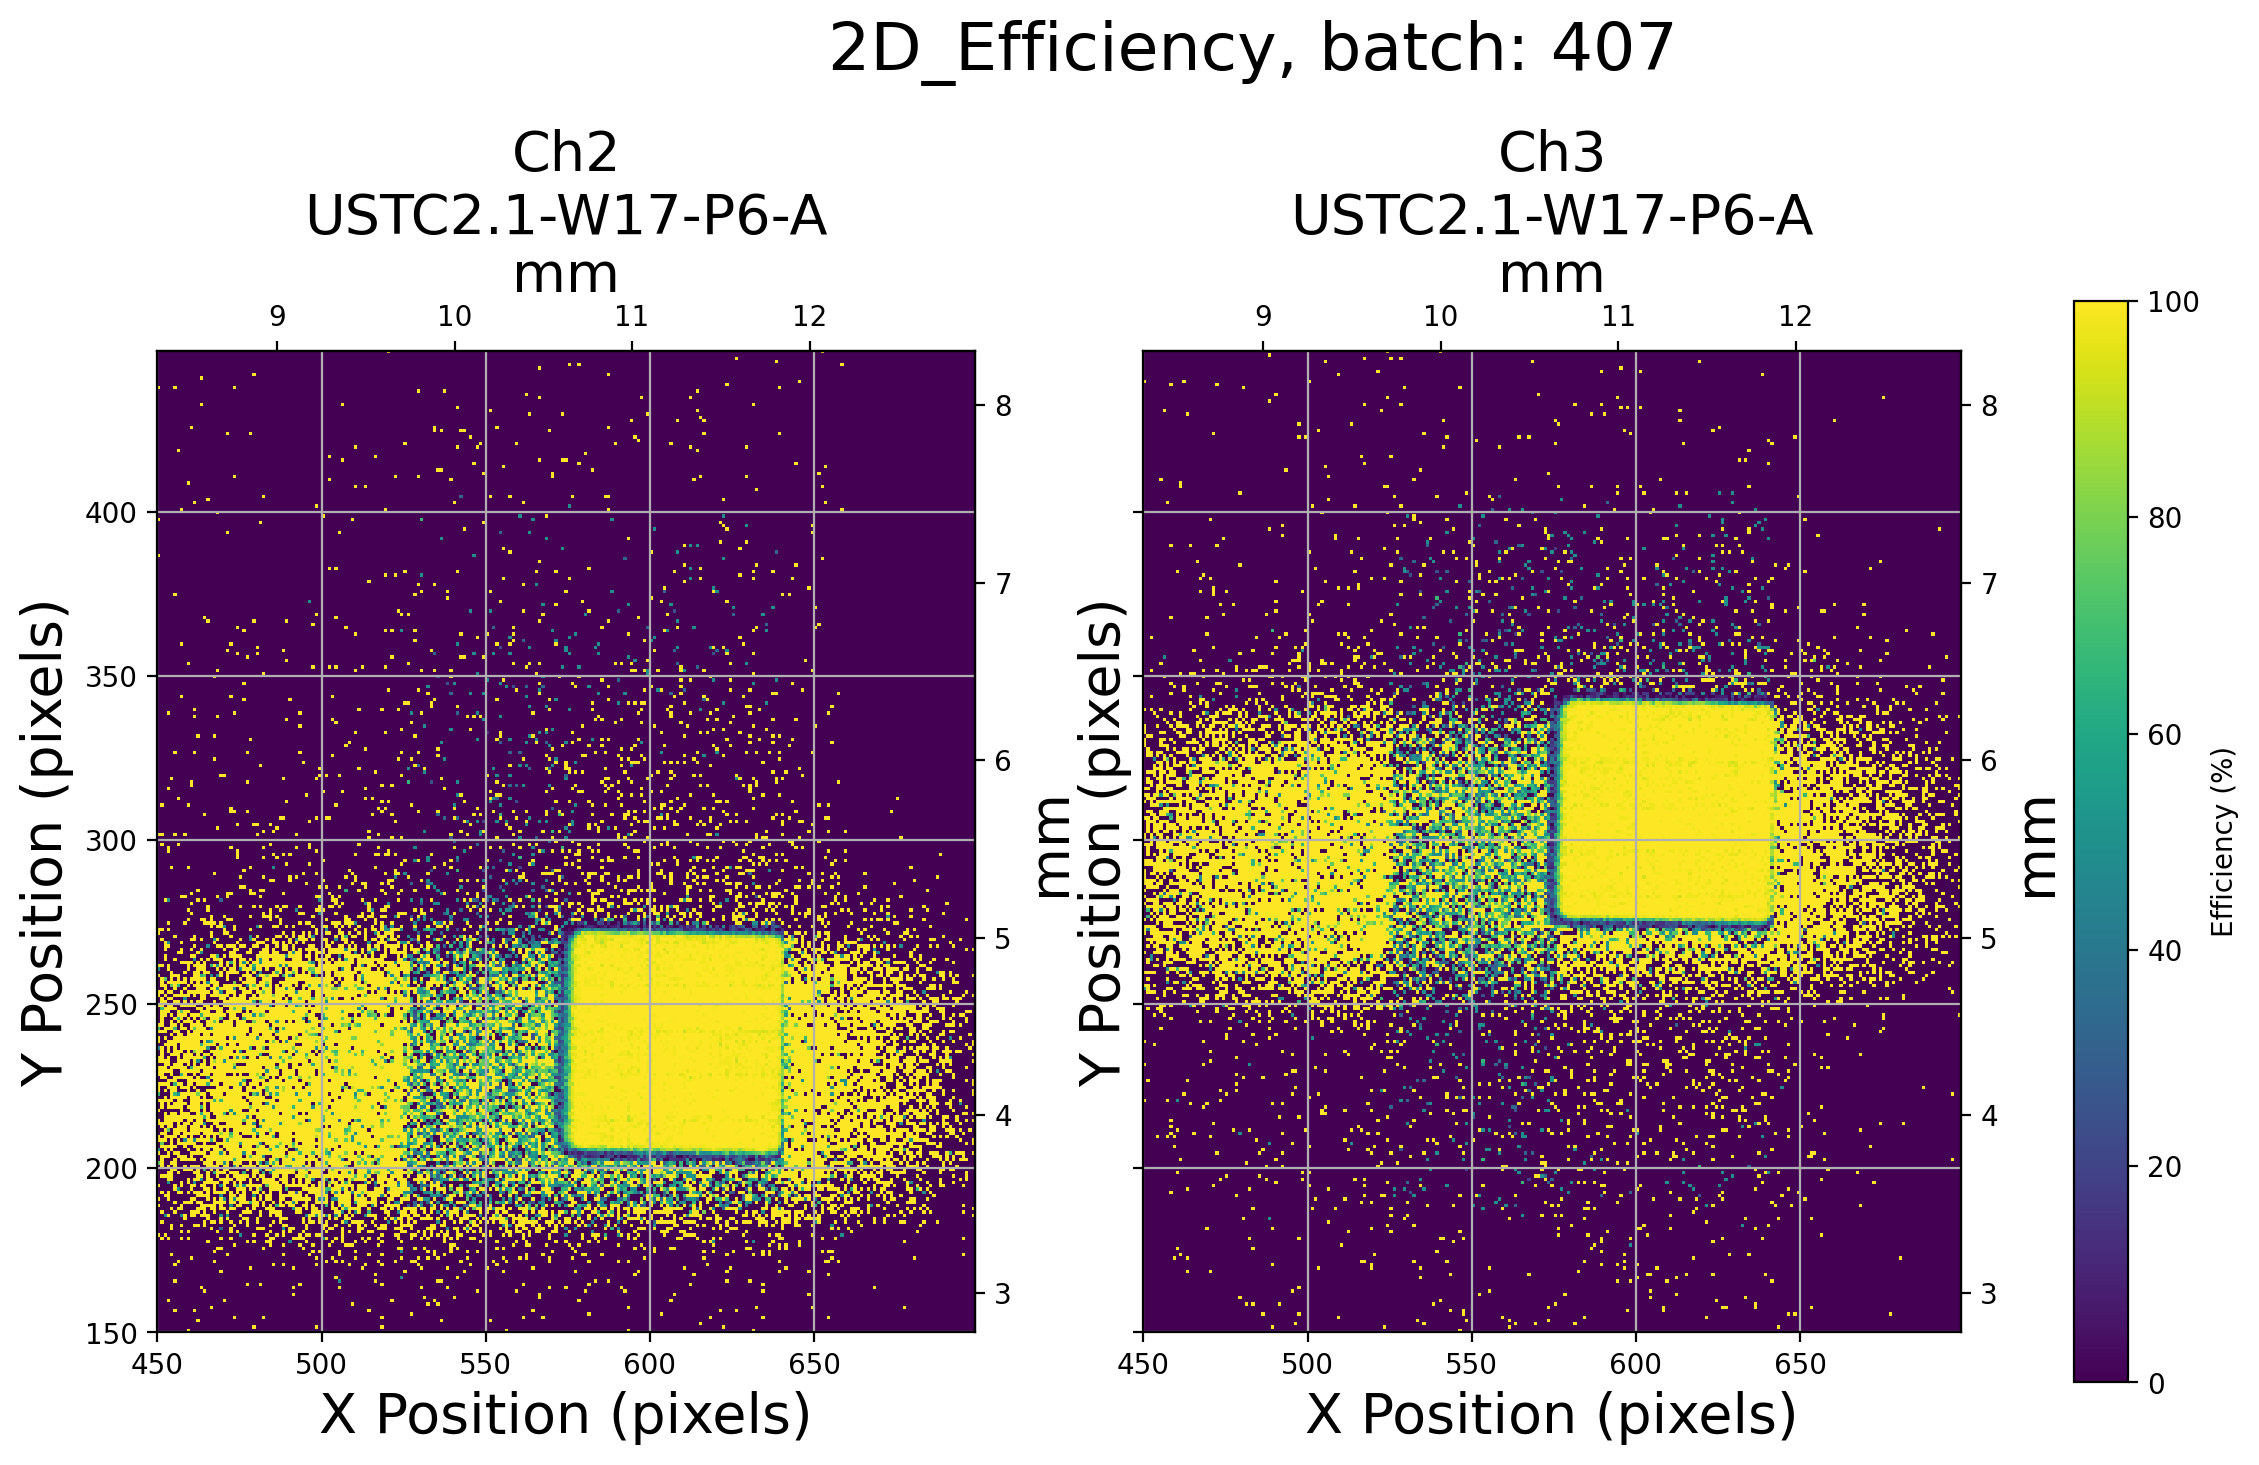

(<Figure size 2400x1200 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Ch2\nUSTC2.1-W17-P6-A'}, xlabel='X Position (pixels)', ylabel='Y Position (pixels)'>,
        <AxesSubplot:title={'center':'Ch3\nUSTC2.1-W17-P6-A'}, xlabel='X Position (pixels)', ylabel='Y Position (pixels)'>],
       dtype=object))

In [18]:
plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2], threshold_charge=4,
     mask=time_cuts)

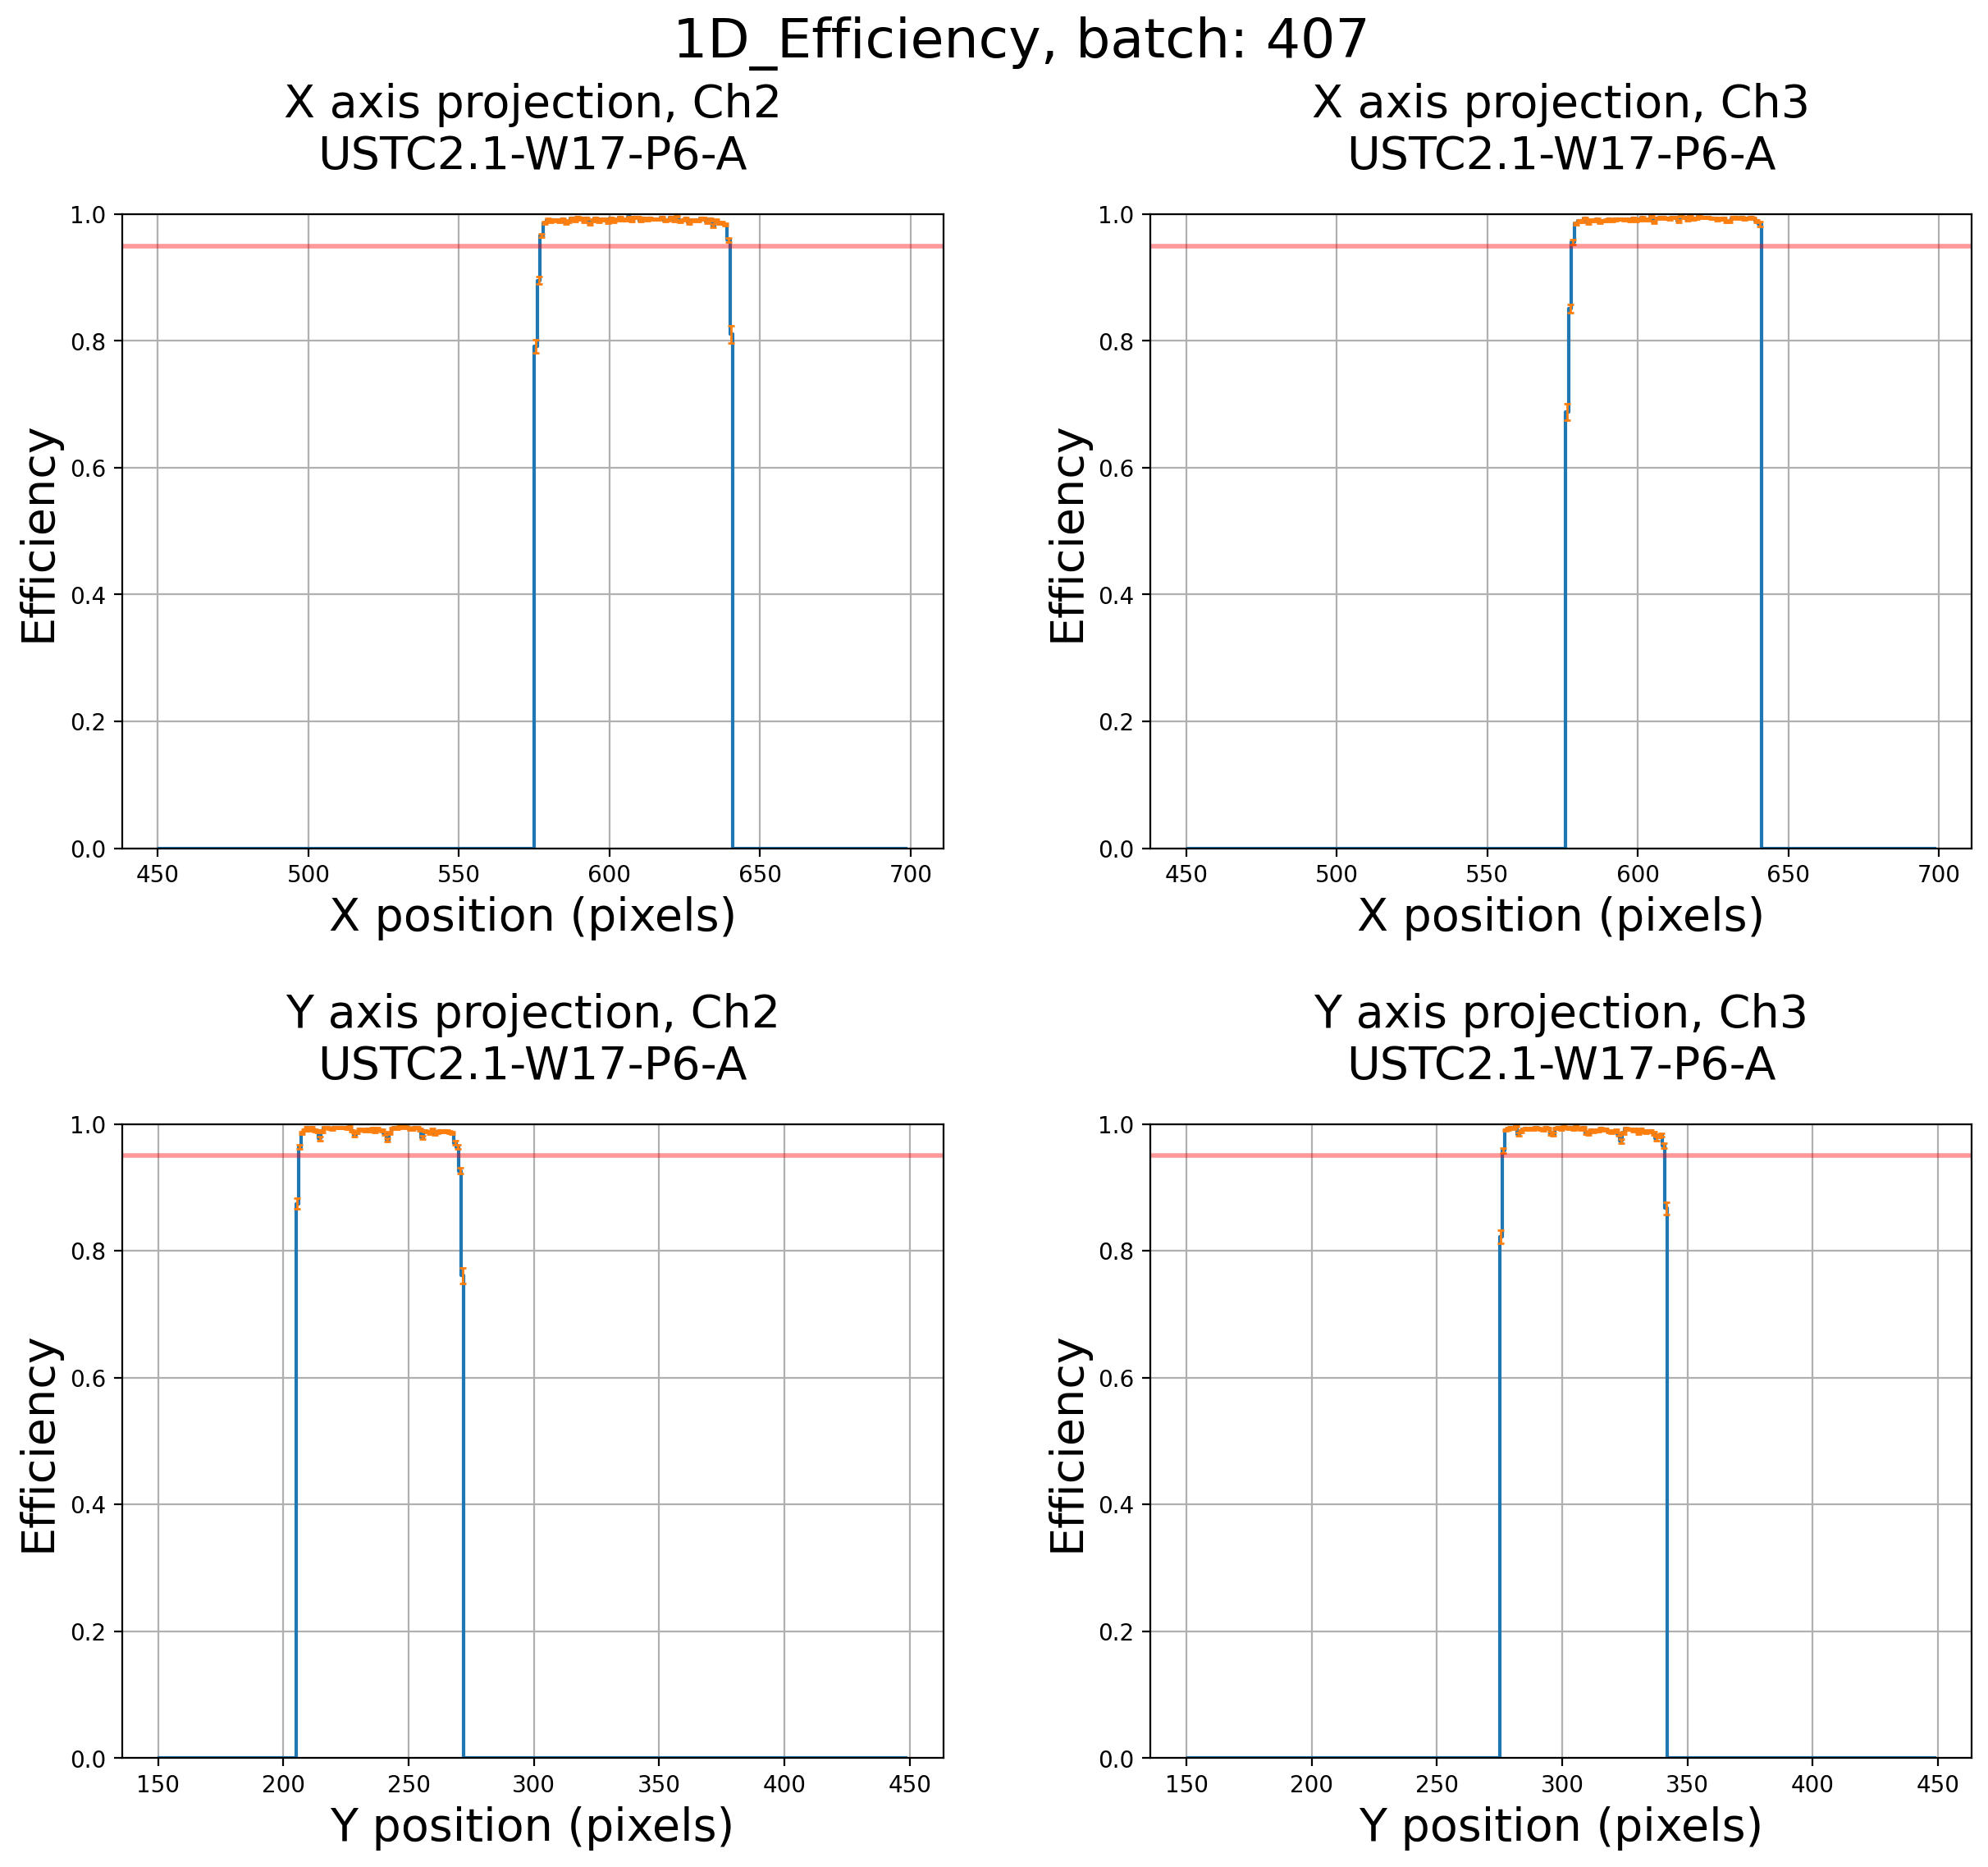

In [19]:
fig,ax = plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, bins=bins1, n_DUT=[1,2], threshold_charge=4,
             mask=time_cuts, geometry_cut=True)


In [20]:
print('Angled')
for batch_number,S,ch in USTC_dict['angled']:
    print('Batch', batch_number, 'MCP voltage:', dict_of_batches[batch_number].S[S].channels['Ch1'].voltage)
    print('sensor angle:',dict_of_batches[batch_number].angle)
#     df = load_batch(batch_number, S)
    

Angled
Batch 411 MCP voltage: 2500
sensor angle: 13.0
Batch 411 MCP voltage: 2500
sensor angle: 13.0
Batch 412 MCP voltage: 2500
sensor angle: 13.0
Batch 412 MCP voltage: 2500
sensor angle: 13.0
Batch 413 MCP voltage: 2800
sensor angle: 6.0
Batch 413 MCP voltage: 2800
sensor angle: 6.0
Batch 414 MCP voltage: 2800
sensor angle: 6.0
Batch 414 MCP voltage: 2800
sensor angle: 6.0
Batch 403 MCP voltage: 2500
sensor angle: 0.0
Batch 403 MCP voltage: 2500
sensor angle: 0.0
Batch 406 MCP voltage: 2500
sensor angle: 0.0
Batch 406 MCP voltage: 2500
sensor angle: 0.0
Batch 407 MCP voltage: 2500
sensor angle: 0.0
Batch 407 MCP voltage: 2500
sensor angle: 0.0
